# SeNet Generic multi

In [1]:
%reset -f 
%matplotlib inline
import matplotlib.pyplot as plt
import time
from shutil import copyfile
from os.path import isfile, join, abspath, exists, isdir, expanduser
from os import listdir, makedirs, getcwd, remove
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
import pandas as pd
import numpy as np
import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as func
import torchvision
from torchvision import transforms, datasets, models
import random 


import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
# call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())

print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())

use_cuda = torch.cuda.is_available()
# use_cuda = False

print("USE CUDA=" + str (use_cuda))
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
Tensor = FloatTensor

manualSeed = None
def fixSeed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if use_cuda:
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


if manualSeed is None:
        manualSeed = 999
fixSeed(manualSeed)



__Python VERSION: 3.6.2 |Anaconda custom (64-bit)| (default, Sep 19 2017, 08:03:39) [MSC v.1900 64 bit (AMD64)]
__pyTorch VERSION: 0.3.1.post2
__CUDA VERSION
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2017 NVIDIA Corporation
Built on Fri_Sep__1_21:08:32_Central_Daylight_Time_2017
Cuda compilation tools, release 9.0, V9.0.176
__CUDNN VERSION: 7003
__Number CUDA Devices: 1
__Devices
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0
USE CUDA=True


In [2]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

from kmodels import *
from kdataset import *

### Define Custom Dataset

In [3]:
import os
dataset='cat-dog' # bone , cat-dog   d:/db/data/cat-dog/train/ ISIC2017
data_dir= 'd:/db/data/' +  dataset + '/train/'
# data_dir_valid= 'd:/db/data/' +  dataset + '/valid/'

classes, class_to_idx, num_to_class, df =GenericDataset.find_classes (data_dir )

print (classes)
print (class_to_idx)
print (num_to_class)
df.head(5)    

['cat', 'dog']
{'cat': 0, 'dog': 1}
{0: 'cat', 1: 'dog'}


,file,category,category_id
0,cat/cat.0.jpg,cat,0
1,cat/cat.1.jpg,cat,0
2,cat/cat.10.jpg,cat,0
3,cat/cat.100.jpg,cat,0
4,cat/cat.1000.jpg,cat,0


In [4]:
len(classes)

2

# Target distribution : Train set

c:\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


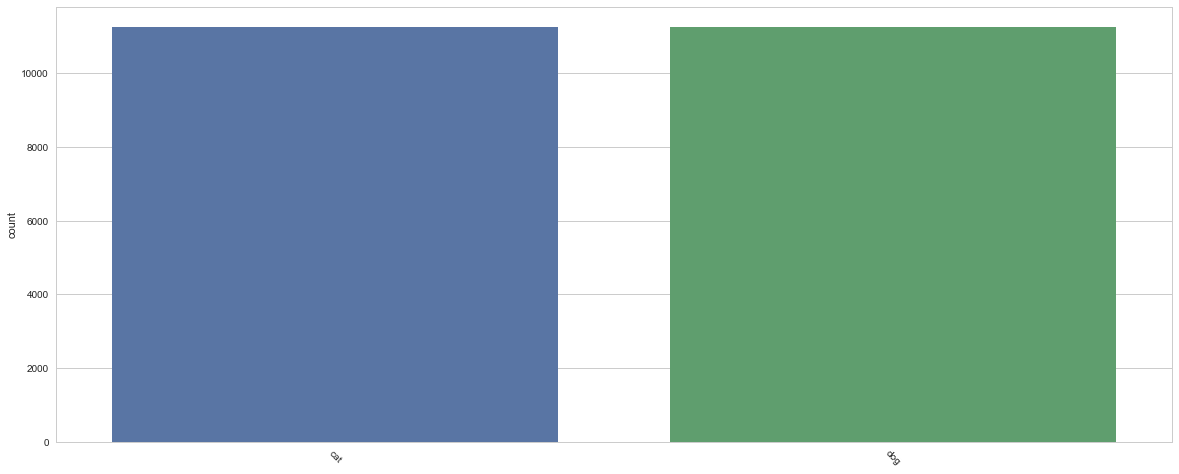

In [5]:
import seaborn as sns
sns.set(color_codes=True)
pal = sns.color_palette()
sns.set_style("whitegrid")

labels = df['category'].apply(lambda x: x.split(' '))
from collections import Counter, defaultdict
counts = defaultdict(int)
for l in labels:
    for l2 in l:
        counts[l2] += 1

counts_df = pd.DataFrame.from_dict(counts, orient='index')
counts_df.columns = ['count']
counts_df.sort_values('count', ascending=False, inplace=True)

fig, ax = plt.subplots()
ax = sns.barplot(x=counts_df.index, y=counts_df['count'], ax=ax)
fig.set_size_inches(20,8)
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=-45);

# Augmentation 

In [6]:
from __future__ import absolute_import

from torchvision.transforms import *

from PIL import Image, ImageDraw
import numpy as np
import torch

import torchvision
import random
from PIL import Image, ImageOps
import numpy as np
import numbers
import math
import torch
import torch
import random
import PIL.ImageEnhance as ie
import PIL.Image as im

# adapted from https://github.com/kuangliu/pytorch-retinanet/blob/master/transform.py
# https://github.com/mratsim/Amazon-Forest-Computer-Vision/blob/master/src/p_data_augmentation.py

normalize_img = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

from ktransforms import *

## Setup transforms, datasets, and dataloaders

- Data loaders spit out data from a dataset in batches. This is what you actually feed the neural network during training.

{'train': 19125, 'valid': 3375}
0    9570
1    9555
Name: category_id, dtype: int64


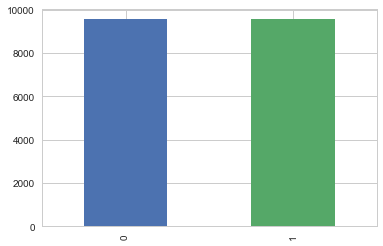

In [7]:
image_size = 224

normalize_img = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])


train_trans = transforms.Compose([
    transforms.RandomSizedCrop(image_size),
    PowerPIL(),
    transforms.ToTensor(),
#     normalize_img,
    RandomErasing()
])

## Normalization only for validation and test
valid_trans = transforms.Compose([
    transforms.Scale(256),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
#     normalize_img
])

batch_size = 8
train_data = df.sample(frac=0.85)
valid_data = df[~df['file'].isin(train_data['file'])]

train_set = GenericDataset(train_data, data_dir, transform = train_trans)
valid_set = GenericDataset(valid_data, data_dir, transform = valid_trans)
        

t_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
v_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0)
# test_loader  = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4)

dataset_sizes = {
    'train': len(t_loader.dataset), 
    'valid': len(v_loader.dataset)
}


print (dataset_sizes)
print (train_data["category_id"].value_counts())

train_data['category_id'].value_counts().plot(kind='bar')

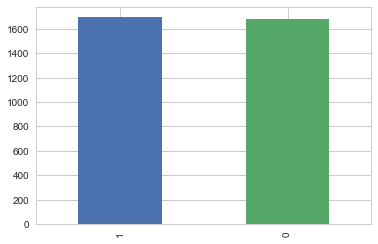

In [8]:
valid_data['category_id'].value_counts().plot(kind='bar')

### Test the DataLoader Class

i=0: 
i=1: 
i=2: 
i=3: 


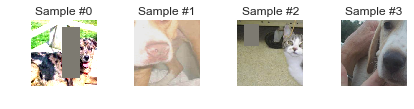

In [9]:
imagesToShow=4

def flaotTensorToImage(img, mean=0, std=1):
        """convert a tensor to an image"""
        img = np.transpose(img.numpy(), (1, 2, 0))
        img = (img*std+ mean)*255
        img = img.astype(np.uint8)    
        return img    

if __name__ == '__main__':  
    for i, data in enumerate(t_loader, 0):
        print('i=%d: '%(i))            
        images, labels = data            
        num = len(images)

        ax = plt.subplot(1, imagesToShow, i + 1)
        plt.tight_layout()
        ax.set_title('Sample #{}'.format(i))
        ax.axis('off')

        for n in range(num):
            image=images[n]
            label=labels[n]
            plt.imshow (flaotTensorToImage(image))

        if i==imagesToShow-1:
            break

## Define the model
- A simple CNN with great performance (95% accuracy) 
- In PyTorch, a model is defined by a subclass of nn.Module. It has two methods:

`__init__:` constructor. Create layers here. Note that we don't define the connections between layers in this function.

`forward(x):` forward function. Receives an input variable x. Returns a output variable. Note that we actually connect the layers here dynamically.

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import math 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from collections import OrderedDict
from torch.nn import init
import numpy as np

model = SimpleNet(len(classes), 3)
# model =vggnetXX_generic(len(classes), 3)
# model =lenetXX_generic(len(classes), 3)
# model =resnetxtXX_generic(len(classes), 3)
# model =wrnXX_generic(len(classes), 3)
# model = senetXX_generic(len(classes), 3, 32)


criterion = torch.nn.CrossEntropyLoss()
lr= 0.00005 * 2 * 2
optimizer = torch.optim.Adam(model.parameters(),lr=lr)

if use_cuda:
    model = model.cuda()
# model = senetXX_generic(len(classes), 3, 32)
model_name = (type(model).__name__) # remember the real name
# model = torch.nn.DataParallel(model, device_ids=list(range(4)))
print(model)

SimpleNet(
  (avgpool): AdaptiveAvgPool2d(output_size=1)
  (cnn1): ConvCNN(
    (math): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (2): LeakyReLU(0.01)
      (3): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), dilation=(1, 1), ceil_mode=False)
    )
    (avgpool): AvgPool2d(kernel_size=4, stride=4, padding=0, ceil_mode=False, count_include_pad=True)
  )
  (cnn2): ConvCNN(
    (math): Sequential(
      (0): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (2): LeakyReLU(0.01)
      (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    )
    (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False, count_include_pad=True)
  )
  (cnn3): ConvCNN(
    (math): Sequential(
      (0): Conv2d(64, 512, kernel_size=(5, 5), stride=(1, 1), padding=(2,

# Metrics and Tensorboard

In [11]:
import datetime 

from utils import *

NOW_TIME = datetime.datetime.now()
NOW_TIME =NOW_TIME.strftime("%Y-%m-%d %H:%M")

use_tensorboard=False

hms_string(1000)

'0:16:40.00'

### Training

In [12]:
from tqdm import tqdm 
from sklearn import metrics
import torch
import numpy as np
from sklearn import cross_validation
from sklearn import metrics
from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc

def train(train_loader, model, epoch, optimizer):
    if use_cuda:
        model.cuda()
        criterion.cuda()

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    acc = AverageMeter()
   
    # switch to train mode
    model.train()

    end = time.time()
    for batch_idx, (images, target) in enumerate(train_loader): 
        correct = 0
        # measure data loading time
        data_time.update(time.time() - end)

        if use_cuda:
            images, target = images.cuda(), target.cuda()
            images, target = Variable(images), Variable(target)
        # compute y_pred
        y_pred = model(images)
        loss = criterion(y_pred, target)

        # measure accuracy and record loss
        prec1, prec1 = accuracy2(y_pred.data, target.data, topk=(1, 1))
        losses.update(loss.data[0], images.size(0))
        acc.update(prec1[0], images.size(0))
        
        pred = y_pred.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()
        accuracy = 100. * correct / len(images)
        
        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if batch_idx % 200  == 0:
            print('TRAIN: LOSS-->{loss.val:.4f} ({loss.avg:.4f})\t' 'ACC-->{acc.val:.3f}% ({acc.avg:.3f}%)'.format(loss=losses, acc=acc))
            if use_tensorboard:
                exp.add_scalar_value('tr_epoch_loss', losses.avg, step=epoch)
                exp.add_scalar_value('tr_epoch_acc', acc.avg, step=epoch)
                
            print('TRAIN: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {}/{} ({:.3f}%)'.format(
                epoch, batch_idx * len(images), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0],
                correct, len(images),
                accuracy))            
    

    return float('{loss.avg:.4f}'.format(loss=losses)), float('{acc.avg:.4f}'.format(acc=acc))

def validate(val_loader, model, epoch):
    if use_cuda:
        model.cuda()
        criterion.cuda()

    batch_time = AverageMeter()
    losses = AverageMeter()
    acc = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, (images, labels) in enumerate(val_loader):

        if use_cuda:
            images, labels = images.cuda(), labels.cuda()
            images, labels = Variable(images, volatile=True), Variable(labels)

        # compute y_pred
        y_pred = model(images)
        loss = criterion(y_pred, labels)

        # measure accuracy and record loss
        prec1, temp_var = accuracy2(y_pred.data, labels.data, topk=(1, 1))
        losses.update(loss.data[0], images.size(0))
        acc.update(prec1[0], images.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % 200== 0:
            print('VAL:   LOSS--> {loss.val:.4f} ({loss.avg:.4f})\t''ACC-->{acc.val:.3f} ({acc.avg:.3f})'.format(loss=losses, acc=acc))

        if i % 50 == 0:
            if use_tensorboard:
                exp.add_scalar_value('val_epoch_loss', losses.avg, step=epoch)
                exp.add_scalar_value('val_epoch_acc', acc.avg, step=epoch)

    print(' * Accuracy {acc.avg:.4f}'.format(acc=acc))
    return float('{loss.avg:.6f}'.format(loss=losses)), float('{acc.avg:.6f}'.format(acc=acc))


def testImageLoader(image_name):
    """load image, returns cuda tensor"""
#     image = Image.open(image_name)
    image = Image.open(image_name).convert('RGB')
    image = test_trans(image)
#     image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  
    if use_cuda:
#         print ("cuda")
        image.cuda()         
    return image  

def testModel(test_dir, local_model):    
    if use_cuda:
        local_model.cuda()
    
    local_model.eval()
    
    columns = ['file', 'species']
    df_pred = pd.DataFrame(data=np.zeros((0, len(columns))), columns=columns)
#     df_pred.species.astype(int)
    for index, row in (sample_submission.iterrows()):
#         for file in os.listdir(test_dir):            
        currImage=os.path.join(test_dir, row['file'])
        if os.path.isfile(currImage):
            X_tensor_test=testImageLoader (currImage)            
#             print (type(X_tensor_test))
            if use_cuda:
                X_tensor_test = Variable(X_tensor_test.cuda()) 
            else:
                X_tensor_test = Variable(X_tensor_test)        
            
            # get the index of the max log-probability
            predicted_val = (local_model(X_tensor_test)).data.max(1)[1] # get the index of the max log-probability
#             predicted_val = predicted_val.data.max(1, keepdim=True)[1]
            p_test = (predicted_val.cpu().numpy().item())
            df_pred = df_pred.append({'file': row['file'], 'species': num_to_class[int(p_test)]}, ignore_index=True)             
    
    return df_pred

c:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [13]:
test_trans = valid_trans
test_data_dir = 'd:/db/data/seedlings/test/'

### Train the model

In [13]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission.columns = ['file', 'species']
# sample_submission['category_id'] = 0
sample_submission.head(3)

if __name__ == '__main__':  
    epochs=150
    runId = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')    
    recorder = RecorderMeter(epochs)  # epoc is updated
#     model_name = (type(model).__name__)

    exp_name = datetime.datetime.now().strftime(model_name + '_' + dataset + '_%Y-%m-%d_%H-%M-%S')    
    mPath = './logs' + '/' + dataset + '/' + model_name + '/'    
    if not os.path.isdir(mPath):
        os.makedirs(mPath)    
    print("Random Seed: {}".format(manualSeed))
    print("python version : {}".format(sys.version.replace('\n', ' ')))
    print("torch  version : {}".format(torch.__version__))
    print("cudnn  version : {}".format(torch.backends.cudnn.version()))    
    print("=> Final model name '{}'".format(model_name))            
    print ("MODEL: {}".format( str(model_name)))
    print ("dataset: {}".format(dataset))
    print('    Total params: %.2fM' % (sum(p.numel() for p in model.parameters()) / 1000000.0))    
    
    print ("MODEL: {}".format( str(type(model).__name__)))
    
    start_training_time = time.time()
    training_time=time.time()
    for epoch in tqdm(range(0, epochs)):        
        train_result, accuracy_tr=train(t_loader, model, epoch, optimizer)
        val_loss, val_accuracy= validate(v_loader, model, epoch)  
        
        recorder.update(epoch, train_result, accuracy_tr, val_loss, val_accuracy) 
        training_time=time.time() - start_training_time
        recorder.plot_curve(os.path.join(mPath, model_name + '_' + exp_name + '.png'),training_time, model, model_name,
                            str(dataset_sizes),
                        batch_size, lr,dataset,manualSeed,len(classes))
        
        if float(val_accuracy) > float(95.0):            
            print ("EARLY STOP")            
#             df_pred=testModel(test_data_dir,model)
#             df_pred.to_csv(str(type(model).__name__) + '_' + str(val_accuracy) + '_' + 
#                            str(epoch) + "_sub.csv", columns=('file', 'species'), index=None)
#             torch.save(model.state_dict(), os.path.join(mPath, model_name + '_' + runId + '_' + str(val_accuracy) + '_.pth'))                        

Random Seed: 999
python version : 3.6.2 |Anaconda custom (64-bit)| (default, Sep 19 2017, 08:03:39) [MSC v.1900 64 bit (AMD64)]
torch  version : 0.3.1.post2
cudnn  version : 7003
=> Final model name 'SimpleNet'
MODEL: SimpleNet
dataset: cat-dog
    Total params: 1.07M
MODEL: SimpleNet


  0%|                                                                                                                                                           | 0/150 [00:00<?, ?it/s]

TRAIN: LOSS-->0.6986 (0.6986)	ACC-->50.000% (50.000%)
TRAIN: 0 [0/19125 (0%)]	Loss: 0.698567, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.6930 (0.6956)	ACC-->50.000% (55.037%)
TRAIN: 0 [1600/19125 (8%)]	Loss: 0.692995, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.7244 (0.6892)	ACC-->62.500% (55.486%)
TRAIN: 0 [3200/19125 (17%)]	Loss: 0.724389, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.5915 (0.6875)	ACC-->87.500% (55.720%)
TRAIN: 0 [4800/19125 (25%)]	Loss: 0.591453, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.6773 (0.6849)	ACC-->75.000% (55.993%)
TRAIN: 0 [6400/19125 (33%)]	Loss: 0.677267, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.6527 (0.6844)	ACC-->37.500% (55.907%)
TRAIN: 0 [8000/19125 (42%)]	Loss: 0.652670, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->0.7184 (0.6831)	ACC-->50.000% (55.985%)
TRAIN: 0 [9600/19125 (50%)]	Loss: 0.718363, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.7776 (0.6811)	ACC-->37.500% (56.254%)
TRAIN: 0 [11200/19125 (59%)]	Loss: 0.777606, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->0.8200 (0.6807

  1%|▉                                                                                                                                               | 1/150 [03:36<8:58:42, 216.93s/it]

TRAIN: LOSS-->0.6848 (0.6848)	ACC-->25.000% (25.000%)
TRAIN: 1 [0/19125 (0%)]	Loss: 0.684819, Accuracy: 2/8 (25.000%)
TRAIN: LOSS-->0.8114 (0.6602)	ACC-->37.500% (58.209%)
TRAIN: 1 [1600/19125 (8%)]	Loss: 0.811428, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->0.6233 (0.6625)	ACC-->62.500% (58.666%)
TRAIN: 1 [3200/19125 (17%)]	Loss: 0.623326, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.5415 (0.6612)	ACC-->75.000% (58.715%)
TRAIN: 1 [4800/19125 (25%)]	Loss: 0.541461, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.5788 (0.6618)	ACC-->62.500% (58.521%)
TRAIN: 1 [6400/19125 (33%)]	Loss: 0.578793, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.6641 (0.6609)	ACC-->50.000% (58.641%)
TRAIN: 1 [8000/19125 (42%)]	Loss: 0.664068, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.6207 (0.6609)	ACC-->75.000% (58.701%)
TRAIN: 1 [9600/19125 (50%)]	Loss: 0.620719, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.6115 (0.6617)	ACC-->75.000% (58.878%)
TRAIN: 1 [11200/19125 (59%)]	Loss: 0.611548, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.6278 (0.6591

  1%|█▉                                                                                                                                              | 2/150 [05:56<7:19:51, 178.32s/it]

TRAIN: LOSS-->0.6175 (0.6175)	ACC-->75.000% (75.000%)
TRAIN: 2 [0/19125 (0%)]	Loss: 0.617476, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.5044 (0.6437)	ACC-->62.500% (62.002%)
TRAIN: 2 [1600/19125 (8%)]	Loss: 0.504426, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.6918 (0.6518)	ACC-->50.000% (61.222%)
TRAIN: 2 [3200/19125 (17%)]	Loss: 0.691843, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.5628 (0.6518)	ACC-->62.500% (61.002%)
TRAIN: 2 [4800/19125 (25%)]	Loss: 0.562829, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->1.3664 (0.6527)	ACC-->25.000% (61.205%)
TRAIN: 2 [6400/19125 (33%)]	Loss: 1.366443, Accuracy: 2/8 (25.000%)
TRAIN: LOSS-->0.6178 (0.6531)	ACC-->62.500% (61.039%)
TRAIN: 2 [8000/19125 (42%)]	Loss: 0.617778, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.8665 (0.6529)	ACC-->37.500% (61.043%)
TRAIN: 2 [9600/19125 (50%)]	Loss: 0.866491, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->0.9350 (0.6520)	ACC-->12.500% (61.162%)
TRAIN: 2 [11200/19125 (59%)]	Loss: 0.934992, Accuracy: 1/8 (12.500%)
TRAIN: LOSS-->0.6367 (0.6515

  2%|██▉                                                                                                                                             | 3/150 [08:15<6:44:31, 165.12s/it]

TRAIN: LOSS-->0.6886 (0.6886)	ACC-->37.500% (37.500%)
TRAIN: 3 [0/19125 (0%)]	Loss: 0.688599, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->0.7439 (0.6530)	ACC-->50.000% (62.065%)
TRAIN: 3 [1600/19125 (8%)]	Loss: 0.743916, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.6067 (0.6479)	ACC-->75.000% (62.687%)
TRAIN: 3 [3200/19125 (17%)]	Loss: 0.606678, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.8053 (0.6447)	ACC-->37.500% (62.542%)
TRAIN: 3 [4800/19125 (25%)]	Loss: 0.805318, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->0.6503 (0.6417)	ACC-->50.000% (62.406%)
TRAIN: 3 [6400/19125 (33%)]	Loss: 0.650341, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.8258 (0.6422)	ACC-->25.000% (62.025%)
TRAIN: 3 [8000/19125 (42%)]	Loss: 0.825844, Accuracy: 2/8 (25.000%)
TRAIN: LOSS-->0.5404 (0.6416)	ACC-->75.000% (62.052%)
TRAIN: 3 [9600/19125 (50%)]	Loss: 0.540358, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.5863 (0.6397)	ACC-->75.000% (62.232%)
TRAIN: 3 [11200/19125 (59%)]	Loss: 0.586307, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.6278 (0.6401

  3%|███▊                                                                                                                                            | 4/150 [10:32<6:24:54, 158.18s/it]

TRAIN: LOSS-->0.7552 (0.7552)	ACC-->62.500% (62.500%)
TRAIN: 4 [0/19125 (0%)]	Loss: 0.755189, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.5495 (0.6361)	ACC-->75.000% (62.749%)
TRAIN: 4 [1600/19125 (8%)]	Loss: 0.549512, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.5109 (0.6350)	ACC-->100.000% (62.562%)
TRAIN: 4 [3200/19125 (17%)]	Loss: 0.510865, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.5095 (0.6379)	ACC-->75.000% (62.292%)
TRAIN: 4 [4800/19125 (25%)]	Loss: 0.509454, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.8429 (0.6341)	ACC-->37.500% (62.828%)
TRAIN: 4 [6400/19125 (33%)]	Loss: 0.842910, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->0.5206 (0.6344)	ACC-->75.000% (62.925%)
TRAIN: 4 [8000/19125 (42%)]	Loss: 0.520587, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.6001 (0.6325)	ACC-->75.000% (63.301%)
TRAIN: 4 [9600/19125 (50%)]	Loss: 0.600125, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.5393 (0.6342)	ACC-->75.000% (62.982%)
TRAIN: 4 [11200/19125 (59%)]	Loss: 0.539286, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.6717 (0.63

  3%|████▊                                                                                                                                           | 5/150 [12:50<6:12:17, 154.05s/it]

TRAIN: LOSS-->0.7188 (0.7188)	ACC-->75.000% (75.000%)
TRAIN: 5 [0/19125 (0%)]	Loss: 0.718801, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4474 (0.6380)	ACC-->75.000% (61.629%)
TRAIN: 5 [1600/19125 (8%)]	Loss: 0.447413, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.7447 (0.6280)	ACC-->62.500% (63.373%)
TRAIN: 5 [3200/19125 (17%)]	Loss: 0.744703, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.6662 (0.6287)	ACC-->37.500% (63.519%)
TRAIN: 5 [4800/19125 (25%)]	Loss: 0.666195, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->0.6061 (0.6258)	ACC-->62.500% (63.686%)
TRAIN: 5 [6400/19125 (33%)]	Loss: 0.606122, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.4757 (0.6261)	ACC-->75.000% (63.449%)
TRAIN: 5 [8000/19125 (42%)]	Loss: 0.475726, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.5640 (0.6279)	ACC-->62.500% (63.166%)
TRAIN: 5 [9600/19125 (50%)]	Loss: 0.563981, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.9591 (0.6280)	ACC-->25.000% (63.223%)
TRAIN: 5 [11200/19125 (59%)]	Loss: 0.959062, Accuracy: 2/8 (25.000%)
TRAIN: LOSS-->0.7141 (0.6267

  4%|█████▊                                                                                                                                          | 6/150 [15:07<6:03:06, 151.30s/it]

TRAIN: LOSS-->0.6539 (0.6539)	ACC-->75.000% (75.000%)
TRAIN: 6 [0/19125 (0%)]	Loss: 0.653912, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.5631 (0.6216)	ACC-->87.500% (64.677%)
TRAIN: 6 [1600/19125 (8%)]	Loss: 0.563074, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.6335 (0.6186)	ACC-->75.000% (65.305%)
TRAIN: 6 [3200/19125 (17%)]	Loss: 0.633465, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4718 (0.6144)	ACC-->75.000% (65.807%)
TRAIN: 6 [4800/19125 (25%)]	Loss: 0.471786, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.5170 (0.6166)	ACC-->87.500% (65.527%)
TRAIN: 6 [6400/19125 (33%)]	Loss: 0.517014, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4999 (0.6172)	ACC-->87.500% (65.509%)
TRAIN: 6 [8000/19125 (42%)]	Loss: 0.499902, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4534 (0.6169)	ACC-->100.000% (65.810%)
TRAIN: 6 [9600/19125 (50%)]	Loss: 0.453399, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.5929 (0.6165)	ACC-->75.000% (65.605%)
TRAIN: 6 [11200/19125 (59%)]	Loss: 0.592934, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.6572 (0.61

  5%|██████▋                                                                                                                                         | 7/150 [17:25<5:56:01, 149.38s/it]

TRAIN: LOSS-->0.6487 (0.6487)	ACC-->62.500% (62.500%)
TRAIN: 7 [0/19125 (0%)]	Loss: 0.648745, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.6811 (0.6066)	ACC-->62.500% (66.231%)
TRAIN: 7 [1600/19125 (8%)]	Loss: 0.681138, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.6004 (0.6078)	ACC-->75.000% (66.178%)
TRAIN: 7 [3200/19125 (17%)]	Loss: 0.600371, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.6236 (0.6072)	ACC-->62.500% (66.493%)
TRAIN: 7 [4800/19125 (25%)]	Loss: 0.623622, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.8204 (0.6087)	ACC-->50.000% (66.417%)
TRAIN: 7 [6400/19125 (33%)]	Loss: 0.820379, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.6409 (0.6080)	ACC-->75.000% (66.334%)
TRAIN: 7 [8000/19125 (42%)]	Loss: 0.640859, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.5361 (0.6070)	ACC-->75.000% (66.372%)
TRAIN: 7 [9600/19125 (50%)]	Loss: 0.536092, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.5695 (0.6074)	ACC-->75.000% (66.345%)
TRAIN: 7 [11200/19125 (59%)]	Loss: 0.569519, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4610 (0.6077

  5%|███████▋                                                                                                                                        | 8/150 [19:43<5:50:04, 147.92s/it]

TRAIN: LOSS-->0.7365 (0.7365)	ACC-->75.000% (75.000%)
TRAIN: 8 [0/19125 (0%)]	Loss: 0.736523, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.6379 (0.6075)	ACC-->62.500% (66.542%)
TRAIN: 8 [1600/19125 (8%)]	Loss: 0.637891, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.7550 (0.6052)	ACC-->37.500% (66.584%)
TRAIN: 8 [3200/19125 (17%)]	Loss: 0.754952, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->0.4615 (0.6033)	ACC-->75.000% (66.618%)
TRAIN: 8 [4800/19125 (25%)]	Loss: 0.461460, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.6556 (0.6017)	ACC-->75.000% (66.932%)
TRAIN: 8 [6400/19125 (33%)]	Loss: 0.655572, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.6806 (0.5988)	ACC-->50.000% (67.208%)
TRAIN: 8 [8000/19125 (42%)]	Loss: 0.680601, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.5340 (0.6007)	ACC-->87.500% (66.975%)
TRAIN: 8 [9600/19125 (50%)]	Loss: 0.534042, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.6405 (0.6012)	ACC-->62.500% (66.899%)
TRAIN: 8 [11200/19125 (59%)]	Loss: 0.640453, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.6059 (0.6013

  6%|████████▋                                                                                                                                       | 9/150 [22:01<5:44:57, 146.79s/it]

TRAIN: LOSS-->0.6030 (0.6030)	ACC-->50.000% (50.000%)
TRAIN: 9 [0/19125 (0%)]	Loss: 0.602962, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.4461 (0.5899)	ACC-->87.500% (67.848%)
TRAIN: 9 [1600/19125 (8%)]	Loss: 0.446077, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4888 (0.5969)	ACC-->87.500% (67.082%)
TRAIN: 9 [3200/19125 (17%)]	Loss: 0.488839, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5983 (0.5983)	ACC-->50.000% (67.180%)
TRAIN: 9 [4800/19125 (25%)]	Loss: 0.598293, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.6036 (0.5965)	ACC-->75.000% (67.634%)
TRAIN: 9 [6400/19125 (33%)]	Loss: 0.603618, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.9398 (0.5987)	ACC-->25.000% (67.420%)
TRAIN: 9 [8000/19125 (42%)]	Loss: 0.939830, Accuracy: 2/8 (25.000%)
TRAIN: LOSS-->0.5055 (0.5950)	ACC-->87.500% (67.642%)
TRAIN: 9 [9600/19125 (50%)]	Loss: 0.505474, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3879 (0.5953)	ACC-->87.500% (67.666%)
TRAIN: 9 [11200/19125 (59%)]	Loss: 0.387923, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5173 (0.5945

  7%|█████████▌                                                                                                                                     | 10/150 [24:18<5:40:23, 145.88s/it]

TRAIN: LOSS-->0.9294 (0.9294)	ACC-->37.500% (37.500%)
TRAIN: 10 [0/19125 (0%)]	Loss: 0.929357, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->0.6532 (0.5905)	ACC-->62.500% (68.035%)
TRAIN: 10 [1600/19125 (8%)]	Loss: 0.653156, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.7842 (0.5899)	ACC-->50.000% (67.612%)
TRAIN: 10 [3200/19125 (17%)]	Loss: 0.784203, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.6275 (0.5916)	ACC-->50.000% (67.783%)
TRAIN: 10 [4800/19125 (25%)]	Loss: 0.627487, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.5775 (0.5915)	ACC-->62.500% (68.009%)
TRAIN: 10 [6400/19125 (33%)]	Loss: 0.577494, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.7942 (0.5914)	ACC-->37.500% (67.932%)
TRAIN: 10 [8000/19125 (42%)]	Loss: 0.794184, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->0.6086 (0.5898)	ACC-->75.000% (67.964%)
TRAIN: 10 [9600/19125 (50%)]	Loss: 0.608567, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4808 (0.5909)	ACC-->75.000% (67.951%)
TRAIN: 10 [11200/19125 (59%)]	Loss: 0.480772, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.5391

  7%|██████████▍                                                                                                                                    | 11/150 [26:36<5:36:11, 145.12s/it]

TRAIN: LOSS-->0.5199 (0.5199)	ACC-->62.500% (62.500%)
TRAIN: 11 [0/19125 (0%)]	Loss: 0.519943, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.7896 (0.5947)	ACC-->37.500% (67.475%)
TRAIN: 11 [1600/19125 (8%)]	Loss: 0.789596, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->0.3505 (0.5852)	ACC-->87.500% (68.298%)
TRAIN: 11 [3200/19125 (17%)]	Loss: 0.350481, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.6634 (0.5833)	ACC-->62.500% (68.615%)
TRAIN: 11 [4800/19125 (25%)]	Loss: 0.663365, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.3925 (0.5795)	ACC-->87.500% (69.117%)
TRAIN: 11 [6400/19125 (33%)]	Loss: 0.392470, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4919 (0.5821)	ACC-->75.000% (68.631%)
TRAIN: 11 [8000/19125 (42%)]	Loss: 0.491883, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.6326 (0.5810)	ACC-->50.000% (68.766%)
TRAIN: 11 [9600/19125 (50%)]	Loss: 0.632642, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.8992 (0.5802)	ACC-->25.000% (68.719%)
TRAIN: 11 [11200/19125 (59%)]	Loss: 0.899175, Accuracy: 2/8 (25.000%)
TRAIN: LOSS-->0.5236

  8%|███████████▍                                                                                                                                   | 12/150 [28:53<5:32:16, 144.47s/it]

TRAIN: LOSS-->0.4726 (0.4726)	ACC-->62.500% (62.500%)
TRAIN: 12 [0/19125 (0%)]	Loss: 0.472639, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.6975 (0.5915)	ACC-->75.000% (68.097%)
TRAIN: 12 [1600/19125 (8%)]	Loss: 0.697494, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.5785 (0.5786)	ACC-->75.000% (68.423%)
TRAIN: 12 [3200/19125 (17%)]	Loss: 0.578469, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.5888 (0.5807)	ACC-->75.000% (68.864%)
TRAIN: 12 [4800/19125 (25%)]	Loss: 0.588817, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.8764 (0.5800)	ACC-->37.500% (68.805%)
TRAIN: 12 [6400/19125 (33%)]	Loss: 0.876410, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->0.5734 (0.5782)	ACC-->62.500% (69.068%)
TRAIN: 12 [8000/19125 (42%)]	Loss: 0.573372, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.5906 (0.5771)	ACC-->75.000% (69.109%)
TRAIN: 12 [9600/19125 (50%)]	Loss: 0.590628, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.8458 (0.5772)	ACC-->75.000% (68.870%)
TRAIN: 12 [11200/19125 (59%)]	Loss: 0.845817, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.6008

  9%|████████████▍                                                                                                                                  | 13/150 [31:11<5:28:39, 143.93s/it]

TRAIN: LOSS-->0.6538 (0.6538)	ACC-->50.000% (50.000%)
TRAIN: 13 [0/19125 (0%)]	Loss: 0.653829, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.3183 (0.5782)	ACC-->100.000% (68.408%)
TRAIN: 13 [1600/19125 (8%)]	Loss: 0.318308, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.6664 (0.5640)	ACC-->75.000% (70.200%)
TRAIN: 13 [3200/19125 (17%)]	Loss: 0.666379, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4799 (0.5633)	ACC-->75.000% (69.967%)
TRAIN: 13 [4800/19125 (25%)]	Loss: 0.479933, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.8134 (0.5687)	ACC-->50.000% (69.772%)
TRAIN: 13 [6400/19125 (33%)]	Loss: 0.813377, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.8533 (0.5687)	ACC-->50.000% (69.955%)
TRAIN: 13 [8000/19125 (42%)]	Loss: 0.853276, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.6920 (0.5698)	ACC-->37.500% (69.640%)
TRAIN: 13 [9600/19125 (50%)]	Loss: 0.691966, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->0.5920 (0.5722)	ACC-->50.000% (69.415%)
TRAIN: 13 [11200/19125 (59%)]	Loss: 0.591975, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.58

  9%|█████████████▎                                                                                                                                 | 14/150 [33:28<5:25:13, 143.48s/it]

TRAIN: LOSS-->1.0128 (1.0128)	ACC-->37.500% (37.500%)
TRAIN: 14 [0/19125 (0%)]	Loss: 1.012827, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->0.7502 (0.5546)	ACC-->75.000% (71.331%)
TRAIN: 14 [1600/19125 (8%)]	Loss: 0.750176, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.6779 (0.5540)	ACC-->50.000% (71.540%)
TRAIN: 14 [3200/19125 (17%)]	Loss: 0.677864, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.3657 (0.5580)	ACC-->87.500% (71.319%)
TRAIN: 14 [4800/19125 (25%)]	Loss: 0.365710, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4811 (0.5659)	ACC-->75.000% (70.568%)
TRAIN: 14 [6400/19125 (33%)]	Loss: 0.481134, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.6035 (0.5695)	ACC-->87.500% (70.042%)
TRAIN: 14 [8000/19125 (42%)]	Loss: 0.603468, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4889 (0.5698)	ACC-->87.500% (69.890%)
TRAIN: 14 [9600/19125 (50%)]	Loss: 0.488912, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5873 (0.5705)	ACC-->50.000% (69.870%)
TRAIN: 14 [11200/19125 (59%)]	Loss: 0.587265, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.6136

 10%|██████████████▎                                                                                                                                | 15/150 [35:46<5:21:57, 143.09s/it]

TRAIN: LOSS-->0.5717 (0.5717)	ACC-->75.000% (75.000%)
TRAIN: 15 [0/19125 (0%)]	Loss: 0.571714, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4313 (0.5724)	ACC-->87.500% (69.030%)
TRAIN: 15 [1600/19125 (8%)]	Loss: 0.431258, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5699 (0.5621)	ACC-->75.000% (69.607%)
TRAIN: 15 [3200/19125 (17%)]	Loss: 0.569939, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.7043 (0.5624)	ACC-->62.500% (69.988%)
TRAIN: 15 [4800/19125 (25%)]	Loss: 0.704343, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.5145 (0.5654)	ACC-->75.000% (69.679%)
TRAIN: 15 [6400/19125 (33%)]	Loss: 0.514494, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2746 (0.5683)	ACC-->100.000% (69.718%)
TRAIN: 15 [8000/19125 (42%)]	Loss: 0.274618, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.6768 (0.5696)	ACC-->75.000% (69.598%)
TRAIN: 15 [9600/19125 (50%)]	Loss: 0.676785, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2994 (0.5702)	ACC-->87.500% (69.772%)
TRAIN: 15 [11200/19125 (59%)]	Loss: 0.299362, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.43

 11%|███████████████▎                                                                                                                               | 16/150 [38:04<5:18:48, 142.75s/it]

TRAIN: LOSS-->0.4490 (0.4490)	ACC-->87.500% (87.500%)
TRAIN: 16 [0/19125 (0%)]	Loss: 0.448974, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5860 (0.5564)	ACC-->37.500% (71.828%)
TRAIN: 16 [1600/19125 (8%)]	Loss: 0.585994, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->0.6192 (0.5640)	ACC-->62.500% (70.231%)
TRAIN: 16 [3200/19125 (17%)]	Loss: 0.619201, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.7774 (0.5612)	ACC-->50.000% (70.112%)
TRAIN: 16 [4800/19125 (25%)]	Loss: 0.777414, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.6633 (0.5605)	ACC-->50.000% (70.474%)
TRAIN: 16 [6400/19125 (33%)]	Loss: 0.663272, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.6767 (0.5591)	ACC-->62.500% (70.692%)
TRAIN: 16 [8000/19125 (42%)]	Loss: 0.676675, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.5450 (0.5586)	ACC-->62.500% (70.629%)
TRAIN: 16 [9600/19125 (50%)]	Loss: 0.545000, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->1.0132 (0.5582)	ACC-->37.500% (70.610%)
TRAIN: 16 [11200/19125 (59%)]	Loss: 1.013187, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->0.8980

 11%|████████████████▏                                                                                                                              | 17/150 [40:21<5:15:44, 142.44s/it]

TRAIN: LOSS-->1.0269 (1.0269)	ACC-->50.000% (50.000%)
TRAIN: 17 [0/19125 (0%)]	Loss: 1.026872, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.5529 (0.5546)	ACC-->75.000% (71.393%)
TRAIN: 17 [1600/19125 (8%)]	Loss: 0.552851, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4253 (0.5657)	ACC-->87.500% (70.355%)
TRAIN: 17 [3200/19125 (17%)]	Loss: 0.425251, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5327 (0.5626)	ACC-->62.500% (70.570%)
TRAIN: 17 [4800/19125 (25%)]	Loss: 0.532688, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.6458 (0.5571)	ACC-->50.000% (71.426%)
TRAIN: 17 [6400/19125 (33%)]	Loss: 0.645839, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->1.0126 (0.5627)	ACC-->37.500% (70.954%)
TRAIN: 17 [8000/19125 (42%)]	Loss: 1.012571, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->0.4562 (0.5626)	ACC-->87.500% (70.795%)
TRAIN: 17 [9600/19125 (50%)]	Loss: 0.456157, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3342 (0.5632)	ACC-->87.500% (70.628%)
TRAIN: 17 [11200/19125 (59%)]	Loss: 0.334177, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.6814

 12%|█████████████████▏                                                                                                                             | 18/150 [42:39<5:12:46, 142.17s/it]

TRAIN: LOSS-->0.2832 (0.2832)	ACC-->87.500% (87.500%)
TRAIN: 18 [0/19125 (0%)]	Loss: 0.283203, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3898 (0.5627)	ACC-->75.000% (71.704%)
TRAIN: 18 [1600/19125 (8%)]	Loss: 0.389754, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2836 (0.5528)	ACC-->100.000% (71.446%)
TRAIN: 18 [3200/19125 (17%)]	Loss: 0.283601, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.5768 (0.5484)	ACC-->75.000% (71.631%)
TRAIN: 18 [4800/19125 (25%)]	Loss: 0.576788, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->1.0992 (0.5467)	ACC-->50.000% (71.442%)
TRAIN: 18 [6400/19125 (33%)]	Loss: 1.099176, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.3619 (0.5483)	ACC-->87.500% (70.992%)
TRAIN: 18 [8000/19125 (42%)]	Loss: 0.361918, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5050 (0.5448)	ACC-->87.500% (71.368%)
TRAIN: 18 [9600/19125 (50%)]	Loss: 0.505000, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5958 (0.5433)	ACC-->62.500% (71.699%)
TRAIN: 18 [11200/19125 (59%)]	Loss: 0.595826, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.51

 13%|██████████████████                                                                                                                             | 19/150 [44:56<5:09:51, 141.92s/it]

TRAIN: LOSS-->0.7293 (0.7293)	ACC-->50.000% (50.000%)
TRAIN: 19 [0/19125 (0%)]	Loss: 0.729319, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.4668 (0.5526)	ACC-->87.500% (71.331%)
TRAIN: 19 [1600/19125 (8%)]	Loss: 0.466766, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5718 (0.5522)	ACC-->62.500% (71.197%)
TRAIN: 19 [3200/19125 (17%)]	Loss: 0.571751, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.5231 (0.5512)	ACC-->75.000% (71.651%)
TRAIN: 19 [4800/19125 (25%)]	Loss: 0.523127, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.6127 (0.5531)	ACC-->75.000% (71.161%)
TRAIN: 19 [6400/19125 (33%)]	Loss: 0.612658, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.7022 (0.5512)	ACC-->62.500% (70.954%)
TRAIN: 19 [8000/19125 (42%)]	Loss: 0.702211, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.6001 (0.5519)	ACC-->62.500% (70.847%)
TRAIN: 19 [9600/19125 (50%)]	Loss: 0.600119, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.8277 (0.5528)	ACC-->75.000% (70.708%)
TRAIN: 19 [11200/19125 (59%)]	Loss: 0.827657, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.6221

 13%|███████████████████                                                                                                                            | 20/150 [47:14<5:07:02, 141.71s/it]

TRAIN: LOSS-->0.2606 (0.2606)	ACC-->100.000% (100.000%)
TRAIN: 20 [0/19125 (0%)]	Loss: 0.260579, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.7185 (0.5608)	ACC-->75.000% (70.398%)
TRAIN: 20 [1600/19125 (8%)]	Loss: 0.718460, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3277 (0.5462)	ACC-->87.500% (71.228%)
TRAIN: 20 [3200/19125 (17%)]	Loss: 0.327712, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2200 (0.5372)	ACC-->100.000% (72.463%)
TRAIN: 20 [4800/19125 (25%)]	Loss: 0.220003, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.5919 (0.5401)	ACC-->75.000% (72.253%)
TRAIN: 20 [6400/19125 (33%)]	Loss: 0.591874, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3287 (0.5407)	ACC-->87.500% (72.240%)
TRAIN: 20 [8000/19125 (42%)]	Loss: 0.328693, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4157 (0.5418)	ACC-->75.000% (72.107%)
TRAIN: 20 [9600/19125 (50%)]	Loss: 0.415731, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.5337 (0.5425)	ACC-->75.000% (72.198%)
TRAIN: 20 [11200/19125 (59%)]	Loss: 0.533745, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0

 14%|████████████████████                                                                                                                           | 21/150 [49:31<5:04:15, 141.52s/it]

TRAIN: LOSS-->0.8169 (0.8169)	ACC-->62.500% (62.500%)
TRAIN: 21 [0/19125 (0%)]	Loss: 0.816949, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.8378 (0.5467)	ACC-->50.000% (71.642%)
TRAIN: 21 [1600/19125 (8%)]	Loss: 0.837767, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.6113 (0.5394)	ACC-->75.000% (72.288%)
TRAIN: 21 [3200/19125 (17%)]	Loss: 0.611325, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.6973 (0.5414)	ACC-->50.000% (72.171%)
TRAIN: 21 [4800/19125 (25%)]	Loss: 0.697263, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.4955 (0.5446)	ACC-->62.500% (72.253%)
TRAIN: 21 [6400/19125 (33%)]	Loss: 0.495498, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.6353 (0.5397)	ACC-->62.500% (72.415%)
TRAIN: 21 [8000/19125 (42%)]	Loss: 0.635274, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.3588 (0.5384)	ACC-->87.500% (72.471%)
TRAIN: 21 [9600/19125 (50%)]	Loss: 0.358816, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5357 (0.5364)	ACC-->62.500% (72.743%)
TRAIN: 21 [11200/19125 (59%)]	Loss: 0.535715, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.4885

 15%|████████████████████▉                                                                                                                          | 22/150 [51:49<5:01:31, 141.34s/it]

TRAIN: LOSS-->0.6939 (0.6939)	ACC-->75.000% (75.000%)
TRAIN: 22 [0/19125 (0%)]	Loss: 0.693940, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.6870 (0.5365)	ACC-->62.500% (71.766%)
TRAIN: 22 [1600/19125 (8%)]	Loss: 0.686980, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.4426 (0.5325)	ACC-->75.000% (71.820%)
TRAIN: 22 [3200/19125 (17%)]	Loss: 0.442604, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4848 (0.5308)	ACC-->75.000% (72.047%)
TRAIN: 22 [4800/19125 (25%)]	Loss: 0.484811, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.6526 (0.5296)	ACC-->62.500% (72.409%)
TRAIN: 22 [6400/19125 (33%)]	Loss: 0.652633, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.6867 (0.5306)	ACC-->75.000% (72.453%)
TRAIN: 22 [8000/19125 (42%)]	Loss: 0.686717, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.9317 (0.5329)	ACC-->50.000% (72.221%)
TRAIN: 22 [9600/19125 (50%)]	Loss: 0.931686, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.6873 (0.5331)	ACC-->62.500% (72.109%)
TRAIN: 22 [11200/19125 (59%)]	Loss: 0.687317, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.7427

 15%|█████████████████████▉                                                                                                                         | 23/150 [54:06<4:58:48, 141.17s/it]

TRAIN: LOSS-->0.4761 (0.4761)	ACC-->75.000% (75.000%)
TRAIN: 23 [0/19125 (0%)]	Loss: 0.476116, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.5948 (0.5408)	ACC-->62.500% (71.517%)
TRAIN: 23 [1600/19125 (8%)]	Loss: 0.594843, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.9120 (0.5318)	ACC-->50.000% (72.569%)
TRAIN: 23 [3200/19125 (17%)]	Loss: 0.912034, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.5954 (0.5287)	ACC-->62.500% (73.003%)
TRAIN: 23 [4800/19125 (25%)]	Loss: 0.595397, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.7235 (0.5284)	ACC-->75.000% (72.893%)
TRAIN: 23 [6400/19125 (33%)]	Loss: 0.723487, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.7824 (0.5263)	ACC-->75.000% (72.790%)
TRAIN: 23 [8000/19125 (42%)]	Loss: 0.782398, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4830 (0.5287)	ACC-->100.000% (72.856%)
TRAIN: 23 [9600/19125 (50%)]	Loss: 0.483004, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.6812 (0.5280)	ACC-->37.500% (72.805%)
TRAIN: 23 [11200/19125 (59%)]	Loss: 0.681157, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->0.49

 16%|██████████████████████▉                                                                                                                        | 24/150 [56:24<4:56:08, 141.02s/it]

TRAIN: LOSS-->0.4973 (0.4973)	ACC-->75.000% (75.000%)
TRAIN: 24 [0/19125 (0%)]	Loss: 0.497332, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.5465 (0.5016)	ACC-->75.000% (73.943%)
TRAIN: 24 [1600/19125 (8%)]	Loss: 0.546479, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.5827 (0.5139)	ACC-->75.000% (73.691%)
TRAIN: 24 [3200/19125 (17%)]	Loss: 0.582745, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.7203 (0.5152)	ACC-->50.000% (73.586%)
TRAIN: 24 [4800/19125 (25%)]	Loss: 0.720281, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.4223 (0.5212)	ACC-->87.500% (73.549%)
TRAIN: 24 [6400/19125 (33%)]	Loss: 0.422293, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5265 (0.5242)	ACC-->62.500% (73.364%)
TRAIN: 24 [8000/19125 (42%)]	Loss: 0.526532, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.5994 (0.5216)	ACC-->62.500% (73.522%)
TRAIN: 24 [9600/19125 (50%)]	Loss: 0.599439, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.5052 (0.5166)	ACC-->87.500% (73.885%)
TRAIN: 24 [11200/19125 (59%)]	Loss: 0.505225, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.8864

 17%|███████████████████████▊                                                                                                                       | 25/150 [58:41<4:53:29, 140.87s/it]

TRAIN: LOSS-->0.2639 (0.2639)	ACC-->100.000% (100.000%)
TRAIN: 25 [0/19125 (0%)]	Loss: 0.263908, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.5477 (0.4960)	ACC-->62.500% (75.684%)
TRAIN: 25 [1600/19125 (8%)]	Loss: 0.547682, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.7136 (0.5075)	ACC-->62.500% (74.408%)
TRAIN: 25 [3200/19125 (17%)]	Loss: 0.713574, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.4655 (0.5165)	ACC-->75.000% (73.502%)
TRAIN: 25 [4800/19125 (25%)]	Loss: 0.465487, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2601 (0.5166)	ACC-->87.500% (73.486%)
TRAIN: 25 [6400/19125 (33%)]	Loss: 0.260093, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4023 (0.5152)	ACC-->75.000% (73.914%)
TRAIN: 25 [8000/19125 (42%)]	Loss: 0.402304, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4783 (0.5137)	ACC-->62.500% (74.084%)
TRAIN: 25 [9600/19125 (50%)]	Loss: 0.478262, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.2690 (0.5167)	ACC-->100.000% (73.796%)
TRAIN: 25 [11200/19125 (59%)]	Loss: 0.269008, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0

 17%|████████████████████████▍                                                                                                                    | 26/150 [1:00:59<4:50:52, 140.74s/it]

TRAIN: LOSS-->0.3784 (0.3784)	ACC-->75.000% (75.000%)
TRAIN: 26 [0/19125 (0%)]	Loss: 0.378353, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4003 (0.5075)	ACC-->87.500% (73.818%)
TRAIN: 26 [1600/19125 (8%)]	Loss: 0.400275, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3655 (0.5019)	ACC-->100.000% (74.158%)
TRAIN: 26 [3200/19125 (17%)]	Loss: 0.365528, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.6134 (0.5070)	ACC-->75.000% (74.022%)
TRAIN: 26 [4800/19125 (25%)]	Loss: 0.613396, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.7636 (0.5072)	ACC-->62.500% (73.861%)
TRAIN: 26 [6400/19125 (33%)]	Loss: 0.763637, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.4529 (0.5096)	ACC-->75.000% (73.739%)
TRAIN: 26 [8000/19125 (42%)]	Loss: 0.452888, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.7510 (0.5077)	ACC-->62.500% (73.928%)
TRAIN: 26 [9600/19125 (50%)]	Loss: 0.751040, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.6058 (0.5070)	ACC-->75.000% (74.072%)
TRAIN: 26 [11200/19125 (59%)]	Loss: 0.605820, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.92

 18%|█████████████████████████▍                                                                                                                   | 27/150 [1:03:16<4:48:16, 140.63s/it]

TRAIN: LOSS-->0.3786 (0.3786)	ACC-->87.500% (87.500%)
TRAIN: 27 [0/19125 (0%)]	Loss: 0.378616, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5563 (0.5147)	ACC-->50.000% (73.881%)
TRAIN: 27 [1600/19125 (8%)]	Loss: 0.556271, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.4419 (0.5209)	ACC-->87.500% (73.192%)
TRAIN: 27 [3200/19125 (17%)]	Loss: 0.441908, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5737 (0.5135)	ACC-->75.000% (73.502%)
TRAIN: 27 [4800/19125 (25%)]	Loss: 0.573706, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.6063 (0.5142)	ACC-->50.000% (73.424%)
TRAIN: 27 [6400/19125 (33%)]	Loss: 0.606271, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.2753 (0.5138)	ACC-->100.000% (73.452%)
TRAIN: 27 [8000/19125 (42%)]	Loss: 0.275296, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.6500 (0.5095)	ACC-->75.000% (73.741%)
TRAIN: 27 [9600/19125 (50%)]	Loss: 0.649958, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2350 (0.5097)	ACC-->87.500% (73.831%)
TRAIN: 27 [11200/19125 (59%)]	Loss: 0.235023, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.26

 19%|██████████████████████████▎                                                                                                                  | 28/150 [1:05:34<4:45:42, 140.52s/it]

TRAIN: LOSS-->0.3407 (0.3407)	ACC-->87.500% (87.500%)
TRAIN: 28 [0/19125 (0%)]	Loss: 0.340689, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.6917 (0.5086)	ACC-->62.500% (74.689%)
TRAIN: 28 [1600/19125 (8%)]	Loss: 0.691748, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.5834 (0.5047)	ACC-->62.500% (73.784%)
TRAIN: 28 [3200/19125 (17%)]	Loss: 0.583362, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.4345 (0.5086)	ACC-->87.500% (73.814%)
TRAIN: 28 [4800/19125 (25%)]	Loss: 0.434495, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4535 (0.5047)	ACC-->87.500% (74.095%)
TRAIN: 28 [6400/19125 (33%)]	Loss: 0.453478, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.6737 (0.5028)	ACC-->50.000% (74.426%)
TRAIN: 28 [8000/19125 (42%)]	Loss: 0.673696, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.6861 (0.5005)	ACC-->50.000% (74.823%)
TRAIN: 28 [9600/19125 (50%)]	Loss: 0.686109, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.1056 (0.5032)	ACC-->100.000% (74.607%)
TRAIN: 28 [11200/19125 (59%)]	Loss: 0.105598, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.44

 19%|███████████████████████████▎                                                                                                                 | 29/150 [1:07:51<4:43:09, 140.41s/it]

TRAIN: LOSS-->0.3371 (0.3371)	ACC-->87.500% (87.500%)
TRAIN: 29 [0/19125 (0%)]	Loss: 0.337137, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5081 (0.4993)	ACC-->87.500% (74.627%)
TRAIN: 29 [1600/19125 (8%)]	Loss: 0.508053, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3348 (0.4994)	ACC-->87.500% (74.283%)
TRAIN: 29 [3200/19125 (17%)]	Loss: 0.334788, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3974 (0.5011)	ACC-->75.000% (74.459%)
TRAIN: 29 [4800/19125 (25%)]	Loss: 0.397435, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.9754 (0.4991)	ACC-->50.000% (74.625%)
TRAIN: 29 [6400/19125 (33%)]	Loss: 0.975410, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.3706 (0.4997)	ACC-->75.000% (74.638%)
TRAIN: 29 [8000/19125 (42%)]	Loss: 0.370625, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3218 (0.4964)	ACC-->87.500% (74.875%)
TRAIN: 29 [9600/19125 (50%)]	Loss: 0.321761, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5541 (0.4959)	ACC-->62.500% (74.920%)
TRAIN: 29 [11200/19125 (59%)]	Loss: 0.554148, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.5525

 20%|████████████████████████████▏                                                                                                                | 30/150 [1:10:09<4:40:37, 140.31s/it]

TRAIN: LOSS-->0.4310 (0.4310)	ACC-->75.000% (75.000%)
TRAIN: 30 [0/19125 (0%)]	Loss: 0.430965, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3794 (0.4918)	ACC-->87.500% (74.813%)
TRAIN: 30 [1600/19125 (8%)]	Loss: 0.379357, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2925 (0.4921)	ACC-->87.500% (74.501%)
TRAIN: 30 [3200/19125 (17%)]	Loss: 0.292478, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4402 (0.4982)	ACC-->75.000% (74.418%)
TRAIN: 30 [4800/19125 (25%)]	Loss: 0.440201, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4979 (0.4915)	ACC-->87.500% (75.312%)
TRAIN: 30 [6400/19125 (33%)]	Loss: 0.497907, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.7367 (0.4916)	ACC-->75.000% (75.287%)
TRAIN: 30 [8000/19125 (42%)]	Loss: 0.736707, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4869 (0.4903)	ACC-->75.000% (75.385%)
TRAIN: 30 [9600/19125 (50%)]	Loss: 0.486858, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4835 (0.4868)	ACC-->75.000% (75.437%)
TRAIN: 30 [11200/19125 (59%)]	Loss: 0.483460, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4999

 21%|█████████████████████████████▏                                                                                                               | 31/150 [1:12:26<4:38:06, 140.22s/it]

TRAIN: LOSS-->0.4574 (0.4574)	ACC-->75.000% (75.000%)
TRAIN: 31 [0/19125 (0%)]	Loss: 0.457444, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.5371 (0.5005)	ACC-->87.500% (75.808%)
TRAIN: 31 [1600/19125 (8%)]	Loss: 0.537139, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.9446 (0.4844)	ACC-->37.500% (76.122%)
TRAIN: 31 [3200/19125 (17%)]	Loss: 0.944644, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->0.5814 (0.4835)	ACC-->62.500% (75.770%)
TRAIN: 31 [4800/19125 (25%)]	Loss: 0.581447, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.4774 (0.4833)	ACC-->75.000% (75.546%)
TRAIN: 31 [6400/19125 (33%)]	Loss: 0.477444, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.5256 (0.4815)	ACC-->75.000% (75.674%)
TRAIN: 31 [8000/19125 (42%)]	Loss: 0.525565, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2368 (0.4858)	ACC-->87.500% (75.375%)
TRAIN: 31 [9600/19125 (50%)]	Loss: 0.236796, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3227 (0.4860)	ACC-->87.500% (75.321%)
TRAIN: 31 [11200/19125 (59%)]	Loss: 0.322659, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4320

 21%|██████████████████████████████                                                                                                               | 32/150 [1:14:44<4:35:36, 140.14s/it]

TRAIN: LOSS-->0.5695 (0.5695)	ACC-->62.500% (62.500%)
TRAIN: 32 [0/19125 (0%)]	Loss: 0.569457, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.5653 (0.4912)	ACC-->75.000% (75.249%)
TRAIN: 32 [1600/19125 (8%)]	Loss: 0.565259, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4294 (0.4936)	ACC-->75.000% (75.436%)
TRAIN: 32 [3200/19125 (17%)]	Loss: 0.429427, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->1.0901 (0.4946)	ACC-->37.500% (75.437%)
TRAIN: 32 [4800/19125 (25%)]	Loss: 1.090057, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->0.3920 (0.4930)	ACC-->75.000% (75.577%)
TRAIN: 32 [6400/19125 (33%)]	Loss: 0.392036, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.6117 (0.4918)	ACC-->75.000% (75.412%)
TRAIN: 32 [8000/19125 (42%)]	Loss: 0.611670, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.5622 (0.4864)	ACC-->62.500% (75.791%)
TRAIN: 32 [9600/19125 (50%)]	Loss: 0.562155, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.7494 (0.4868)	ACC-->50.000% (75.803%)
TRAIN: 32 [11200/19125 (59%)]	Loss: 0.749358, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.5542

 22%|███████████████████████████████                                                                                                              | 33/150 [1:17:02<4:33:08, 140.07s/it]

TRAIN: LOSS-->0.1922 (0.1922)	ACC-->87.500% (87.500%)
TRAIN: 33 [0/19125 (0%)]	Loss: 0.192162, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.6835 (0.4833)	ACC-->62.500% (76.617%)
TRAIN: 33 [1600/19125 (8%)]	Loss: 0.683451, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.7697 (0.4761)	ACC-->75.000% (76.808%)
TRAIN: 33 [3200/19125 (17%)]	Loss: 0.769748, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2863 (0.4787)	ACC-->87.500% (76.477%)
TRAIN: 33 [4800/19125 (25%)]	Loss: 0.286311, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5236 (0.4708)	ACC-->75.000% (76.841%)
TRAIN: 33 [6400/19125 (33%)]	Loss: 0.523579, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.5317 (0.4728)	ACC-->75.000% (76.736%)
TRAIN: 33 [8000/19125 (42%)]	Loss: 0.531732, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4731 (0.4756)	ACC-->75.000% (76.665%)
TRAIN: 33 [9600/19125 (50%)]	Loss: 0.473064, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.5794 (0.4740)	ACC-->62.500% (76.749%)
TRAIN: 33 [11200/19125 (59%)]	Loss: 0.579424, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.4899

 23%|███████████████████████████████▉                                                                                                             | 34/150 [1:19:19<4:30:39, 140.00s/it]

TRAIN: LOSS-->0.3382 (0.3382)	ACC-->87.500% (87.500%)
TRAIN: 34 [0/19125 (0%)]	Loss: 0.338248, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3842 (0.4739)	ACC-->75.000% (76.866%)
TRAIN: 34 [1600/19125 (8%)]	Loss: 0.384187, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.7918 (0.4621)	ACC-->62.500% (76.746%)
TRAIN: 34 [3200/19125 (17%)]	Loss: 0.791834, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.4380 (0.4647)	ACC-->75.000% (76.789%)
TRAIN: 34 [4800/19125 (25%)]	Loss: 0.437988, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.6893 (0.4617)	ACC-->75.000% (77.044%)
TRAIN: 34 [6400/19125 (33%)]	Loss: 0.689306, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.5167 (0.4649)	ACC-->75.000% (76.873%)
TRAIN: 34 [8000/19125 (42%)]	Loss: 0.516681, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2430 (0.4652)	ACC-->87.500% (76.894%)
TRAIN: 34 [9600/19125 (50%)]	Loss: 0.243034, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4124 (0.4689)	ACC-->62.500% (76.570%)
TRAIN: 34 [11200/19125 (59%)]	Loss: 0.412371, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.4930

 23%|████████████████████████████████▉                                                                                                            | 35/150 [1:21:37<4:28:12, 139.94s/it]

TRAIN: LOSS-->0.3519 (0.3519)	ACC-->100.000% (100.000%)
TRAIN: 35 [0/19125 (0%)]	Loss: 0.351875, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.4061 (0.4615)	ACC-->75.000% (76.244%)
TRAIN: 35 [1600/19125 (8%)]	Loss: 0.406100, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4143 (0.4727)	ACC-->87.500% (75.998%)
TRAIN: 35 [3200/19125 (17%)]	Loss: 0.414298, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3859 (0.4794)	ACC-->87.500% (75.666%)
TRAIN: 35 [4800/19125 (25%)]	Loss: 0.385855, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4303 (0.4760)	ACC-->75.000% (75.780%)
TRAIN: 35 [6400/19125 (33%)]	Loss: 0.430330, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4619 (0.4765)	ACC-->75.000% (75.887%)
TRAIN: 35 [8000/19125 (42%)]	Loss: 0.461924, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.1943 (0.4754)	ACC-->100.000% (75.926%)
TRAIN: 35 [9600/19125 (50%)]	Loss: 0.194258, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.3963 (0.4745)	ACC-->75.000% (75.981%)
TRAIN: 35 [11200/19125 (59%)]	Loss: 0.396305, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0

 24%|█████████████████████████████████▊                                                                                                           | 36/150 [1:23:55<4:25:44, 139.87s/it]

TRAIN: LOSS-->0.7900 (0.7900)	ACC-->62.500% (62.500%)
TRAIN: 36 [0/19125 (0%)]	Loss: 0.789985, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.3824 (0.4526)	ACC-->87.500% (77.301%)
TRAIN: 36 [1600/19125 (8%)]	Loss: 0.382387, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4026 (0.4646)	ACC-->87.500% (76.621%)
TRAIN: 36 [3200/19125 (17%)]	Loss: 0.402575, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5870 (0.4618)	ACC-->62.500% (76.830%)
TRAIN: 36 [4800/19125 (25%)]	Loss: 0.586960, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.2813 (0.4635)	ACC-->87.500% (76.810%)
TRAIN: 36 [6400/19125 (33%)]	Loss: 0.281278, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.6307 (0.4665)	ACC-->62.500% (76.598%)
TRAIN: 36 [8000/19125 (42%)]	Loss: 0.630746, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.2867 (0.4656)	ACC-->87.500% (76.520%)
TRAIN: 36 [9600/19125 (50%)]	Loss: 0.286714, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4107 (0.4665)	ACC-->87.500% (76.579%)
TRAIN: 36 [11200/19125 (59%)]	Loss: 0.410657, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3518

 25%|██████████████████████████████████▊                                                                                                          | 37/150 [1:26:12<4:23:18, 139.81s/it]

TRAIN: LOSS-->0.3217 (0.3217)	ACC-->87.500% (87.500%)
TRAIN: 37 [0/19125 (0%)]	Loss: 0.321661, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4693 (0.4595)	ACC-->87.500% (76.306%)
TRAIN: 37 [1600/19125 (8%)]	Loss: 0.469267, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4898 (0.4665)	ACC-->87.500% (76.808%)
TRAIN: 37 [3200/19125 (17%)]	Loss: 0.489846, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3597 (0.4694)	ACC-->75.000% (76.851%)
TRAIN: 37 [4800/19125 (25%)]	Loss: 0.359745, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4847 (0.4691)	ACC-->75.000% (76.935%)
TRAIN: 37 [6400/19125 (33%)]	Loss: 0.484669, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.5469 (0.4684)	ACC-->75.000% (76.961%)
TRAIN: 37 [8000/19125 (42%)]	Loss: 0.546862, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.6401 (0.4676)	ACC-->62.500% (76.957%)
TRAIN: 37 [9600/19125 (50%)]	Loss: 0.640059, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->1.1977 (0.4662)	ACC-->62.500% (77.079%)
TRAIN: 37 [11200/19125 (59%)]	Loss: 1.197693, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.4419

 25%|███████████████████████████████████▋                                                                                                         | 38/150 [1:28:30<4:20:51, 139.75s/it]

TRAIN: LOSS-->0.7310 (0.7310)	ACC-->75.000% (75.000%)
TRAIN: 38 [0/19125 (0%)]	Loss: 0.731034, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.1691 (0.4528)	ACC-->87.500% (77.799%)
TRAIN: 38 [1600/19125 (8%)]	Loss: 0.169074, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5954 (0.4529)	ACC-->62.500% (78.367%)
TRAIN: 38 [3200/19125 (17%)]	Loss: 0.595373, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.3705 (0.4567)	ACC-->87.500% (77.725%)
TRAIN: 38 [4800/19125 (25%)]	Loss: 0.370505, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5295 (0.4561)	ACC-->75.000% (77.684%)
TRAIN: 38 [6400/19125 (33%)]	Loss: 0.529542, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4972 (0.4571)	ACC-->75.000% (77.560%)
TRAIN: 38 [8000/19125 (42%)]	Loss: 0.497201, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.5427 (0.4577)	ACC-->75.000% (77.571%)
TRAIN: 38 [9600/19125 (50%)]	Loss: 0.542704, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.8116 (0.4580)	ACC-->37.500% (77.659%)
TRAIN: 38 [11200/19125 (59%)]	Loss: 0.811593, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->0.4414

 26%|████████████████████████████████████▋                                                                                                        | 39/150 [1:30:47<4:18:25, 139.69s/it]

TRAIN: LOSS-->0.5135 (0.5135)	ACC-->75.000% (75.000%)
TRAIN: 39 [0/19125 (0%)]	Loss: 0.513546, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.7213 (0.4661)	ACC-->75.000% (77.488%)
TRAIN: 39 [1600/19125 (8%)]	Loss: 0.721255, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.9358 (0.4645)	ACC-->37.500% (77.400%)
TRAIN: 39 [3200/19125 (17%)]	Loss: 0.935829, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->0.1364 (0.4600)	ACC-->100.000% (77.579%)
TRAIN: 39 [4800/19125 (25%)]	Loss: 0.136443, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.3538 (0.4580)	ACC-->87.500% (77.637%)
TRAIN: 39 [6400/19125 (33%)]	Loss: 0.353792, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.6605 (0.4583)	ACC-->75.000% (77.510%)
TRAIN: 39 [8000/19125 (42%)]	Loss: 0.660475, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4358 (0.4586)	ACC-->75.000% (77.529%)
TRAIN: 39 [9600/19125 (50%)]	Loss: 0.435819, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.6357 (0.4590)	ACC-->50.000% (77.347%)
TRAIN: 39 [11200/19125 (59%)]	Loss: 0.635692, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.52

 27%|█████████████████████████████████████▌                                                                                                       | 40/150 [1:33:05<4:15:59, 139.64s/it]

TRAIN: LOSS-->0.3955 (0.3955)	ACC-->75.000% (75.000%)
TRAIN: 40 [0/19125 (0%)]	Loss: 0.395549, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.8741 (0.4522)	ACC-->50.000% (78.234%)
TRAIN: 40 [1600/19125 (8%)]	Loss: 0.874053, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.2201 (0.4550)	ACC-->100.000% (78.086%)
TRAIN: 40 [3200/19125 (17%)]	Loss: 0.220142, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2917 (0.4459)	ACC-->87.500% (78.494%)
TRAIN: 40 [4800/19125 (25%)]	Loss: 0.291674, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3416 (0.4553)	ACC-->75.000% (77.715%)
TRAIN: 40 [6400/19125 (33%)]	Loss: 0.341600, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.6945 (0.4551)	ACC-->50.000% (77.710%)
TRAIN: 40 [8000/19125 (42%)]	Loss: 0.694518, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.3902 (0.4562)	ACC-->87.500% (77.727%)
TRAIN: 40 [9600/19125 (50%)]	Loss: 0.390209, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3225 (0.4536)	ACC-->87.500% (77.837%)
TRAIN: 40 [11200/19125 (59%)]	Loss: 0.322536, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.60

 27%|██████████████████████████████████████▌                                                                                                      | 41/150 [1:35:22<4:13:34, 139.58s/it]

TRAIN: LOSS-->0.6811 (0.6811)	ACC-->50.000% (50.000%)
TRAIN: 41 [0/19125 (0%)]	Loss: 0.681095, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.3732 (0.4463)	ACC-->75.000% (78.856%)
TRAIN: 41 [1600/19125 (8%)]	Loss: 0.373205, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2394 (0.4514)	ACC-->100.000% (77.930%)
TRAIN: 41 [3200/19125 (17%)]	Loss: 0.239432, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.4194 (0.4539)	ACC-->87.500% (77.891%)
TRAIN: 41 [4800/19125 (25%)]	Loss: 0.419420, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4893 (0.4573)	ACC-->62.500% (77.747%)
TRAIN: 41 [6400/19125 (33%)]	Loss: 0.489314, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.5347 (0.4561)	ACC-->62.500% (77.460%)
TRAIN: 41 [8000/19125 (42%)]	Loss: 0.534671, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.2264 (0.4556)	ACC-->100.000% (77.425%)
TRAIN: 41 [9600/19125 (50%)]	Loss: 0.226365, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.3055 (0.4566)	ACC-->87.500% (77.213%)
TRAIN: 41 [11200/19125 (59%)]	Loss: 0.305547, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.

 28%|███████████████████████████████████████▍                                                                                                     | 42/150 [1:37:40<4:11:10, 139.54s/it]

TRAIN: LOSS-->0.4296 (0.4296)	ACC-->75.000% (75.000%)
TRAIN: 42 [0/19125 (0%)]	Loss: 0.429555, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3725 (0.4191)	ACC-->87.500% (80.286%)
TRAIN: 42 [1600/19125 (8%)]	Loss: 0.372484, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4474 (0.4261)	ACC-->75.000% (79.582%)
TRAIN: 42 [3200/19125 (17%)]	Loss: 0.447436, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3994 (0.4271)	ACC-->75.000% (79.118%)
TRAIN: 42 [4800/19125 (25%)]	Loss: 0.399377, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3833 (0.4351)	ACC-->75.000% (78.730%)
TRAIN: 42 [6400/19125 (33%)]	Loss: 0.383340, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.6042 (0.4409)	ACC-->75.000% (78.347%)
TRAIN: 42 [8000/19125 (42%)]	Loss: 0.604239, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.5743 (0.4442)	ACC-->62.500% (78.122%)
TRAIN: 42 [9600/19125 (50%)]	Loss: 0.574276, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.3433 (0.4442)	ACC-->87.500% (78.167%)
TRAIN: 42 [11200/19125 (59%)]	Loss: 0.343307, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4803

 29%|████████████████████████████████████████▍                                                                                                    | 43/150 [1:39:58<4:08:46, 139.50s/it]

TRAIN: LOSS-->0.5063 (0.5063)	ACC-->62.500% (62.500%)
TRAIN: 43 [0/19125 (0%)]	Loss: 0.506288, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.3559 (0.4476)	ACC-->87.500% (78.483%)
TRAIN: 43 [1600/19125 (8%)]	Loss: 0.355914, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5494 (0.4530)	ACC-->62.500% (77.805%)
TRAIN: 43 [3200/19125 (17%)]	Loss: 0.549394, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.3217 (0.4469)	ACC-->75.000% (77.662%)
TRAIN: 43 [4800/19125 (25%)]	Loss: 0.321665, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.6189 (0.4482)	ACC-->62.500% (77.575%)
TRAIN: 43 [6400/19125 (33%)]	Loss: 0.618897, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.3588 (0.4468)	ACC-->75.000% (77.810%)
TRAIN: 43 [8000/19125 (42%)]	Loss: 0.358818, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.5239 (0.4514)	ACC-->75.000% (77.519%)
TRAIN: 43 [9600/19125 (50%)]	Loss: 0.523926, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4560 (0.4543)	ACC-->62.500% (77.445%)
TRAIN: 43 [11200/19125 (59%)]	Loss: 0.455960, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.6968

 29%|█████████████████████████████████████████▎                                                                                                   | 44/150 [1:42:16<4:06:22, 139.46s/it]

TRAIN: LOSS-->0.6846 (0.6846)	ACC-->50.000% (50.000%)
TRAIN: 44 [0/19125 (0%)]	Loss: 0.684564, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.3361 (0.4412)	ACC-->87.500% (79.104%)
TRAIN: 44 [1600/19125 (8%)]	Loss: 0.336052, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2663 (0.4354)	ACC-->100.000% (78.335%)
TRAIN: 44 [3200/19125 (17%)]	Loss: 0.266277, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.3696 (0.4394)	ACC-->87.500% (78.265%)
TRAIN: 44 [4800/19125 (25%)]	Loss: 0.369583, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2353 (0.4511)	ACC-->100.000% (77.622%)
TRAIN: 44 [6400/19125 (33%)]	Loss: 0.235289, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2947 (0.4485)	ACC-->75.000% (77.785%)
TRAIN: 44 [8000/19125 (42%)]	Loss: 0.294661, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4576 (0.4471)	ACC-->75.000% (77.758%)
TRAIN: 44 [9600/19125 (50%)]	Loss: 0.457648, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4267 (0.4460)	ACC-->62.500% (77.962%)
TRAIN: 44 [11200/19125 (59%)]	Loss: 0.426685, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.

 30%|██████████████████████████████████████████▎                                                                                                  | 45/150 [1:44:33<4:03:58, 139.42s/it]

TRAIN: LOSS-->0.5844 (0.5844)	ACC-->75.000% (75.000%)
TRAIN: 45 [0/19125 (0%)]	Loss: 0.584436, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.1854 (0.4617)	ACC-->100.000% (76.928%)
TRAIN: 45 [1600/19125 (8%)]	Loss: 0.185422, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.6028 (0.4590)	ACC-->62.500% (77.120%)
TRAIN: 45 [3200/19125 (17%)]	Loss: 0.602753, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.4020 (0.4492)	ACC-->75.000% (77.413%)
TRAIN: 45 [4800/19125 (25%)]	Loss: 0.401980, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2884 (0.4494)	ACC-->87.500% (77.232%)
TRAIN: 45 [6400/19125 (33%)]	Loss: 0.288407, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3864 (0.4475)	ACC-->87.500% (77.510%)
TRAIN: 45 [8000/19125 (42%)]	Loss: 0.386417, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2348 (0.4453)	ACC-->100.000% (77.727%)
TRAIN: 45 [9600/19125 (50%)]	Loss: 0.234759, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.3261 (0.4432)	ACC-->87.500% (77.784%)
TRAIN: 45 [11200/19125 (59%)]	Loss: 0.326097, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.

 31%|███████████████████████████████████████████▏                                                                                                 | 46/150 [1:46:51<4:01:35, 139.38s/it]

TRAIN: LOSS-->0.6773 (0.6773)	ACC-->50.000% (50.000%)
TRAIN: 46 [0/19125 (0%)]	Loss: 0.677266, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.7600 (0.4412)	ACC-->75.000% (78.109%)
TRAIN: 46 [1600/19125 (8%)]	Loss: 0.759999, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.7213 (0.4394)	ACC-->37.500% (78.335%)
TRAIN: 46 [3200/19125 (17%)]	Loss: 0.721325, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->0.0927 (0.4458)	ACC-->100.000% (77.829%)
TRAIN: 46 [4800/19125 (25%)]	Loss: 0.092717, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.3655 (0.4468)	ACC-->87.500% (77.981%)
TRAIN: 46 [6400/19125 (33%)]	Loss: 0.365502, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.6000 (0.4520)	ACC-->50.000% (77.710%)
TRAIN: 46 [8000/19125 (42%)]	Loss: 0.599990, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.2824 (0.4502)	ACC-->87.500% (77.779%)
TRAIN: 46 [9600/19125 (50%)]	Loss: 0.282408, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4862 (0.4483)	ACC-->75.000% (77.837%)
TRAIN: 46 [11200/19125 (59%)]	Loss: 0.486198, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.42

 31%|████████████████████████████████████████████▏                                                                                                | 47/150 [1:49:08<3:59:11, 139.34s/it]

TRAIN: LOSS-->0.2652 (0.2652)	ACC-->87.500% (87.500%)
TRAIN: 47 [0/19125 (0%)]	Loss: 0.265231, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2745 (0.4523)	ACC-->87.500% (76.990%)
TRAIN: 47 [1600/19125 (8%)]	Loss: 0.274467, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3574 (0.4430)	ACC-->75.000% (77.993%)
TRAIN: 47 [3200/19125 (17%)]	Loss: 0.357398, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3314 (0.4430)	ACC-->75.000% (77.787%)
TRAIN: 47 [4800/19125 (25%)]	Loss: 0.331422, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2640 (0.4329)	ACC-->87.500% (78.277%)
TRAIN: 47 [6400/19125 (33%)]	Loss: 0.263991, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2257 (0.4350)	ACC-->100.000% (78.397%)
TRAIN: 47 [8000/19125 (42%)]	Loss: 0.225730, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.6540 (0.4399)	ACC-->62.500% (78.351%)
TRAIN: 47 [9600/19125 (50%)]	Loss: 0.653969, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.6512 (0.4394)	ACC-->50.000% (78.266%)
TRAIN: 47 [11200/19125 (59%)]	Loss: 0.651185, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.78

 32%|█████████████████████████████████████████████                                                                                                | 48/150 [1:51:26<3:56:48, 139.30s/it]

TRAIN: LOSS-->0.7413 (0.7413)	ACC-->62.500% (62.500%)
TRAIN: 48 [0/19125 (0%)]	Loss: 0.741329, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.3834 (0.4325)	ACC-->87.500% (78.047%)
TRAIN: 48 [1600/19125 (8%)]	Loss: 0.383441, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4695 (0.4353)	ACC-->87.500% (78.024%)
TRAIN: 48 [3200/19125 (17%)]	Loss: 0.469452, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.1782 (0.4412)	ACC-->100.000% (77.641%)
TRAIN: 48 [4800/19125 (25%)]	Loss: 0.178234, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.5496 (0.4439)	ACC-->62.500% (77.981%)
TRAIN: 48 [6400/19125 (33%)]	Loss: 0.549622, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.4643 (0.4430)	ACC-->87.500% (77.985%)
TRAIN: 48 [8000/19125 (42%)]	Loss: 0.464291, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5634 (0.4429)	ACC-->75.000% (77.904%)
TRAIN: 48 [9600/19125 (50%)]	Loss: 0.563412, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3538 (0.4397)	ACC-->75.000% (78.176%)
TRAIN: 48 [11200/19125 (59%)]	Loss: 0.353803, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.53

 33%|██████████████████████████████████████████████                                                                                               | 49/150 [1:53:43<3:54:25, 139.26s/it]

TRAIN: LOSS-->0.6991 (0.6991)	ACC-->62.500% (62.500%)
TRAIN: 49 [0/19125 (0%)]	Loss: 0.699140, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.1422 (0.4257)	ACC-->87.500% (79.353%)
TRAIN: 49 [1600/19125 (8%)]	Loss: 0.142197, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3534 (0.4299)	ACC-->87.500% (79.084%)
TRAIN: 49 [3200/19125 (17%)]	Loss: 0.353408, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3144 (0.4259)	ACC-->87.500% (79.118%)
TRAIN: 49 [4800/19125 (25%)]	Loss: 0.314401, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2249 (0.4308)	ACC-->100.000% (79.026%)
TRAIN: 49 [6400/19125 (33%)]	Loss: 0.224890, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.3286 (0.4337)	ACC-->87.500% (79.008%)
TRAIN: 49 [8000/19125 (42%)]	Loss: 0.328618, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2031 (0.4363)	ACC-->100.000% (78.976%)
TRAIN: 49 [9600/19125 (50%)]	Loss: 0.203116, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.5673 (0.4372)	ACC-->75.000% (78.935%)
TRAIN: 49 [11200/19125 (59%)]	Loss: 0.567341, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.

 33%|███████████████████████████████████████████████                                                                                              | 50/150 [1:56:01<3:52:02, 139.23s/it]

TRAIN: LOSS-->0.6156 (0.6156)	ACC-->75.000% (75.000%)
TRAIN: 50 [0/19125 (0%)]	Loss: 0.615615, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.7905 (0.4256)	ACC-->62.500% (80.348%)
TRAIN: 50 [1600/19125 (8%)]	Loss: 0.790473, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.4827 (0.4319)	ACC-->75.000% (79.676%)
TRAIN: 50 [3200/19125 (17%)]	Loss: 0.482652, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3312 (0.4261)	ACC-->87.500% (79.389%)
TRAIN: 50 [4800/19125 (25%)]	Loss: 0.331235, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.1834 (0.4292)	ACC-->100.000% (78.979%)
TRAIN: 50 [6400/19125 (33%)]	Loss: 0.183358, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.3519 (0.4269)	ACC-->87.500% (79.071%)
TRAIN: 50 [8000/19125 (42%)]	Loss: 0.351912, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2603 (0.4282)	ACC-->87.500% (79.111%)
TRAIN: 50 [9600/19125 (50%)]	Loss: 0.260283, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4145 (0.4311)	ACC-->87.500% (78.970%)
TRAIN: 50 [11200/19125 (59%)]	Loss: 0.414473, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.99

 34%|███████████████████████████████████████████████▉                                                                                             | 51/150 [1:58:19<3:49:40, 139.20s/it]

TRAIN: LOSS-->0.4780 (0.4780)	ACC-->75.000% (75.000%)
TRAIN: 51 [0/19125 (0%)]	Loss: 0.478029, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.1268 (0.4359)	ACC-->100.000% (79.167%)
TRAIN: 51 [1600/19125 (8%)]	Loss: 0.126823, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.5016 (0.4200)	ACC-->62.500% (79.520%)
TRAIN: 51 [3200/19125 (17%)]	Loss: 0.501590, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.2748 (0.4240)	ACC-->100.000% (79.222%)
TRAIN: 51 [4800/19125 (25%)]	Loss: 0.274761, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2936 (0.4290)	ACC-->87.500% (78.636%)
TRAIN: 51 [6400/19125 (33%)]	Loss: 0.293567, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2440 (0.4240)	ACC-->87.500% (79.096%)
TRAIN: 51 [8000/19125 (42%)]	Loss: 0.243970, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5268 (0.4258)	ACC-->75.000% (79.028%)
TRAIN: 51 [9600/19125 (50%)]	Loss: 0.526821, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.6457 (0.4303)	ACC-->75.000% (78.667%)
TRAIN: 51 [11200/19125 (59%)]	Loss: 0.645732, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.

 35%|████████████████████████████████████████████████▉                                                                                            | 52/150 [2:00:36<3:47:18, 139.17s/it]

TRAIN: LOSS-->0.4260 (0.4260)	ACC-->87.500% (87.500%)
TRAIN: 52 [0/19125 (0%)]	Loss: 0.426005, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5501 (0.4111)	ACC-->62.500% (80.224%)
TRAIN: 52 [1600/19125 (8%)]	Loss: 0.550147, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.1367 (0.4087)	ACC-->100.000% (80.362%)
TRAIN: 52 [3200/19125 (17%)]	Loss: 0.136732, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.5668 (0.4163)	ACC-->62.500% (79.908%)
TRAIN: 52 [4800/19125 (25%)]	Loss: 0.566786, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.5334 (0.4261)	ACC-->75.000% (79.089%)
TRAIN: 52 [6400/19125 (33%)]	Loss: 0.533397, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.1949 (0.4288)	ACC-->87.500% (79.158%)
TRAIN: 52 [8000/19125 (42%)]	Loss: 0.194908, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.1854 (0.4294)	ACC-->87.500% (79.205%)
TRAIN: 52 [9600/19125 (50%)]	Loss: 0.185397, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3603 (0.4291)	ACC-->87.500% (79.042%)
TRAIN: 52 [11200/19125 (59%)]	Loss: 0.360252, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.79

 35%|█████████████████████████████████████████████████▊                                                                                           | 53/150 [2:02:54<3:44:56, 139.14s/it]

TRAIN: LOSS-->0.5166 (0.5166)	ACC-->75.000% (75.000%)
TRAIN: 53 [0/19125 (0%)]	Loss: 0.516567, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4442 (0.4162)	ACC-->87.500% (79.913%)
TRAIN: 53 [1600/19125 (8%)]	Loss: 0.444220, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4128 (0.4289)	ACC-->75.000% (78.990%)
TRAIN: 53 [3200/19125 (17%)]	Loss: 0.412775, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4570 (0.4375)	ACC-->62.500% (78.557%)
TRAIN: 53 [4800/19125 (25%)]	Loss: 0.457031, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.9971 (0.4312)	ACC-->50.000% (78.979%)
TRAIN: 53 [6400/19125 (33%)]	Loss: 0.997067, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.3354 (0.4272)	ACC-->87.500% (79.208%)
TRAIN: 53 [8000/19125 (42%)]	Loss: 0.335429, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.6083 (0.4286)	ACC-->62.500% (79.122%)
TRAIN: 53 [9600/19125 (50%)]	Loss: 0.608268, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.5822 (0.4290)	ACC-->75.000% (79.158%)
TRAIN: 53 [11200/19125 (59%)]	Loss: 0.582204, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.6702

 36%|██████████████████████████████████████████████████▊                                                                                          | 54/150 [2:05:12<3:42:34, 139.11s/it]

TRAIN: LOSS-->0.1593 (0.1593)	ACC-->87.500% (87.500%)
TRAIN: 54 [0/19125 (0%)]	Loss: 0.159264, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3200 (0.4255)	ACC-->100.000% (78.918%)
TRAIN: 54 [1600/19125 (8%)]	Loss: 0.320030, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.4301 (0.4056)	ACC-->62.500% (80.517%)
TRAIN: 54 [3200/19125 (17%)]	Loss: 0.430064, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.2576 (0.4055)	ACC-->100.000% (80.304%)
TRAIN: 54 [4800/19125 (25%)]	Loss: 0.257621, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.0746 (0.4108)	ACC-->100.000% (79.838%)
TRAIN: 54 [6400/19125 (33%)]	Loss: 0.074584, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.4474 (0.4118)	ACC-->75.000% (79.783%)
TRAIN: 54 [8000/19125 (42%)]	Loss: 0.447416, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3239 (0.4085)	ACC-->87.500% (80.058%)
TRAIN: 54 [9600/19125 (50%)]	Loss: 0.323928, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3383 (0.4132)	ACC-->87.500% (79.988%)
TRAIN: 54 [11200/19125 (59%)]	Loss: 0.338286, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->

 37%|███████████████████████████████████████████████████▋                                                                                         | 55/150 [2:07:30<3:40:13, 139.09s/it]

TRAIN: LOSS-->0.3471 (0.3471)	ACC-->87.500% (87.500%)
TRAIN: 55 [0/19125 (0%)]	Loss: 0.347079, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3203 (0.4255)	ACC-->75.000% (79.478%)
TRAIN: 55 [1600/19125 (8%)]	Loss: 0.320315, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3165 (0.4169)	ACC-->75.000% (79.800%)
TRAIN: 55 [3200/19125 (17%)]	Loss: 0.316486, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4676 (0.4287)	ACC-->75.000% (78.806%)
TRAIN: 55 [4800/19125 (25%)]	Loss: 0.467585, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4664 (0.4346)	ACC-->87.500% (78.542%)
TRAIN: 55 [6400/19125 (33%)]	Loss: 0.466445, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4131 (0.4298)	ACC-->75.000% (78.809%)
TRAIN: 55 [8000/19125 (42%)]	Loss: 0.413144, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2114 (0.4309)	ACC-->100.000% (78.747%)
TRAIN: 55 [9600/19125 (50%)]	Loss: 0.211439, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.3890 (0.4295)	ACC-->87.500% (78.783%)
TRAIN: 55 [11200/19125 (59%)]	Loss: 0.388954, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.45

 37%|████████████████████████████████████████████████████▋                                                                                        | 56/150 [2:09:47<3:37:52, 139.07s/it]

TRAIN: LOSS-->0.5301 (0.5301)	ACC-->75.000% (75.000%)
TRAIN: 56 [0/19125 (0%)]	Loss: 0.530142, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.1502 (0.4225)	ACC-->100.000% (80.224%)
TRAIN: 56 [1600/19125 (8%)]	Loss: 0.150243, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.1786 (0.4200)	ACC-->100.000% (80.050%)
TRAIN: 56 [3200/19125 (17%)]	Loss: 0.178591, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.7172 (0.4246)	ACC-->62.500% (79.305%)
TRAIN: 56 [4800/19125 (25%)]	Loss: 0.717154, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.9708 (0.4258)	ACC-->50.000% (79.260%)
TRAIN: 56 [6400/19125 (33%)]	Loss: 0.970768, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.0604 (0.4233)	ACC-->100.000% (79.233%)
TRAIN: 56 [8000/19125 (42%)]	Loss: 0.060359, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2015 (0.4192)	ACC-->100.000% (79.507%)
TRAIN: 56 [9600/19125 (50%)]	Loss: 0.201465, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.5535 (0.4215)	ACC-->87.500% (79.479%)
TRAIN: 56 [11200/19125 (59%)]	Loss: 0.553473, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-

 38%|█████████████████████████████████████████████████████▌                                                                                       | 57/150 [2:12:05<3:35:31, 139.05s/it]

TRAIN: LOSS-->0.3741 (0.3741)	ACC-->75.000% (75.000%)
TRAIN: 57 [0/19125 (0%)]	Loss: 0.374061, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4766 (0.4353)	ACC-->75.000% (78.483%)
TRAIN: 57 [1600/19125 (8%)]	Loss: 0.476569, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2846 (0.4334)	ACC-->87.500% (78.959%)
TRAIN: 57 [3200/19125 (17%)]	Loss: 0.284593, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2512 (0.4231)	ACC-->100.000% (79.638%)
TRAIN: 57 [4800/19125 (25%)]	Loss: 0.251201, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.4310 (0.4293)	ACC-->87.500% (79.370%)
TRAIN: 57 [6400/19125 (33%)]	Loss: 0.430959, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->1.1523 (0.4271)	ACC-->62.500% (79.321%)
TRAIN: 57 [8000/19125 (42%)]	Loss: 1.152335, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.5151 (0.4245)	ACC-->75.000% (79.309%)
TRAIN: 57 [9600/19125 (50%)]	Loss: 0.515069, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4003 (0.4222)	ACC-->75.000% (79.497%)
TRAIN: 57 [11200/19125 (59%)]	Loss: 0.400328, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.42

 39%|██████████████████████████████████████████████████████▌                                                                                      | 58/150 [2:14:23<3:33:10, 139.02s/it]

TRAIN: LOSS-->0.2842 (0.2842)	ACC-->75.000% (75.000%)
TRAIN: 58 [0/19125 (0%)]	Loss: 0.284206, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3112 (0.4393)	ACC-->87.500% (78.047%)
TRAIN: 58 [1600/19125 (8%)]	Loss: 0.311201, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3955 (0.4314)	ACC-->87.500% (78.865%)
TRAIN: 58 [3200/19125 (17%)]	Loss: 0.395548, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3563 (0.4231)	ACC-->75.000% (79.680%)
TRAIN: 58 [4800/19125 (25%)]	Loss: 0.356254, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2203 (0.4217)	ACC-->100.000% (79.604%)
TRAIN: 58 [6400/19125 (33%)]	Loss: 0.220307, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2624 (0.4214)	ACC-->87.500% (79.358%)
TRAIN: 58 [8000/19125 (42%)]	Loss: 0.262375, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4118 (0.4194)	ACC-->75.000% (79.590%)
TRAIN: 58 [9600/19125 (50%)]	Loss: 0.411785, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4276 (0.4170)	ACC-->75.000% (79.791%)
TRAIN: 58 [11200/19125 (59%)]	Loss: 0.427607, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.28

 39%|███████████████████████████████████████████████████████▍                                                                                     | 59/150 [2:16:41<3:30:49, 139.00s/it]

TRAIN: LOSS-->0.2806 (0.2806)	ACC-->87.500% (87.500%)
TRAIN: 59 [0/19125 (0%)]	Loss: 0.280643, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3707 (0.4105)	ACC-->87.500% (80.846%)
TRAIN: 59 [1600/19125 (8%)]	Loss: 0.370677, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4954 (0.3946)	ACC-->62.500% (81.733%)
TRAIN: 59 [3200/19125 (17%)]	Loss: 0.495385, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.3123 (0.4089)	ACC-->87.500% (80.657%)
TRAIN: 59 [4800/19125 (25%)]	Loss: 0.312275, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3834 (0.4134)	ACC-->75.000% (80.072%)
TRAIN: 59 [6400/19125 (33%)]	Loss: 0.383379, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2165 (0.4118)	ACC-->100.000% (80.020%)
TRAIN: 59 [8000/19125 (42%)]	Loss: 0.216492, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.4625 (0.4130)	ACC-->75.000% (79.829%)
TRAIN: 59 [9600/19125 (50%)]	Loss: 0.462483, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.1718 (0.4139)	ACC-->87.500% (79.818%)
TRAIN: 59 [11200/19125 (59%)]	Loss: 0.171782, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.20

 40%|████████████████████████████████████████████████████████▍                                                                                    | 60/150 [2:18:58<3:28:27, 138.97s/it]

TRAIN: LOSS-->0.2982 (0.2982)	ACC-->87.500% (87.500%)
TRAIN: 60 [0/19125 (0%)]	Loss: 0.298199, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4166 (0.3830)	ACC-->62.500% (81.281%)
TRAIN: 60 [1600/19125 (8%)]	Loss: 0.416620, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.2006 (0.4077)	ACC-->100.000% (80.330%)
TRAIN: 60 [3200/19125 (17%)]	Loss: 0.200580, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.6360 (0.4123)	ACC-->62.500% (80.033%)
TRAIN: 60 [4800/19125 (25%)]	Loss: 0.636049, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.3749 (0.4139)	ACC-->87.500% (79.885%)
TRAIN: 60 [6400/19125 (33%)]	Loss: 0.374885, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3710 (0.4157)	ACC-->87.500% (79.820%)
TRAIN: 60 [8000/19125 (42%)]	Loss: 0.370985, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2685 (0.4216)	ACC-->75.000% (79.371%)
TRAIN: 60 [9600/19125 (50%)]	Loss: 0.268529, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3759 (0.4200)	ACC-->75.000% (79.524%)
TRAIN: 60 [11200/19125 (59%)]	Loss: 0.375925, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.24

 41%|█████████████████████████████████████████████████████████▎                                                                                   | 61/150 [2:21:16<3:26:07, 138.96s/it]

TRAIN: LOSS-->0.4092 (0.4092)	ACC-->75.000% (75.000%)
TRAIN: 61 [0/19125 (0%)]	Loss: 0.409244, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4878 (0.4213)	ACC-->75.000% (79.975%)
TRAIN: 61 [1600/19125 (8%)]	Loss: 0.487756, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.5381 (0.4269)	ACC-->87.500% (79.738%)
TRAIN: 61 [3200/19125 (17%)]	Loss: 0.538093, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.1568 (0.4189)	ACC-->100.000% (79.825%)
TRAIN: 61 [4800/19125 (25%)]	Loss: 0.156811, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.5452 (0.4193)	ACC-->62.500% (79.557%)
TRAIN: 61 [6400/19125 (33%)]	Loss: 0.545188, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.2921 (0.4199)	ACC-->75.000% (79.358%)
TRAIN: 61 [8000/19125 (42%)]	Loss: 0.292123, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3161 (0.4174)	ACC-->87.500% (79.580%)
TRAIN: 61 [9600/19125 (50%)]	Loss: 0.316120, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2681 (0.4167)	ACC-->87.500% (79.595%)
TRAIN: 61 [11200/19125 (59%)]	Loss: 0.268086, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.45

 41%|██████████████████████████████████████████████████████████▎                                                                                  | 62/150 [2:23:34<3:23:46, 138.94s/it]

TRAIN: LOSS-->0.2385 (0.2385)	ACC-->100.000% (100.000%)
TRAIN: 62 [0/19125 (0%)]	Loss: 0.238534, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.3028 (0.3882)	ACC-->87.500% (81.841%)
TRAIN: 62 [1600/19125 (8%)]	Loss: 0.302770, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4200 (0.3979)	ACC-->75.000% (80.611%)
TRAIN: 62 [3200/19125 (17%)]	Loss: 0.419957, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2630 (0.4016)	ACC-->87.500% (80.304%)
TRAIN: 62 [4800/19125 (25%)]	Loss: 0.262984, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.8321 (0.4084)	ACC-->62.500% (80.056%)
TRAIN: 62 [6400/19125 (33%)]	Loss: 0.832120, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.6830 (0.4113)	ACC-->75.000% (79.895%)
TRAIN: 62 [8000/19125 (42%)]	Loss: 0.683026, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.5046 (0.4053)	ACC-->87.500% (80.360%)
TRAIN: 62 [9600/19125 (50%)]	Loss: 0.504639, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2653 (0.4088)	ACC-->87.500% (80.300%)
TRAIN: 62 [11200/19125 (59%)]	Loss: 0.265272, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3

 42%|███████████████████████████████████████████████████████████▏                                                                                 | 63/150 [2:25:51<3:21:26, 138.92s/it]

TRAIN: LOSS-->0.8370 (0.8370)	ACC-->62.500% (62.500%)
TRAIN: 63 [0/19125 (0%)]	Loss: 0.836959, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.1781 (0.4042)	ACC-->100.000% (81.343%)
TRAIN: 63 [1600/19125 (8%)]	Loss: 0.178084, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.4292 (0.3948)	ACC-->87.500% (81.484%)
TRAIN: 63 [3200/19125 (17%)]	Loss: 0.429165, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4689 (0.4060)	ACC-->75.000% (80.720%)
TRAIN: 63 [4800/19125 (25%)]	Loss: 0.468934, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3923 (0.4128)	ACC-->62.500% (80.587%)
TRAIN: 63 [6400/19125 (33%)]	Loss: 0.392291, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.3897 (0.4142)	ACC-->87.500% (80.445%)
TRAIN: 63 [8000/19125 (42%)]	Loss: 0.389650, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5227 (0.4159)	ACC-->75.000% (80.308%)
TRAIN: 63 [9600/19125 (50%)]	Loss: 0.522716, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4417 (0.4153)	ACC-->75.000% (80.086%)
TRAIN: 63 [11200/19125 (59%)]	Loss: 0.441736, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.28

 43%|████████████████████████████████████████████████████████████▏                                                                                | 64/150 [2:28:09<3:19:05, 138.90s/it]

TRAIN: LOSS-->0.4367 (0.4367)	ACC-->62.500% (62.500%)
TRAIN: 64 [0/19125 (0%)]	Loss: 0.436729, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.1278 (0.3923)	ACC-->100.000% (81.095%)
TRAIN: 64 [1600/19125 (8%)]	Loss: 0.127844, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.3075 (0.4034)	ACC-->87.500% (80.299%)
TRAIN: 64 [3200/19125 (17%)]	Loss: 0.307477, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3654 (0.4101)	ACC-->75.000% (79.929%)
TRAIN: 64 [4800/19125 (25%)]	Loss: 0.365391, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2984 (0.4044)	ACC-->87.500% (80.431%)
TRAIN: 64 [6400/19125 (33%)]	Loss: 0.298400, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3014 (0.4065)	ACC-->75.000% (80.432%)
TRAIN: 64 [8000/19125 (42%)]	Loss: 0.301350, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2742 (0.4075)	ACC-->75.000% (80.173%)
TRAIN: 64 [9600/19125 (50%)]	Loss: 0.274242, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3268 (0.4071)	ACC-->87.500% (80.193%)
TRAIN: 64 [11200/19125 (59%)]	Loss: 0.326790, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.51

 43%|█████████████████████████████████████████████████████████████                                                                                | 65/150 [2:30:27<3:16:44, 138.88s/it]

TRAIN: LOSS-->0.6013 (0.6013)	ACC-->62.500% (62.500%)
TRAIN: 65 [0/19125 (0%)]	Loss: 0.601289, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.1421 (0.4113)	ACC-->100.000% (79.913%)
TRAIN: 65 [1600/19125 (8%)]	Loss: 0.142115, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.1997 (0.4174)	ACC-->100.000% (79.520%)
TRAIN: 65 [3200/19125 (17%)]	Loss: 0.199699, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.6196 (0.4137)	ACC-->62.500% (79.597%)
TRAIN: 65 [4800/19125 (25%)]	Loss: 0.619588, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.2968 (0.4003)	ACC-->87.500% (80.462%)
TRAIN: 65 [6400/19125 (33%)]	Loss: 0.296759, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4671 (0.4035)	ACC-->75.000% (80.282%)
TRAIN: 65 [8000/19125 (42%)]	Loss: 0.467104, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3980 (0.3991)	ACC-->75.000% (80.443%)
TRAIN: 65 [9600/19125 (50%)]	Loss: 0.397984, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4077 (0.4046)	ACC-->87.500% (80.300%)
TRAIN: 65 [11200/19125 (59%)]	Loss: 0.407680, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.

 44%|██████████████████████████████████████████████████████████████                                                                               | 66/150 [2:32:44<3:14:24, 138.86s/it]

TRAIN: LOSS-->0.5174 (0.5174)	ACC-->62.500% (62.500%)
TRAIN: 66 [0/19125 (0%)]	Loss: 0.517409, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.3453 (0.4230)	ACC-->75.000% (79.104%)
TRAIN: 66 [1600/19125 (8%)]	Loss: 0.345316, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4850 (0.4098)	ACC-->75.000% (79.707%)
TRAIN: 66 [3200/19125 (17%)]	Loss: 0.485009, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.7184 (0.4118)	ACC-->62.500% (79.597%)
TRAIN: 66 [4800/19125 (25%)]	Loss: 0.718383, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.3447 (0.4114)	ACC-->75.000% (79.572%)
TRAIN: 66 [6400/19125 (33%)]	Loss: 0.344712, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.6848 (0.4109)	ACC-->75.000% (79.770%)
TRAIN: 66 [8000/19125 (42%)]	Loss: 0.684839, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.5349 (0.4132)	ACC-->62.500% (79.704%)
TRAIN: 66 [9600/19125 (50%)]	Loss: 0.534862, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.5981 (0.4175)	ACC-->62.500% (79.399%)
TRAIN: 66 [11200/19125 (59%)]	Loss: 0.598072, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.1422

 45%|██████████████████████████████████████████████████████████████▉                                                                              | 67/150 [2:35:02<3:12:03, 138.84s/it]

TRAIN: LOSS-->0.2540 (0.2540)	ACC-->100.000% (100.000%)
TRAIN: 67 [0/19125 (0%)]	Loss: 0.253984, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.6579 (0.3991)	ACC-->87.500% (80.846%)
TRAIN: 67 [1600/19125 (8%)]	Loss: 0.657902, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4489 (0.3921)	ACC-->75.000% (80.642%)
TRAIN: 67 [3200/19125 (17%)]	Loss: 0.448929, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3247 (0.3954)	ACC-->75.000% (80.616%)
TRAIN: 67 [4800/19125 (25%)]	Loss: 0.324675, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2094 (0.4017)	ACC-->100.000% (80.228%)
TRAIN: 67 [6400/19125 (33%)]	Loss: 0.209376, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.3167 (0.4039)	ACC-->100.000% (80.182%)
TRAIN: 67 [8000/19125 (42%)]	Loss: 0.316691, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.4139 (0.4032)	ACC-->75.000% (80.173%)
TRAIN: 67 [9600/19125 (50%)]	Loss: 0.413881, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.5303 (0.4032)	ACC-->75.000% (80.211%)
TRAIN: 67 [11200/19125 (59%)]	Loss: 0.530251, Accuracy: 6/8 (75.000%)
TRAIN: LOSS--

 45%|███████████████████████████████████████████████████████████████▉                                                                             | 68/150 [2:37:20<3:09:43, 138.83s/it]

TRAIN: LOSS-->0.3538 (0.3538)	ACC-->87.500% (87.500%)
TRAIN: 68 [0/19125 (0%)]	Loss: 0.353836, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3286 (0.4250)	ACC-->87.500% (79.415%)
TRAIN: 68 [1600/19125 (8%)]	Loss: 0.328569, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3413 (0.4272)	ACC-->75.000% (79.271%)
TRAIN: 68 [3200/19125 (17%)]	Loss: 0.341272, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.5179 (0.4236)	ACC-->75.000% (79.472%)
TRAIN: 68 [4800/19125 (25%)]	Loss: 0.517924, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3692 (0.4131)	ACC-->75.000% (79.978%)
TRAIN: 68 [6400/19125 (33%)]	Loss: 0.369200, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3201 (0.4094)	ACC-->87.500% (80.270%)
TRAIN: 68 [8000/19125 (42%)]	Loss: 0.320132, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.1151 (0.4102)	ACC-->100.000% (80.173%)
TRAIN: 68 [9600/19125 (50%)]	Loss: 0.115076, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.7111 (0.4101)	ACC-->62.500% (80.157%)
TRAIN: 68 [11200/19125 (59%)]	Loss: 0.711091, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.19

 46%|████████████████████████████████████████████████████████████████▊                                                                            | 69/150 [2:39:38<3:07:23, 138.81s/it]

TRAIN: LOSS-->0.1475 (0.1475)	ACC-->100.000% (100.000%)
TRAIN: 69 [0/19125 (0%)]	Loss: 0.147527, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.3148 (0.3838)	ACC-->75.000% (81.530%)
TRAIN: 69 [1600/19125 (8%)]	Loss: 0.314784, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.5796 (0.3882)	ACC-->62.500% (81.297%)
TRAIN: 69 [3200/19125 (17%)]	Loss: 0.579588, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.4207 (0.3963)	ACC-->75.000% (80.803%)
TRAIN: 69 [4800/19125 (25%)]	Loss: 0.420702, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4163 (0.4011)	ACC-->75.000% (80.665%)
TRAIN: 69 [6400/19125 (33%)]	Loss: 0.416285, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4835 (0.3974)	ACC-->62.500% (80.782%)
TRAIN: 69 [8000/19125 (42%)]	Loss: 0.483461, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.3543 (0.3960)	ACC-->75.000% (80.839%)
TRAIN: 69 [9600/19125 (50%)]	Loss: 0.354292, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3433 (0.4013)	ACC-->87.500% (80.478%)
TRAIN: 69 [11200/19125 (59%)]	Loss: 0.343288, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4

 47%|█████████████████████████████████████████████████████████████████▊                                                                           | 70/150 [2:41:55<3:05:03, 138.80s/it]

TRAIN: LOSS-->0.2004 (0.2004)	ACC-->87.500% (87.500%)
TRAIN: 70 [0/19125 (0%)]	Loss: 0.200366, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3917 (0.4037)	ACC-->75.000% (81.654%)
TRAIN: 70 [1600/19125 (8%)]	Loss: 0.391699, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2599 (0.4093)	ACC-->87.500% (80.954%)
TRAIN: 70 [3200/19125 (17%)]	Loss: 0.259886, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2830 (0.4098)	ACC-->87.500% (81.156%)
TRAIN: 70 [4800/19125 (25%)]	Loss: 0.282960, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4979 (0.4081)	ACC-->62.500% (80.977%)
TRAIN: 70 [6400/19125 (33%)]	Loss: 0.497883, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.3946 (0.4097)	ACC-->87.500% (80.594%)
TRAIN: 70 [8000/19125 (42%)]	Loss: 0.394588, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2099 (0.4063)	ACC-->87.500% (80.704%)
TRAIN: 70 [9600/19125 (50%)]	Loss: 0.209915, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->1.0260 (0.4057)	ACC-->75.000% (80.541%)
TRAIN: 70 [11200/19125 (59%)]	Loss: 1.026042, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.7043

 47%|██████████████████████████████████████████████████████████████████▋                                                                          | 71/150 [2:44:13<3:02:44, 138.79s/it]

TRAIN: LOSS-->0.6270 (0.6270)	ACC-->75.000% (75.000%)
TRAIN: 71 [0/19125 (0%)]	Loss: 0.627048, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3035 (0.3980)	ACC-->87.500% (80.908%)
TRAIN: 71 [1600/19125 (8%)]	Loss: 0.303470, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4136 (0.3926)	ACC-->75.000% (81.484%)
TRAIN: 71 [3200/19125 (17%)]	Loss: 0.413580, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.6276 (0.3964)	ACC-->50.000% (81.406%)
TRAIN: 71 [4800/19125 (25%)]	Loss: 0.627554, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.3941 (0.3951)	ACC-->87.500% (81.227%)
TRAIN: 71 [6400/19125 (33%)]	Loss: 0.394085, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3232 (0.4020)	ACC-->75.000% (80.607%)
TRAIN: 71 [8000/19125 (42%)]	Loss: 0.323165, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2787 (0.4032)	ACC-->75.000% (80.433%)
TRAIN: 71 [9600/19125 (50%)]	Loss: 0.278712, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.6655 (0.4019)	ACC-->75.000% (80.514%)
TRAIN: 71 [11200/19125 (59%)]	Loss: 0.665457, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3410

 48%|███████████████████████████████████████████████████████████████████▋                                                                         | 72/150 [2:46:31<3:00:24, 138.78s/it]

TRAIN: LOSS-->0.6338 (0.6338)	ACC-->62.500% (62.500%)
TRAIN: 72 [0/19125 (0%)]	Loss: 0.633822, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.5859 (0.4208)	ACC-->75.000% (78.234%)
TRAIN: 72 [1600/19125 (8%)]	Loss: 0.585940, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3410 (0.4089)	ACC-->75.000% (79.489%)
TRAIN: 72 [3200/19125 (17%)]	Loss: 0.340966, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2563 (0.4017)	ACC-->87.500% (79.992%)
TRAIN: 72 [4800/19125 (25%)]	Loss: 0.256326, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.1933 (0.3996)	ACC-->100.000% (80.181%)
TRAIN: 72 [6400/19125 (33%)]	Loss: 0.193301, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.4837 (0.4017)	ACC-->87.500% (80.070%)
TRAIN: 72 [8000/19125 (42%)]	Loss: 0.483664, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3142 (0.3974)	ACC-->87.500% (80.287%)
TRAIN: 72 [9600/19125 (50%)]	Loss: 0.314159, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4742 (0.3999)	ACC-->75.000% (80.273%)
TRAIN: 72 [11200/19125 (59%)]	Loss: 0.474222, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.34

 49%|████████████████████████████████████████████████████████████████████▌                                                                        | 73/150 [2:48:49<2:58:04, 138.77s/it]

TRAIN: LOSS-->0.1682 (0.1682)	ACC-->100.000% (100.000%)
TRAIN: 73 [0/19125 (0%)]	Loss: 0.168227, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.8353 (0.4211)	ACC-->62.500% (79.664%)
TRAIN: 73 [1600/19125 (8%)]	Loss: 0.835327, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.2918 (0.4133)	ACC-->87.500% (80.112%)
TRAIN: 73 [3200/19125 (17%)]	Loss: 0.291834, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.6304 (0.4007)	ACC-->62.500% (80.844%)
TRAIN: 73 [4800/19125 (25%)]	Loss: 0.630422, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.3649 (0.4012)	ACC-->87.500% (80.478%)
TRAIN: 73 [6400/19125 (33%)]	Loss: 0.364862, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5752 (0.4026)	ACC-->75.000% (80.582%)
TRAIN: 73 [8000/19125 (42%)]	Loss: 0.575172, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2133 (0.4014)	ACC-->100.000% (80.631%)
TRAIN: 73 [9600/19125 (50%)]	Loss: 0.213272, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.3265 (0.3998)	ACC-->87.500% (80.755%)
TRAIN: 73 [11200/19125 (59%)]	Loss: 0.326463, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0

 49%|█████████████████████████████████████████████████████████████████████▌                                                                       | 74/150 [2:51:07<2:55:45, 138.75s/it]

TRAIN: LOSS-->0.2331 (0.2331)	ACC-->100.000% (100.000%)
TRAIN: 74 [0/19125 (0%)]	Loss: 0.233067, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.6787 (0.3991)	ACC-->62.500% (80.970%)
TRAIN: 74 [1600/19125 (8%)]	Loss: 0.678654, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.3829 (0.3971)	ACC-->75.000% (81.297%)
TRAIN: 74 [3200/19125 (17%)]	Loss: 0.382876, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3848 (0.3913)	ACC-->87.500% (81.011%)
TRAIN: 74 [4800/19125 (25%)]	Loss: 0.384761, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2969 (0.3945)	ACC-->75.000% (81.055%)
TRAIN: 74 [6400/19125 (33%)]	Loss: 0.296915, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2119 (0.3949)	ACC-->87.500% (81.144%)
TRAIN: 74 [8000/19125 (42%)]	Loss: 0.211868, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3350 (0.3983)	ACC-->87.500% (80.943%)
TRAIN: 74 [9600/19125 (50%)]	Loss: 0.334999, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.1945 (0.3978)	ACC-->87.500% (80.898%)
TRAIN: 74 [11200/19125 (59%)]	Loss: 0.194541, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4

 50%|██████████████████████████████████████████████████████████████████████▌                                                                      | 75/150 [2:53:25<2:53:25, 138.74s/it]

TRAIN: LOSS-->0.4354 (0.4354)	ACC-->87.500% (87.500%)
TRAIN: 75 [0/19125 (0%)]	Loss: 0.435422, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4904 (0.4167)	ACC-->50.000% (79.291%)
TRAIN: 75 [1600/19125 (8%)]	Loss: 0.490373, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.3919 (0.4017)	ACC-->87.500% (80.642%)
TRAIN: 75 [3200/19125 (17%)]	Loss: 0.391865, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4510 (0.3991)	ACC-->62.500% (80.844%)
TRAIN: 75 [4800/19125 (25%)]	Loss: 0.451020, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->1.3114 (0.3970)	ACC-->50.000% (80.946%)
TRAIN: 75 [6400/19125 (33%)]	Loss: 1.311358, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.2250 (0.3993)	ACC-->87.500% (80.707%)
TRAIN: 75 [8000/19125 (42%)]	Loss: 0.225023, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5337 (0.3971)	ACC-->62.500% (81.026%)
TRAIN: 75 [9600/19125 (50%)]	Loss: 0.533749, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.3380 (0.4018)	ACC-->87.500% (80.764%)
TRAIN: 75 [11200/19125 (59%)]	Loss: 0.338044, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4034

 51%|███████████████████████████████████████████████████████████████████████▍                                                                     | 76/150 [2:55:44<2:51:06, 138.74s/it]

TRAIN: LOSS-->0.6242 (0.6242)	ACC-->75.000% (75.000%)
TRAIN: 76 [0/19125 (0%)]	Loss: 0.624200, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.6274 (0.4111)	ACC-->50.000% (79.415%)
TRAIN: 76 [1600/19125 (8%)]	Loss: 0.627364, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.2057 (0.4115)	ACC-->87.500% (79.302%)
TRAIN: 76 [3200/19125 (17%)]	Loss: 0.205746, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2437 (0.4040)	ACC-->100.000% (79.825%)
TRAIN: 76 [4800/19125 (25%)]	Loss: 0.243680, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.4324 (0.4035)	ACC-->87.500% (80.041%)
TRAIN: 76 [6400/19125 (33%)]	Loss: 0.432362, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5174 (0.4028)	ACC-->75.000% (80.070%)
TRAIN: 76 [8000/19125 (42%)]	Loss: 0.517432, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3954 (0.4044)	ACC-->75.000% (79.975%)
TRAIN: 76 [9600/19125 (50%)]	Loss: 0.395354, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.1016 (0.4035)	ACC-->100.000% (80.202%)
TRAIN: 76 [11200/19125 (59%)]	Loss: 0.101572, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.

 51%|████████████████████████████████████████████████████████████████████████▍                                                                    | 77/150 [2:58:01<2:48:46, 138.73s/it]

TRAIN: LOSS-->0.5902 (0.5902)	ACC-->87.500% (87.500%)
TRAIN: 77 [0/19125 (0%)]	Loss: 0.590154, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4147 (0.3934)	ACC-->75.000% (82.276%)
TRAIN: 77 [1600/19125 (8%)]	Loss: 0.414710, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2279 (0.3896)	ACC-->100.000% (81.640%)
TRAIN: 77 [3200/19125 (17%)]	Loss: 0.227908, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2195 (0.3933)	ACC-->100.000% (81.240%)
TRAIN: 77 [4800/19125 (25%)]	Loss: 0.219544, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.6271 (0.3990)	ACC-->62.500% (80.899%)
TRAIN: 77 [6400/19125 (33%)]	Loss: 0.627133, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.1585 (0.3982)	ACC-->87.500% (80.857%)
TRAIN: 77 [8000/19125 (42%)]	Loss: 0.158528, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2680 (0.3995)	ACC-->87.500% (80.735%)
TRAIN: 77 [9600/19125 (50%)]	Loss: 0.268005, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.1668 (0.3994)	ACC-->100.000% (80.648%)
TRAIN: 77 [11200/19125 (59%)]	Loss: 0.166806, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->

 52%|█████████████████████████████████████████████████████████████████████████▎                                                                   | 78/150 [3:00:19<2:46:27, 138.71s/it]

TRAIN: LOSS-->0.6960 (0.6960)	ACC-->62.500% (62.500%)
TRAIN: 78 [0/19125 (0%)]	Loss: 0.696040, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.2138 (0.4115)	ACC-->87.500% (79.789%)
TRAIN: 78 [1600/19125 (8%)]	Loss: 0.213808, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3644 (0.4090)	ACC-->62.500% (79.925%)
TRAIN: 78 [3200/19125 (17%)]	Loss: 0.364395, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.2322 (0.4030)	ACC-->87.500% (80.532%)
TRAIN: 78 [4800/19125 (25%)]	Loss: 0.232219, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.1227 (0.4019)	ACC-->100.000% (80.337%)
TRAIN: 78 [6400/19125 (33%)]	Loss: 0.122698, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.3361 (0.4044)	ACC-->87.500% (80.370%)
TRAIN: 78 [8000/19125 (42%)]	Loss: 0.336072, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5936 (0.4048)	ACC-->75.000% (80.371%)
TRAIN: 78 [9600/19125 (50%)]	Loss: 0.593589, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2912 (0.4045)	ACC-->87.500% (80.309%)
TRAIN: 78 [11200/19125 (59%)]	Loss: 0.291183, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.21

 53%|██████████████████████████████████████████████████████████████████████████▎                                                                  | 79/150 [3:02:37<2:44:07, 138.70s/it]

TRAIN: LOSS-->0.8433 (0.8433)	ACC-->37.500% (37.500%)
TRAIN: 79 [0/19125 (0%)]	Loss: 0.843283, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->0.1553 (0.3927)	ACC-->87.500% (80.410%)
TRAIN: 79 [1600/19125 (8%)]	Loss: 0.155268, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2850 (0.3945)	ACC-->100.000% (80.611%)
TRAIN: 79 [3200/19125 (17%)]	Loss: 0.284954, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2918 (0.4106)	ACC-->100.000% (79.992%)
TRAIN: 79 [4800/19125 (25%)]	Loss: 0.291840, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.3383 (0.4050)	ACC-->75.000% (80.368%)
TRAIN: 79 [6400/19125 (33%)]	Loss: 0.338303, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.1107 (0.4020)	ACC-->87.500% (80.445%)
TRAIN: 79 [8000/19125 (42%)]	Loss: 0.110705, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2536 (0.3978)	ACC-->100.000% (80.693%)
TRAIN: 79 [9600/19125 (50%)]	Loss: 0.253582, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.1531 (0.3970)	ACC-->100.000% (80.826%)
TRAIN: 79 [11200/19125 (59%)]	Loss: 0.153125, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-

 53%|███████████████████████████████████████████████████████████████████████████▏                                                                 | 80/150 [3:04:55<2:41:48, 138.69s/it]

TRAIN: LOSS-->0.4465 (0.4465)	ACC-->87.500% (87.500%)
TRAIN: 80 [0/19125 (0%)]	Loss: 0.446516, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4829 (0.3902)	ACC-->75.000% (80.410%)
TRAIN: 80 [1600/19125 (8%)]	Loss: 0.482861, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4533 (0.3937)	ACC-->62.500% (80.673%)
TRAIN: 80 [3200/19125 (17%)]	Loss: 0.453333, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.1393 (0.3958)	ACC-->100.000% (80.761%)
TRAIN: 80 [4800/19125 (25%)]	Loss: 0.139317, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.6163 (0.3959)	ACC-->62.500% (80.649%)
TRAIN: 80 [6400/19125 (33%)]	Loss: 0.616328, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.4276 (0.3924)	ACC-->87.500% (81.106%)
TRAIN: 80 [8000/19125 (42%)]	Loss: 0.427562, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2394 (0.3907)	ACC-->100.000% (81.328%)
TRAIN: 80 [9600/19125 (50%)]	Loss: 0.239422, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.5847 (0.3907)	ACC-->75.000% (81.299%)
TRAIN: 80 [11200/19125 (59%)]	Loss: 0.584693, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.

 54%|████████████████████████████████████████████████████████████████████████████▏                                                                | 81/150 [3:07:12<2:39:28, 138.68s/it]

TRAIN: LOSS-->0.2327 (0.2327)	ACC-->87.500% (87.500%)
TRAIN: 81 [0/19125 (0%)]	Loss: 0.232716, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3211 (0.3849)	ACC-->87.500% (81.965%)
TRAIN: 81 [1600/19125 (8%)]	Loss: 0.321133, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.7591 (0.3784)	ACC-->62.500% (82.294%)
TRAIN: 81 [3200/19125 (17%)]	Loss: 0.759118, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.7255 (0.3787)	ACC-->62.500% (81.926%)
TRAIN: 81 [4800/19125 (25%)]	Loss: 0.725501, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.3998 (0.3778)	ACC-->87.500% (81.835%)
TRAIN: 81 [6400/19125 (33%)]	Loss: 0.399850, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2738 (0.3828)	ACC-->75.000% (81.618%)
TRAIN: 81 [8000/19125 (42%)]	Loss: 0.273799, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2823 (0.3864)	ACC-->87.500% (81.338%)
TRAIN: 81 [9600/19125 (50%)]	Loss: 0.282297, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5807 (0.3862)	ACC-->75.000% (81.281%)
TRAIN: 81 [11200/19125 (59%)]	Loss: 0.580697, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4546

 55%|█████████████████████████████████████████████████████████████████████████████                                                                | 82/150 [3:09:30<2:37:09, 138.66s/it]

TRAIN: LOSS-->0.3560 (0.3560)	ACC-->100.000% (100.000%)
TRAIN: 82 [0/19125 (0%)]	Loss: 0.356035, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.3534 (0.3880)	ACC-->75.000% (81.468%)
TRAIN: 82 [1600/19125 (8%)]	Loss: 0.353424, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3951 (0.3869)	ACC-->87.500% (81.515%)
TRAIN: 82 [3200/19125 (17%)]	Loss: 0.395070, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3050 (0.3895)	ACC-->87.500% (81.094%)
TRAIN: 82 [4800/19125 (25%)]	Loss: 0.305024, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2751 (0.3899)	ACC-->87.500% (80.961%)
TRAIN: 82 [6400/19125 (33%)]	Loss: 0.275088, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.1369 (0.3892)	ACC-->100.000% (81.056%)
TRAIN: 82 [8000/19125 (42%)]	Loss: 0.136857, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.1376 (0.3898)	ACC-->100.000% (81.172%)
TRAIN: 82 [9600/19125 (50%)]	Loss: 0.137557, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.3527 (0.3919)	ACC-->75.000% (81.147%)
TRAIN: 82 [11200/19125 (59%)]	Loss: 0.352689, Accuracy: 6/8 (75.000%)
TRAIN: LOSS--

 55%|██████████████████████████████████████████████████████████████████████████████                                                               | 83/150 [3:11:48<2:34:49, 138.65s/it]

TRAIN: LOSS-->0.3056 (0.3056)	ACC-->75.000% (75.000%)
TRAIN: 83 [0/19125 (0%)]	Loss: 0.305634, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2166 (0.3822)	ACC-->87.500% (80.659%)
TRAIN: 83 [1600/19125 (8%)]	Loss: 0.216588, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->1.1100 (0.3749)	ACC-->62.500% (81.328%)
TRAIN: 83 [3200/19125 (17%)]	Loss: 1.110044, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.2620 (0.3746)	ACC-->100.000% (81.572%)
TRAIN: 83 [4800/19125 (25%)]	Loss: 0.262029, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2253 (0.3787)	ACC-->100.000% (81.445%)
TRAIN: 83 [6400/19125 (33%)]	Loss: 0.225343, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.1911 (0.3782)	ACC-->100.000% (81.419%)
TRAIN: 83 [8000/19125 (42%)]	Loss: 0.191072, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2863 (0.3794)	ACC-->75.000% (81.432%)
TRAIN: 83 [9600/19125 (50%)]	Loss: 0.286264, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.8459 (0.3820)	ACC-->62.500% (81.272%)
TRAIN: 83 [11200/19125 (59%)]	Loss: 0.845909, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->

 56%|██████████████████████████████████████████████████████████████████████████████▉                                                              | 84/150 [3:14:06<2:32:30, 138.64s/it]

TRAIN: LOSS-->0.1300 (0.1300)	ACC-->100.000% (100.000%)
TRAIN: 84 [0/19125 (0%)]	Loss: 0.129959, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.4337 (0.3789)	ACC-->62.500% (81.281%)
TRAIN: 84 [1600/19125 (8%)]	Loss: 0.433750, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.3116 (0.3879)	ACC-->87.500% (80.455%)
TRAIN: 84 [3200/19125 (17%)]	Loss: 0.311581, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.6171 (0.3885)	ACC-->75.000% (80.699%)
TRAIN: 84 [4800/19125 (25%)]	Loss: 0.617088, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2253 (0.3897)	ACC-->100.000% (80.665%)
TRAIN: 84 [6400/19125 (33%)]	Loss: 0.225299, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.5767 (0.3927)	ACC-->75.000% (80.794%)
TRAIN: 84 [8000/19125 (42%)]	Loss: 0.576703, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2066 (0.3931)	ACC-->87.500% (80.776%)
TRAIN: 84 [9600/19125 (50%)]	Loss: 0.206645, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5599 (0.3904)	ACC-->87.500% (81.014%)
TRAIN: 84 [11200/19125 (59%)]	Loss: 0.559908, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0

 57%|███████████████████████████████████████████████████████████████████████████████▉                                                             | 85/150 [3:16:23<2:30:11, 138.63s/it]

TRAIN: LOSS-->0.1280 (0.1280)	ACC-->100.000% (100.000%)
TRAIN: 85 [0/19125 (0%)]	Loss: 0.128024, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.5038 (0.3870)	ACC-->75.000% (82.152%)
TRAIN: 85 [1600/19125 (8%)]	Loss: 0.503835, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3117 (0.3853)	ACC-->100.000% (81.608%)
TRAIN: 85 [3200/19125 (17%)]	Loss: 0.311677, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.1722 (0.3834)	ACC-->87.500% (81.676%)
TRAIN: 85 [4800/19125 (25%)]	Loss: 0.172244, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3331 (0.3827)	ACC-->75.000% (81.710%)
TRAIN: 85 [6400/19125 (33%)]	Loss: 0.333138, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.1752 (0.3828)	ACC-->100.000% (81.581%)
TRAIN: 85 [8000/19125 (42%)]	Loss: 0.175157, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2378 (0.3833)	ACC-->87.500% (81.557%)
TRAIN: 85 [9600/19125 (50%)]	Loss: 0.237835, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5575 (0.3811)	ACC-->50.000% (81.558%)
TRAIN: 85 [11200/19125 (59%)]	Loss: 0.557515, Accuracy: 4/8 (50.000%)
TRAIN: LOSS--

 57%|████████████████████████████████████████████████████████████████████████████████▊                                                            | 86/150 [3:18:41<2:27:51, 138.62s/it]

TRAIN: LOSS-->0.3595 (0.3595)	ACC-->87.500% (87.500%)
TRAIN: 86 [0/19125 (0%)]	Loss: 0.359516, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.1477 (0.3847)	ACC-->100.000% (81.530%)
TRAIN: 86 [1600/19125 (8%)]	Loss: 0.147722, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2594 (0.3867)	ACC-->75.000% (81.110%)
TRAIN: 86 [3200/19125 (17%)]	Loss: 0.259449, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2878 (0.3862)	ACC-->87.500% (81.406%)
TRAIN: 86 [4800/19125 (25%)]	Loss: 0.287776, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2351 (0.3837)	ACC-->87.500% (81.414%)
TRAIN: 86 [6400/19125 (33%)]	Loss: 0.235051, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2141 (0.3819)	ACC-->87.500% (81.406%)
TRAIN: 86 [8000/19125 (42%)]	Loss: 0.214075, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4710 (0.3846)	ACC-->87.500% (81.391%)
TRAIN: 86 [9600/19125 (50%)]	Loss: 0.471047, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.7113 (0.3860)	ACC-->62.500% (81.326%)
TRAIN: 86 [11200/19125 (59%)]	Loss: 0.711251, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.47

 58%|█████████████████████████████████████████████████████████████████████████████████▊                                                           | 87/150 [3:20:59<2:25:32, 138.61s/it]

TRAIN: LOSS-->0.2743 (0.2743)	ACC-->87.500% (87.500%)
TRAIN: 87 [0/19125 (0%)]	Loss: 0.274279, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5345 (0.4075)	ACC-->75.000% (80.224%)
TRAIN: 87 [1600/19125 (8%)]	Loss: 0.534507, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3599 (0.4086)	ACC-->75.000% (79.800%)
TRAIN: 87 [3200/19125 (17%)]	Loss: 0.359891, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3652 (0.4062)	ACC-->75.000% (80.345%)
TRAIN: 87 [4800/19125 (25%)]	Loss: 0.365238, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4410 (0.3997)	ACC-->75.000% (80.649%)
TRAIN: 87 [6400/19125 (33%)]	Loss: 0.440961, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3410 (0.4013)	ACC-->87.500% (80.744%)
TRAIN: 87 [8000/19125 (42%)]	Loss: 0.341010, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2863 (0.3975)	ACC-->87.500% (81.005%)
TRAIN: 87 [9600/19125 (50%)]	Loss: 0.286293, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4519 (0.3972)	ACC-->75.000% (80.906%)
TRAIN: 87 [11200/19125 (59%)]	Loss: 0.451901, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.1401

 59%|██████████████████████████████████████████████████████████████████████████████████▋                                                          | 88/150 [3:23:16<2:23:13, 138.60s/it]

TRAIN: LOSS-->0.5509 (0.5509)	ACC-->75.000% (75.000%)
TRAIN: 88 [0/19125 (0%)]	Loss: 0.550873, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.7209 (0.3987)	ACC-->87.500% (81.219%)
TRAIN: 88 [1600/19125 (8%)]	Loss: 0.720890, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3661 (0.3866)	ACC-->75.000% (81.328%)
TRAIN: 88 [3200/19125 (17%)]	Loss: 0.366120, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3033 (0.3831)	ACC-->75.000% (81.884%)
TRAIN: 88 [4800/19125 (25%)]	Loss: 0.303264, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.5161 (0.3838)	ACC-->75.000% (81.960%)
TRAIN: 88 [6400/19125 (33%)]	Loss: 0.516075, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3737 (0.3877)	ACC-->75.000% (81.394%)
TRAIN: 88 [8000/19125 (42%)]	Loss: 0.373686, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3125 (0.3886)	ACC-->87.500% (81.359%)
TRAIN: 88 [9600/19125 (50%)]	Loss: 0.312490, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.6927 (0.3874)	ACC-->37.500% (81.397%)
TRAIN: 88 [11200/19125 (59%)]	Loss: 0.692658, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->0.2053

 59%|███████████████████████████████████████████████████████████████████████████████████▋                                                         | 89/150 [3:25:35<2:20:54, 138.60s/it]

TRAIN: LOSS-->0.0722 (0.0722)	ACC-->100.000% (100.000%)
TRAIN: 89 [0/19125 (0%)]	Loss: 0.072174, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2435 (0.3648)	ACC-->87.500% (81.965%)
TRAIN: 89 [1600/19125 (8%)]	Loss: 0.243548, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2772 (0.3686)	ACC-->100.000% (82.232%)
TRAIN: 89 [3200/19125 (17%)]	Loss: 0.277229, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2629 (0.3681)	ACC-->100.000% (82.155%)
TRAIN: 89 [4800/19125 (25%)]	Loss: 0.262854, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2849 (0.3760)	ACC-->87.500% (81.773%)
TRAIN: 89 [6400/19125 (33%)]	Loss: 0.284923, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2800 (0.3780)	ACC-->87.500% (82.055%)
TRAIN: 89 [8000/19125 (42%)]	Loss: 0.279983, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.1453 (0.3849)	ACC-->100.000% (81.640%)
TRAIN: 89 [9600/19125 (50%)]	Loss: 0.145318, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2839 (0.3858)	ACC-->87.500% (81.665%)
TRAIN: 89 [11200/19125 (59%)]	Loss: 0.283938, Accuracy: 7/8 (87.500%)
TRAIN: LOSS

 60%|████████████████████████████████████████████████████████████████████████████████████▌                                                        | 90/150 [3:27:53<2:18:35, 138.59s/it]

TRAIN: LOSS-->0.2158 (0.2158)	ACC-->87.500% (87.500%)
TRAIN: 90 [0/19125 (0%)]	Loss: 0.215838, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2031 (0.3700)	ACC-->100.000% (83.458%)
TRAIN: 90 [1600/19125 (8%)]	Loss: 0.203147, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2975 (0.3793)	ACC-->87.500% (82.606%)
TRAIN: 90 [3200/19125 (17%)]	Loss: 0.297514, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4878 (0.3816)	ACC-->62.500% (82.176%)
TRAIN: 90 [4800/19125 (25%)]	Loss: 0.487791, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.2634 (0.3874)	ACC-->87.500% (81.570%)
TRAIN: 90 [6400/19125 (33%)]	Loss: 0.263379, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5782 (0.3863)	ACC-->62.500% (81.643%)
TRAIN: 90 [8000/19125 (42%)]	Loss: 0.578200, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.1079 (0.3819)	ACC-->100.000% (81.817%)
TRAIN: 90 [9600/19125 (50%)]	Loss: 0.107901, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.3423 (0.3821)	ACC-->87.500% (81.629%)
TRAIN: 90 [11200/19125 (59%)]	Loss: 0.342333, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.

 61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 91/150 [3:30:11<2:16:16, 138.58s/it]

TRAIN: LOSS-->0.5919 (0.5919)	ACC-->87.500% (87.500%)
TRAIN: 91 [0/19125 (0%)]	Loss: 0.591889, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3722 (0.3764)	ACC-->75.000% (83.271%)
TRAIN: 91 [1600/19125 (8%)]	Loss: 0.372192, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2882 (0.3776)	ACC-->87.500% (83.011%)
TRAIN: 91 [3200/19125 (17%)]	Loss: 0.288238, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.1147 (0.3853)	ACC-->100.000% (81.718%)
TRAIN: 91 [4800/19125 (25%)]	Loss: 0.114716, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.6476 (0.3827)	ACC-->75.000% (81.991%)
TRAIN: 91 [6400/19125 (33%)]	Loss: 0.647624, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4501 (0.3777)	ACC-->62.500% (82.043%)
TRAIN: 91 [8000/19125 (42%)]	Loss: 0.450145, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.7691 (0.3802)	ACC-->87.500% (81.963%)
TRAIN: 91 [9600/19125 (50%)]	Loss: 0.769114, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.6732 (0.3782)	ACC-->37.500% (82.102%)
TRAIN: 91 [11200/19125 (59%)]	Loss: 0.673191, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->0.22

 61%|██████████████████████████████████████████████████████████████████████████████████████▍                                                      | 92/150 [3:32:28<2:13:57, 138.58s/it]

TRAIN: LOSS-->0.2752 (0.2752)	ACC-->87.500% (87.500%)
TRAIN: 92 [0/19125 (0%)]	Loss: 0.275212, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3075 (0.3707)	ACC-->87.500% (81.343%)
TRAIN: 92 [1600/19125 (8%)]	Loss: 0.307504, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.6150 (0.3787)	ACC-->75.000% (81.047%)
TRAIN: 92 [3200/19125 (17%)]	Loss: 0.614977, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3280 (0.3917)	ACC-->75.000% (80.491%)
TRAIN: 92 [4800/19125 (25%)]	Loss: 0.327985, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.1502 (0.3897)	ACC-->100.000% (80.602%)
TRAIN: 92 [6400/19125 (33%)]	Loss: 0.150186, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2463 (0.3899)	ACC-->87.500% (80.682%)
TRAIN: 92 [8000/19125 (42%)]	Loss: 0.246276, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2276 (0.3879)	ACC-->87.500% (81.078%)
TRAIN: 92 [9600/19125 (50%)]	Loss: 0.227642, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.6892 (0.3866)	ACC-->62.500% (81.174%)
TRAIN: 92 [11200/19125 (59%)]	Loss: 0.689187, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.38

 62%|███████████████████████████████████████████████████████████████████████████████████████▍                                                     | 93/150 [3:34:46<2:11:38, 138.57s/it]

TRAIN: LOSS-->0.6804 (0.6804)	ACC-->75.000% (75.000%)
TRAIN: 93 [0/19125 (0%)]	Loss: 0.680363, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3062 (0.3767)	ACC-->87.500% (81.405%)
TRAIN: 93 [1600/19125 (8%)]	Loss: 0.306212, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.6517 (0.3917)	ACC-->87.500% (80.829%)
TRAIN: 93 [3200/19125 (17%)]	Loss: 0.651659, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3397 (0.3817)	ACC-->87.500% (81.676%)
TRAIN: 93 [4800/19125 (25%)]	Loss: 0.339654, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.1596 (0.3763)	ACC-->87.500% (81.960%)
TRAIN: 93 [6400/19125 (33%)]	Loss: 0.159645, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3014 (0.3751)	ACC-->75.000% (82.005%)
TRAIN: 93 [8000/19125 (42%)]	Loss: 0.301424, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.6103 (0.3736)	ACC-->50.000% (82.067%)
TRAIN: 93 [9600/19125 (50%)]	Loss: 0.610328, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.2816 (0.3715)	ACC-->87.500% (82.281%)
TRAIN: 93 [11200/19125 (59%)]	Loss: 0.281631, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->1.0133

 63%|████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 94/150 [3:37:04<2:09:19, 138.56s/it]

TRAIN: LOSS-->0.1803 (0.1803)	ACC-->100.000% (100.000%)
TRAIN: 94 [0/19125 (0%)]	Loss: 0.180315, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->1.3466 (0.3718)	ACC-->50.000% (82.090%)
TRAIN: 94 [1600/19125 (8%)]	Loss: 1.346563, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.8544 (0.3815)	ACC-->87.500% (81.889%)
TRAIN: 94 [3200/19125 (17%)]	Loss: 0.854425, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.6677 (0.3834)	ACC-->62.500% (81.364%)
TRAIN: 94 [4800/19125 (25%)]	Loss: 0.667700, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.6924 (0.3779)	ACC-->75.000% (81.804%)
TRAIN: 94 [6400/19125 (33%)]	Loss: 0.692402, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3077 (0.3830)	ACC-->75.000% (81.444%)
TRAIN: 94 [8000/19125 (42%)]	Loss: 0.307708, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4571 (0.3819)	ACC-->75.000% (81.443%)
TRAIN: 94 [9600/19125 (50%)]	Loss: 0.457083, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2235 (0.3808)	ACC-->87.500% (81.585%)
TRAIN: 94 [11200/19125 (59%)]	Loss: 0.223482, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2

 63%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 95/150 [3:39:22<2:07:00, 138.55s/it]

TRAIN: LOSS-->0.3217 (0.3217)	ACC-->87.500% (87.500%)
TRAIN: 95 [0/19125 (0%)]	Loss: 0.321651, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.6788 (0.3814)	ACC-->50.000% (81.405%)
TRAIN: 95 [1600/19125 (8%)]	Loss: 0.678810, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.4026 (0.3848)	ACC-->87.500% (81.983%)
TRAIN: 95 [3200/19125 (17%)]	Loss: 0.402595, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.9415 (0.3808)	ACC-->75.000% (81.968%)
TRAIN: 95 [4800/19125 (25%)]	Loss: 0.941494, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3535 (0.3777)	ACC-->75.000% (82.257%)
TRAIN: 95 [6400/19125 (33%)]	Loss: 0.353498, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.5410 (0.3770)	ACC-->75.000% (82.080%)
TRAIN: 95 [8000/19125 (42%)]	Loss: 0.540999, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.0927 (0.3811)	ACC-->100.000% (82.005%)
TRAIN: 95 [9600/19125 (50%)]	Loss: 0.092660, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.5018 (0.3840)	ACC-->75.000% (81.790%)
TRAIN: 95 [11200/19125 (59%)]	Loss: 0.501809, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.25

 64%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 96/150 [3:41:40<2:04:41, 138.55s/it]

TRAIN: LOSS-->0.3109 (0.3109)	ACC-->75.000% (75.000%)
TRAIN: 96 [0/19125 (0%)]	Loss: 0.310853, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2120 (0.3780)	ACC-->87.500% (81.592%)
TRAIN: 96 [1600/19125 (8%)]	Loss: 0.212027, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2308 (0.3740)	ACC-->87.500% (81.577%)
TRAIN: 96 [3200/19125 (17%)]	Loss: 0.230805, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3594 (0.3840)	ACC-->87.500% (81.593%)
TRAIN: 96 [4800/19125 (25%)]	Loss: 0.359448, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4278 (0.3838)	ACC-->75.000% (81.648%)
TRAIN: 96 [6400/19125 (33%)]	Loss: 0.427840, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2833 (0.3835)	ACC-->87.500% (81.518%)
TRAIN: 96 [8000/19125 (42%)]	Loss: 0.283304, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5179 (0.3794)	ACC-->62.500% (81.672%)
TRAIN: 96 [9600/19125 (50%)]	Loss: 0.517867, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.4013 (0.3763)	ACC-->75.000% (81.808%)
TRAIN: 96 [11200/19125 (59%)]	Loss: 0.401316, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3592

 65%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 97/150 [3:43:58<2:02:22, 138.54s/it]

TRAIN: LOSS-->0.2776 (0.2776)	ACC-->87.500% (87.500%)
TRAIN: 97 [0/19125 (0%)]	Loss: 0.277630, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4456 (0.3625)	ACC-->62.500% (82.400%)
TRAIN: 97 [1600/19125 (8%)]	Loss: 0.445596, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.3232 (0.3617)	ACC-->87.500% (82.793%)
TRAIN: 97 [3200/19125 (17%)]	Loss: 0.323167, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2772 (0.3620)	ACC-->87.500% (82.903%)
TRAIN: 97 [4800/19125 (25%)]	Loss: 0.277174, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4137 (0.3691)	ACC-->75.000% (82.475%)
TRAIN: 97 [6400/19125 (33%)]	Loss: 0.413744, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.1225 (0.3690)	ACC-->100.000% (82.430%)
TRAIN: 97 [8000/19125 (42%)]	Loss: 0.122529, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.4200 (0.3709)	ACC-->62.500% (82.265%)
TRAIN: 97 [9600/19125 (50%)]	Loss: 0.419968, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.1928 (0.3713)	ACC-->100.000% (82.209%)
TRAIN: 97 [11200/19125 (59%)]	Loss: 0.192827, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.

 65%|████████████████████████████████████████████████████████████████████████████████████████████                                                 | 98/150 [3:46:16<2:00:03, 138.53s/it]

TRAIN: LOSS-->0.5179 (0.5179)	ACC-->75.000% (75.000%)
TRAIN: 98 [0/19125 (0%)]	Loss: 0.517884, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4096 (0.3636)	ACC-->62.500% (83.396%)
TRAIN: 98 [1600/19125 (8%)]	Loss: 0.409638, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.1896 (0.3708)	ACC-->87.500% (82.700%)
TRAIN: 98 [3200/19125 (17%)]	Loss: 0.189619, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2832 (0.3764)	ACC-->87.500% (82.280%)
TRAIN: 98 [4800/19125 (25%)]	Loss: 0.283181, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3748 (0.3782)	ACC-->75.000% (82.054%)
TRAIN: 98 [6400/19125 (33%)]	Loss: 0.374798, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3563 (0.3739)	ACC-->87.500% (82.430%)
TRAIN: 98 [8000/19125 (42%)]	Loss: 0.356298, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5640 (0.3762)	ACC-->75.000% (82.254%)
TRAIN: 98 [9600/19125 (50%)]	Loss: 0.564006, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4741 (0.3768)	ACC-->75.000% (82.066%)
TRAIN: 98 [11200/19125 (59%)]	Loss: 0.474065, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3286

 66%|█████████████████████████████████████████████████████████████████████████████████████████████                                                | 99/150 [3:48:34<1:57:44, 138.53s/it]

TRAIN: LOSS-->0.3270 (0.3270)	ACC-->87.500% (87.500%)
TRAIN: 99 [0/19125 (0%)]	Loss: 0.326988, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5991 (0.3921)	ACC-->62.500% (81.157%)
TRAIN: 99 [1600/19125 (8%)]	Loss: 0.599097, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.3271 (0.3912)	ACC-->75.000% (81.079%)
TRAIN: 99 [3200/19125 (17%)]	Loss: 0.327124, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.1253 (0.3830)	ACC-->100.000% (81.448%)
TRAIN: 99 [4800/19125 (25%)]	Loss: 0.125322, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.5284 (0.3853)	ACC-->75.000% (81.289%)
TRAIN: 99 [6400/19125 (33%)]	Loss: 0.528360, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3846 (0.3791)	ACC-->87.500% (81.743%)
TRAIN: 99 [8000/19125 (42%)]	Loss: 0.384555, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.1408 (0.3834)	ACC-->100.000% (81.526%)
TRAIN: 99 [9600/19125 (50%)]	Loss: 0.140800, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.3599 (0.3804)	ACC-->87.500% (81.718%)
TRAIN: 99 [11200/19125 (59%)]	Loss: 0.359922, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.

 67%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 100/150 [3:50:54<1:55:27, 138.55s/it]

TRAIN: LOSS-->0.2453 (0.2453)	ACC-->75.000% (75.000%)
TRAIN: 100 [0/19125 (0%)]	Loss: 0.245313, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.6342 (0.3876)	ACC-->75.000% (81.468%)
TRAIN: 100 [1600/19125 (8%)]	Loss: 0.634153, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.7513 (0.3758)	ACC-->75.000% (81.671%)
TRAIN: 100 [3200/19125 (17%)]	Loss: 0.751269, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2821 (0.3811)	ACC-->87.500% (81.510%)
TRAIN: 100 [4800/19125 (25%)]	Loss: 0.282052, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4629 (0.3809)	ACC-->75.000% (81.679%)
TRAIN: 100 [6400/19125 (33%)]	Loss: 0.462856, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.1258 (0.3798)	ACC-->100.000% (81.743%)
TRAIN: 100 [8000/19125 (42%)]	Loss: 0.125772, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.1388 (0.3792)	ACC-->87.500% (81.630%)
TRAIN: 100 [9600/19125 (50%)]	Loss: 0.138809, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4670 (0.3781)	ACC-->75.000% (81.736%)
TRAIN: 100 [11200/19125 (59%)]	Loss: 0.466965, Accuracy: 6/8 (75.000%)
TRAIN: LOS

 67%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 101/150 [3:53:15<1:53:10, 138.57s/it]

TRAIN: LOSS-->0.3174 (0.3174)	ACC-->87.500% (87.500%)
TRAIN: 101 [0/19125 (0%)]	Loss: 0.317354, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2673 (0.3895)	ACC-->87.500% (81.343%)
TRAIN: 101 [1600/19125 (8%)]	Loss: 0.267337, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5405 (0.3849)	ACC-->75.000% (81.484%)
TRAIN: 101 [3200/19125 (17%)]	Loss: 0.540484, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3473 (0.3857)	ACC-->87.500% (81.156%)
TRAIN: 101 [4800/19125 (25%)]	Loss: 0.347320, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2584 (0.3823)	ACC-->100.000% (81.554%)
TRAIN: 101 [6400/19125 (33%)]	Loss: 0.258418, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.5854 (0.3803)	ACC-->62.500% (81.656%)
TRAIN: 101 [8000/19125 (42%)]	Loss: 0.585419, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.3105 (0.3778)	ACC-->75.000% (81.765%)
TRAIN: 101 [9600/19125 (50%)]	Loss: 0.310510, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.5184 (0.3755)	ACC-->50.000% (81.861%)
TRAIN: 101 [11200/19125 (59%)]	Loss: 0.518431, Accuracy: 4/8 (50.000%)
TRAIN: LOS

 68%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 102/150 [3:55:36<1:50:52, 138.59s/it]

TRAIN: LOSS-->0.2570 (0.2570)	ACC-->87.500% (87.500%)
TRAIN: 102 [0/19125 (0%)]	Loss: 0.256990, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.6706 (0.3695)	ACC-->62.500% (82.152%)
TRAIN: 102 [1600/19125 (8%)]	Loss: 0.670646, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.2549 (0.3695)	ACC-->100.000% (82.263%)
TRAIN: 102 [3200/19125 (17%)]	Loss: 0.254934, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.4864 (0.3755)	ACC-->75.000% (82.196%)
TRAIN: 102 [4800/19125 (25%)]	Loss: 0.486398, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4013 (0.3734)	ACC-->87.500% (82.100%)
TRAIN: 102 [6400/19125 (33%)]	Loss: 0.401277, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3220 (0.3712)	ACC-->87.500% (82.143%)
TRAIN: 102 [8000/19125 (42%)]	Loss: 0.322022, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.6840 (0.3722)	ACC-->50.000% (82.140%)
TRAIN: 102 [9600/19125 (50%)]	Loss: 0.684030, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.6151 (0.3713)	ACC-->75.000% (82.343%)
TRAIN: 102 [11200/19125 (59%)]	Loss: 0.615058, Accuracy: 6/8 (75.000%)
TRAIN: LOS

 69%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 103/150 [3:57:57<1:48:35, 138.62s/it]

TRAIN: LOSS-->0.6637 (0.6637)	ACC-->50.000% (50.000%)
TRAIN: 103 [0/19125 (0%)]	Loss: 0.663735, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.1832 (0.3587)	ACC-->100.000% (83.333%)
TRAIN: 103 [1600/19125 (8%)]	Loss: 0.183172, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.1622 (0.3676)	ACC-->100.000% (83.042%)
TRAIN: 103 [3200/19125 (17%)]	Loss: 0.162193, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.5606 (0.3713)	ACC-->75.000% (82.342%)
TRAIN: 103 [4800/19125 (25%)]	Loss: 0.560629, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2058 (0.3776)	ACC-->87.500% (81.991%)
TRAIN: 103 [6400/19125 (33%)]	Loss: 0.205753, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3660 (0.3755)	ACC-->75.000% (82.305%)
TRAIN: 103 [8000/19125 (42%)]	Loss: 0.365979, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4904 (0.3752)	ACC-->62.500% (82.088%)
TRAIN: 103 [9600/19125 (50%)]	Loss: 0.490394, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.5225 (0.3754)	ACC-->75.000% (82.084%)
TRAIN: 103 [11200/19125 (59%)]	Loss: 0.522508, Accuracy: 6/8 (75.000%)
TRAIN: L

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████                                           | 104/150 [4:00:18<1:46:17, 138.64s/it]

TRAIN: LOSS-->0.2191 (0.2191)	ACC-->87.500% (87.500%)
TRAIN: 104 [0/19125 (0%)]	Loss: 0.219113, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.1654 (0.3837)	ACC-->100.000% (81.219%)
TRAIN: 104 [1600/19125 (8%)]	Loss: 0.165437, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.4029 (0.3797)	ACC-->75.000% (81.796%)
TRAIN: 104 [3200/19125 (17%)]	Loss: 0.402858, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3501 (0.3750)	ACC-->87.500% (82.134%)
TRAIN: 104 [4800/19125 (25%)]	Loss: 0.350078, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3223 (0.3780)	ACC-->75.000% (81.960%)
TRAIN: 104 [6400/19125 (33%)]	Loss: 0.322338, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.1941 (0.3753)	ACC-->87.500% (81.968%)
TRAIN: 104 [8000/19125 (42%)]	Loss: 0.194100, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.1936 (0.3718)	ACC-->87.500% (82.213%)
TRAIN: 104 [9600/19125 (50%)]	Loss: 0.193582, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3563 (0.3708)	ACC-->87.500% (82.325%)
TRAIN: 104 [11200/19125 (59%)]	Loss: 0.356273, Accuracy: 7/8 (87.500%)
TRAIN: LOS

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████                                          | 105/150 [4:02:38<1:43:59, 138.66s/it]

TRAIN: LOSS-->0.5766 (0.5766)	ACC-->75.000% (75.000%)
TRAIN: 105 [0/19125 (0%)]	Loss: 0.576596, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2392 (0.3491)	ACC-->87.500% (83.582%)
TRAIN: 105 [1600/19125 (8%)]	Loss: 0.239167, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2094 (0.3663)	ACC-->87.500% (82.481%)
TRAIN: 105 [3200/19125 (17%)]	Loss: 0.209381, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2818 (0.3626)	ACC-->87.500% (82.550%)
TRAIN: 105 [4800/19125 (25%)]	Loss: 0.281806, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.1857 (0.3631)	ACC-->100.000% (82.615%)
TRAIN: 105 [6400/19125 (33%)]	Loss: 0.185667, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2106 (0.3690)	ACC-->100.000% (82.218%)
TRAIN: 105 [8000/19125 (42%)]	Loss: 0.210610, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.1362 (0.3689)	ACC-->100.000% (82.192%)
TRAIN: 105 [9600/19125 (50%)]	Loss: 0.136181, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.3510 (0.3675)	ACC-->62.500% (82.370%)
TRAIN: 105 [11200/19125 (59%)]	Loss: 0.350983, Accuracy: 5/8 (62.500%)
TRAIN:

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 106/150 [4:04:59<1:41:41, 138.68s/it]

TRAIN: LOSS-->0.5895 (0.5895)	ACC-->87.500% (87.500%)
TRAIN: 106 [0/19125 (0%)]	Loss: 0.589502, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2785 (0.3763)	ACC-->87.500% (82.649%)
TRAIN: 106 [1600/19125 (8%)]	Loss: 0.278523, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.1970 (0.3739)	ACC-->100.000% (82.887%)
TRAIN: 106 [3200/19125 (17%)]	Loss: 0.197017, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.4196 (0.3808)	ACC-->75.000% (82.217%)
TRAIN: 106 [4800/19125 (25%)]	Loss: 0.419585, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3322 (0.3785)	ACC-->75.000% (82.147%)
TRAIN: 106 [6400/19125 (33%)]	Loss: 0.332195, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3796 (0.3788)	ACC-->75.000% (82.193%)
TRAIN: 106 [8000/19125 (42%)]	Loss: 0.379642, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3900 (0.3790)	ACC-->75.000% (82.119%)
TRAIN: 106 [9600/19125 (50%)]	Loss: 0.389997, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4755 (0.3759)	ACC-->87.500% (82.156%)
TRAIN: 106 [11200/19125 (59%)]	Loss: 0.475549, Accuracy: 7/8 (87.500%)
TRAIN: LOS

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 107/150 [4:07:20<1:39:24, 138.70s/it]

TRAIN: LOSS-->0.2328 (0.2328)	ACC-->87.500% (87.500%)
TRAIN: 107 [0/19125 (0%)]	Loss: 0.232829, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2915 (0.3744)	ACC-->100.000% (81.965%)
TRAIN: 107 [1600/19125 (8%)]	Loss: 0.291453, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.5010 (0.3733)	ACC-->62.500% (81.671%)
TRAIN: 107 [3200/19125 (17%)]	Loss: 0.501014, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.5083 (0.3756)	ACC-->87.500% (82.238%)
TRAIN: 107 [4800/19125 (25%)]	Loss: 0.508277, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3143 (0.3690)	ACC-->87.500% (82.428%)
TRAIN: 107 [6400/19125 (33%)]	Loss: 0.314315, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.1581 (0.3701)	ACC-->100.000% (82.255%)
TRAIN: 107 [8000/19125 (42%)]	Loss: 0.158129, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.3761 (0.3730)	ACC-->87.500% (82.109%)
TRAIN: 107 [9600/19125 (50%)]	Loss: 0.376062, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.6460 (0.3729)	ACC-->75.000% (82.031%)
TRAIN: 107 [11200/19125 (59%)]	Loss: 0.646018, Accuracy: 6/8 (75.000%)
TRAIN: L

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 108/150 [4:09:41<1:37:06, 138.72s/it]

TRAIN: LOSS-->0.6742 (0.6742)	ACC-->75.000% (75.000%)
TRAIN: 108 [0/19125 (0%)]	Loss: 0.674194, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4524 (0.3943)	ACC-->75.000% (79.789%)
TRAIN: 108 [1600/19125 (8%)]	Loss: 0.452437, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2200 (0.3695)	ACC-->87.500% (81.515%)
TRAIN: 108 [3200/19125 (17%)]	Loss: 0.219982, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4007 (0.3635)	ACC-->87.500% (82.321%)
TRAIN: 108 [4800/19125 (25%)]	Loss: 0.400725, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2522 (0.3627)	ACC-->87.500% (82.647%)
TRAIN: 108 [6400/19125 (33%)]	Loss: 0.252205, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2157 (0.3631)	ACC-->87.500% (82.805%)
TRAIN: 108 [8000/19125 (42%)]	Loss: 0.215722, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4970 (0.3653)	ACC-->62.500% (82.639%)
TRAIN: 108 [9600/19125 (50%)]	Loss: 0.496998, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.3175 (0.3681)	ACC-->87.500% (82.423%)
TRAIN: 108 [11200/19125 (59%)]	Loss: 0.317544, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 109/150 [4:12:02<1:34:48, 138.74s/it]

TRAIN: LOSS-->0.5751 (0.5751)	ACC-->62.500% (62.500%)
TRAIN: 109 [0/19125 (0%)]	Loss: 0.575118, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.3415 (0.3958)	ACC-->87.500% (80.348%)
TRAIN: 109 [1600/19125 (8%)]	Loss: 0.341536, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.6029 (0.3897)	ACC-->62.500% (81.079%)
TRAIN: 109 [3200/19125 (17%)]	Loss: 0.602896, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.6721 (0.3750)	ACC-->62.500% (82.363%)
TRAIN: 109 [4800/19125 (25%)]	Loss: 0.672053, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.1895 (0.3747)	ACC-->87.500% (82.303%)
TRAIN: 109 [6400/19125 (33%)]	Loss: 0.189543, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.1771 (0.3757)	ACC-->100.000% (82.280%)
TRAIN: 109 [8000/19125 (42%)]	Loss: 0.177146, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.3099 (0.3791)	ACC-->87.500% (81.953%)
TRAIN: 109 [9600/19125 (50%)]	Loss: 0.309948, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2489 (0.3796)	ACC-->87.500% (81.754%)
TRAIN: 109 [11200/19125 (59%)]	Loss: 0.248875, Accuracy: 7/8 (87.500%)
TRAIN: LOS

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 110/150 [4:14:23<1:32:30, 138.76s/it]

TRAIN: LOSS-->0.4049 (0.4049)	ACC-->75.000% (75.000%)
TRAIN: 110 [0/19125 (0%)]	Loss: 0.404854, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3491 (0.3502)	ACC-->87.500% (82.898%)
TRAIN: 110 [1600/19125 (8%)]	Loss: 0.349136, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2152 (0.3615)	ACC-->87.500% (82.575%)
TRAIN: 110 [3200/19125 (17%)]	Loss: 0.215222, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5465 (0.3679)	ACC-->62.500% (82.321%)
TRAIN: 110 [4800/19125 (25%)]	Loss: 0.546539, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.3676 (0.3703)	ACC-->75.000% (82.085%)
TRAIN: 110 [6400/19125 (33%)]	Loss: 0.367637, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3301 (0.3711)	ACC-->87.500% (82.118%)
TRAIN: 110 [8000/19125 (42%)]	Loss: 0.330094, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3396 (0.3741)	ACC-->87.500% (81.900%)
TRAIN: 110 [9600/19125 (50%)]	Loss: 0.339594, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.1730 (0.3726)	ACC-->100.000% (82.031%)
TRAIN: 110 [11200/19125 (59%)]	Loss: 0.173042, Accuracy: 8/8 (100.000%)
TRAIN: LOS

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 111/150 [4:16:44<1:30:12, 138.78s/it]

TRAIN: LOSS-->0.3123 (0.3123)	ACC-->100.000% (100.000%)
TRAIN: 111 [0/19125 (0%)]	Loss: 0.312333, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2918 (0.3468)	ACC-->100.000% (84.515%)
TRAIN: 111 [1600/19125 (8%)]	Loss: 0.291837, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.3901 (0.3595)	ACC-->75.000% (83.354%)
TRAIN: 111 [3200/19125 (17%)]	Loss: 0.390100, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.6021 (0.3653)	ACC-->62.500% (82.903%)
TRAIN: 111 [4800/19125 (25%)]	Loss: 0.602124, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.8685 (0.3661)	ACC-->50.000% (82.725%)
TRAIN: 111 [6400/19125 (33%)]	Loss: 0.868472, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.7955 (0.3626)	ACC-->62.500% (82.980%)
TRAIN: 111 [8000/19125 (42%)]	Loss: 0.795527, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.1902 (0.3574)	ACC-->100.000% (83.191%)
TRAIN: 111 [9600/19125 (50%)]	Loss: 0.190198, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.3738 (0.3605)	ACC-->75.000% (83.119%)
TRAIN: 111 [11200/19125 (59%)]	Loss: 0.373763, Accuracy: 6/8 (75.000%)
TRAIN

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 112/150 [4:19:05<1:27:54, 138.80s/it]

TRAIN: LOSS-->0.3890 (0.3890)	ACC-->75.000% (75.000%)
TRAIN: 112 [0/19125 (0%)]	Loss: 0.388974, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4711 (0.3522)	ACC-->87.500% (82.400%)
TRAIN: 112 [1600/19125 (8%)]	Loss: 0.471136, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3663 (0.3661)	ACC-->75.000% (82.076%)
TRAIN: 112 [3200/19125 (17%)]	Loss: 0.366329, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2879 (0.3622)	ACC-->100.000% (82.176%)
TRAIN: 112 [4800/19125 (25%)]	Loss: 0.287934, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.3996 (0.3648)	ACC-->75.000% (82.288%)
TRAIN: 112 [6400/19125 (33%)]	Loss: 0.399647, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3490 (0.3695)	ACC-->87.500% (82.105%)
TRAIN: 112 [8000/19125 (42%)]	Loss: 0.349022, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2620 (0.3686)	ACC-->87.500% (82.254%)
TRAIN: 112 [9600/19125 (50%)]	Loss: 0.261998, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.6356 (0.3695)	ACC-->75.000% (82.227%)
TRAIN: 112 [11200/19125 (59%)]	Loss: 0.635640, Accuracy: 6/8 (75.000%)
TRAIN: LOS

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 113/150 [4:21:25<1:25:36, 138.81s/it]

TRAIN: LOSS-->0.5146 (0.5146)	ACC-->87.500% (87.500%)
TRAIN: 113 [0/19125 (0%)]	Loss: 0.514561, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4462 (0.3798)	ACC-->62.500% (81.841%)
TRAIN: 113 [1600/19125 (8%)]	Loss: 0.446156, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.4018 (0.3640)	ACC-->87.500% (82.637%)
TRAIN: 113 [3200/19125 (17%)]	Loss: 0.401755, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2089 (0.3679)	ACC-->100.000% (82.758%)
TRAIN: 113 [4800/19125 (25%)]	Loss: 0.208910, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.3302 (0.3670)	ACC-->75.000% (82.725%)
TRAIN: 113 [6400/19125 (33%)]	Loss: 0.330211, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3713 (0.3664)	ACC-->87.500% (82.692%)
TRAIN: 113 [8000/19125 (42%)]	Loss: 0.371312, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.6167 (0.3659)	ACC-->62.500% (82.692%)
TRAIN: 113 [9600/19125 (50%)]	Loss: 0.616677, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.4263 (0.3660)	ACC-->75.000% (82.530%)
TRAIN: 113 [11200/19125 (59%)]	Loss: 0.426295, Accuracy: 6/8 (75.000%)
TRAIN: LOS

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 114/150 [4:23:43<1:23:16, 138.80s/it]

TRAIN: LOSS-->0.3601 (0.3601)	ACC-->75.000% (75.000%)
TRAIN: 114 [0/19125 (0%)]	Loss: 0.360099, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2078 (0.3713)	ACC-->87.500% (82.152%)
TRAIN: 114 [1600/19125 (8%)]	Loss: 0.207782, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2245 (0.3722)	ACC-->87.500% (81.608%)
TRAIN: 114 [3200/19125 (17%)]	Loss: 0.224515, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2340 (0.3699)	ACC-->100.000% (81.926%)
TRAIN: 114 [4800/19125 (25%)]	Loss: 0.233989, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->1.1255 (0.3641)	ACC-->62.500% (82.615%)
TRAIN: 114 [6400/19125 (33%)]	Loss: 1.125476, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.1859 (0.3590)	ACC-->87.500% (83.004%)
TRAIN: 114 [8000/19125 (42%)]	Loss: 0.185872, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4361 (0.3560)	ACC-->62.500% (83.212%)
TRAIN: 114 [9600/19125 (50%)]	Loss: 0.436125, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.2418 (0.3592)	ACC-->100.000% (83.101%)
TRAIN: 114 [11200/19125 (59%)]	Loss: 0.241779, Accuracy: 8/8 (100.000%)
TRAIN: L

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 115/150 [4:26:01<1:20:57, 138.80s/it]

TRAIN: LOSS-->0.3050 (0.3050)	ACC-->100.000% (100.000%)
TRAIN: 115 [0/19125 (0%)]	Loss: 0.304968, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2976 (0.3523)	ACC-->87.500% (83.644%)
TRAIN: 115 [1600/19125 (8%)]	Loss: 0.297553, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4796 (0.3535)	ACC-->75.000% (82.980%)
TRAIN: 115 [3200/19125 (17%)]	Loss: 0.479553, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4707 (0.3577)	ACC-->87.500% (83.111%)
TRAIN: 115 [4800/19125 (25%)]	Loss: 0.470702, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2368 (0.3588)	ACC-->87.500% (83.224%)
TRAIN: 115 [6400/19125 (33%)]	Loss: 0.236776, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.1980 (0.3549)	ACC-->87.500% (83.504%)
TRAIN: 115 [8000/19125 (42%)]	Loss: 0.198045, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2859 (0.3583)	ACC-->100.000% (83.285%)
TRAIN: 115 [9600/19125 (50%)]	Loss: 0.285904, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.5625 (0.3612)	ACC-->75.000% (83.128%)
TRAIN: 115 [11200/19125 (59%)]	Loss: 0.562516, Accuracy: 6/8 (75.000%)
TRAIN: 

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 116/150 [4:28:19<1:18:38, 138.79s/it]

TRAIN: LOSS-->0.2783 (0.2783)	ACC-->100.000% (100.000%)
TRAIN: 116 [0/19125 (0%)]	Loss: 0.278330, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2226 (0.3475)	ACC-->87.500% (83.831%)
TRAIN: 116 [1600/19125 (8%)]	Loss: 0.222569, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5795 (0.3589)	ACC-->62.500% (82.887%)
TRAIN: 116 [3200/19125 (17%)]	Loss: 0.579502, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.5021 (0.3667)	ACC-->75.000% (82.488%)
TRAIN: 116 [4800/19125 (25%)]	Loss: 0.502140, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.1581 (0.3672)	ACC-->100.000% (82.381%)
TRAIN: 116 [6400/19125 (33%)]	Loss: 0.158135, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.4240 (0.3692)	ACC-->87.500% (81.993%)
TRAIN: 116 [8000/19125 (42%)]	Loss: 0.424041, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5241 (0.3679)	ACC-->62.500% (82.202%)
TRAIN: 116 [9600/19125 (50%)]	Loss: 0.524052, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.4670 (0.3658)	ACC-->75.000% (82.388%)
TRAIN: 116 [11200/19125 (59%)]	Loss: 0.467004, Accuracy: 6/8 (75.000%)
TRAIN: 

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 117/150 [4:30:37<1:16:19, 138.78s/it]

TRAIN: LOSS-->0.2368 (0.2368)	ACC-->75.000% (75.000%)
TRAIN: 117 [0/19125 (0%)]	Loss: 0.236820, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4445 (0.3767)	ACC-->75.000% (81.405%)
TRAIN: 117 [1600/19125 (8%)]	Loss: 0.444532, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4521 (0.3665)	ACC-->87.500% (82.232%)
TRAIN: 117 [3200/19125 (17%)]	Loss: 0.452062, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3610 (0.3646)	ACC-->75.000% (82.363%)
TRAIN: 117 [4800/19125 (25%)]	Loss: 0.360968, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.5633 (0.3635)	ACC-->62.500% (82.350%)
TRAIN: 117 [6400/19125 (33%)]	Loss: 0.563337, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.2309 (0.3638)	ACC-->87.500% (82.505%)
TRAIN: 117 [8000/19125 (42%)]	Loss: 0.230940, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3353 (0.3610)	ACC-->75.000% (82.712%)
TRAIN: 117 [9600/19125 (50%)]	Loss: 0.335346, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2015 (0.3576)	ACC-->100.000% (82.843%)
TRAIN: 117 [11200/19125 (59%)]	Loss: 0.201504, Accuracy: 8/8 (100.000%)
TRAIN: LOS

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 118/150 [4:32:55<1:14:00, 138.77s/it]

TRAIN: LOSS-->0.3867 (0.3867)	ACC-->75.000% (75.000%)
TRAIN: 118 [0/19125 (0%)]	Loss: 0.386703, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2429 (0.3545)	ACC-->100.000% (82.774%)
TRAIN: 118 [1600/19125 (8%)]	Loss: 0.242933, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.1661 (0.3436)	ACC-->100.000% (83.229%)
TRAIN: 118 [3200/19125 (17%)]	Loss: 0.166110, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.5732 (0.3478)	ACC-->75.000% (83.611%)
TRAIN: 118 [4800/19125 (25%)]	Loss: 0.573225, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2023 (0.3539)	ACC-->87.500% (83.318%)
TRAIN: 118 [6400/19125 (33%)]	Loss: 0.202315, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5570 (0.3579)	ACC-->75.000% (83.092%)
TRAIN: 118 [8000/19125 (42%)]	Loss: 0.556999, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4656 (0.3591)	ACC-->75.000% (82.973%)
TRAIN: 118 [9600/19125 (50%)]	Loss: 0.465605, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.7594 (0.3593)	ACC-->62.500% (82.941%)
TRAIN: 118 [11200/19125 (59%)]	Loss: 0.759446, Accuracy: 5/8 (62.500%)
TRAIN: L

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 119/150 [4:35:13<1:11:41, 138.77s/it]

TRAIN: LOSS-->0.5075 (0.5075)	ACC-->75.000% (75.000%)
TRAIN: 119 [0/19125 (0%)]	Loss: 0.507534, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3270 (0.3604)	ACC-->75.000% (82.338%)
TRAIN: 119 [1600/19125 (8%)]	Loss: 0.326995, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->1.0385 (0.3628)	ACC-->37.500% (82.014%)
TRAIN: 119 [3200/19125 (17%)]	Loss: 1.038513, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->0.3437 (0.3723)	ACC-->87.500% (82.280%)
TRAIN: 119 [4800/19125 (25%)]	Loss: 0.343734, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.1471 (0.3700)	ACC-->100.000% (82.709%)
TRAIN: 119 [6400/19125 (33%)]	Loss: 0.147080, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2184 (0.3648)	ACC-->87.500% (82.980%)
TRAIN: 119 [8000/19125 (42%)]	Loss: 0.218445, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2706 (0.3639)	ACC-->87.500% (82.952%)
TRAIN: 119 [9600/19125 (50%)]	Loss: 0.270590, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2009 (0.3677)	ACC-->100.000% (82.682%)
TRAIN: 119 [11200/19125 (59%)]	Loss: 0.200945, Accuracy: 8/8 (100.000%)
TRAIN: L

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 120/150 [4:37:31<1:09:22, 138.76s/it]

TRAIN: LOSS-->0.2863 (0.2863)	ACC-->87.500% (87.500%)
TRAIN: 120 [0/19125 (0%)]	Loss: 0.286294, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5532 (0.3662)	ACC-->62.500% (83.333%)
TRAIN: 120 [1600/19125 (8%)]	Loss: 0.553229, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.5013 (0.3557)	ACC-->62.500% (83.261%)
TRAIN: 120 [3200/19125 (17%)]	Loss: 0.501306, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->1.4358 (0.3550)	ACC-->62.500% (83.673%)
TRAIN: 120 [4800/19125 (25%)]	Loss: 1.435783, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.4101 (0.3579)	ACC-->50.000% (83.318%)
TRAIN: 120 [6400/19125 (33%)]	Loss: 0.410058, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.2617 (0.3571)	ACC-->87.500% (83.442%)
TRAIN: 120 [8000/19125 (42%)]	Loss: 0.261740, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.1910 (0.3609)	ACC-->100.000% (83.274%)
TRAIN: 120 [9600/19125 (50%)]	Loss: 0.191015, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.0597 (0.3611)	ACC-->100.000% (83.146%)
TRAIN: 120 [11200/19125 (59%)]	Loss: 0.059678, Accuracy: 8/8 (100.000%)
TRAIN: L

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 121/150 [4:39:48<1:07:03, 138.75s/it]

TRAIN: LOSS-->0.5898 (0.5898)	ACC-->75.000% (75.000%)
TRAIN: 121 [0/19125 (0%)]	Loss: 0.589766, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2747 (0.3812)	ACC-->87.500% (81.157%)
TRAIN: 121 [1600/19125 (8%)]	Loss: 0.274720, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.1196 (0.3731)	ACC-->87.500% (81.671%)
TRAIN: 121 [3200/19125 (17%)]	Loss: 0.119570, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.0795 (0.3639)	ACC-->100.000% (82.612%)
TRAIN: 121 [4800/19125 (25%)]	Loss: 0.079468, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.1776 (0.3660)	ACC-->87.500% (82.615%)
TRAIN: 121 [6400/19125 (33%)]	Loss: 0.177563, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2368 (0.3652)	ACC-->100.000% (82.655%)
TRAIN: 121 [8000/19125 (42%)]	Loss: 0.236764, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.4241 (0.3697)	ACC-->75.000% (82.431%)
TRAIN: 121 [9600/19125 (50%)]	Loss: 0.424133, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2447 (0.3686)	ACC-->87.500% (82.646%)
TRAIN: 121 [11200/19125 (59%)]	Loss: 0.244702, Accuracy: 7/8 (87.500%)
TRAIN: L

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 122/150 [4:42:06<1:04:44, 138.74s/it]

TRAIN: LOSS-->0.2580 (0.2580)	ACC-->87.500% (87.500%)
TRAIN: 122 [0/19125 (0%)]	Loss: 0.258049, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3318 (0.3471)	ACC-->75.000% (83.396%)
TRAIN: 122 [1600/19125 (8%)]	Loss: 0.331801, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2354 (0.3607)	ACC-->87.500% (83.167%)
TRAIN: 122 [3200/19125 (17%)]	Loss: 0.235351, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.1405 (0.3550)	ACC-->100.000% (83.527%)
TRAIN: 122 [4800/19125 (25%)]	Loss: 0.140531, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2541 (0.3617)	ACC-->75.000% (83.037%)
TRAIN: 122 [6400/19125 (33%)]	Loss: 0.254129, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.6048 (0.3631)	ACC-->75.000% (82.805%)
TRAIN: 122 [8000/19125 (42%)]	Loss: 0.604837, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.1424 (0.3643)	ACC-->87.500% (82.796%)
TRAIN: 122 [9600/19125 (50%)]	Loss: 0.142410, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3224 (0.3629)	ACC-->87.500% (82.860%)
TRAIN: 122 [11200/19125 (59%)]	Loss: 0.322358, Accuracy: 7/8 (87.500%)
TRAIN: LOS

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 123/150 [4:44:24<1:02:25, 138.74s/it]

TRAIN: LOSS-->0.2617 (0.2617)	ACC-->87.500% (87.500%)
TRAIN: 123 [0/19125 (0%)]	Loss: 0.261669, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3241 (0.3777)	ACC-->87.500% (81.779%)
TRAIN: 123 [1600/19125 (8%)]	Loss: 0.324092, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.0946 (0.3668)	ACC-->100.000% (82.388%)
TRAIN: 123 [3200/19125 (17%)]	Loss: 0.094585, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.1748 (0.3646)	ACC-->87.500% (82.592%)
TRAIN: 123 [4800/19125 (25%)]	Loss: 0.174793, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3726 (0.3634)	ACC-->87.500% (82.319%)
TRAIN: 123 [6400/19125 (33%)]	Loss: 0.372551, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.1758 (0.3588)	ACC-->100.000% (82.592%)
TRAIN: 123 [8000/19125 (42%)]	Loss: 0.175779, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.4394 (0.3574)	ACC-->75.000% (82.723%)
TRAIN: 123 [9600/19125 (50%)]	Loss: 0.439396, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3020 (0.3559)	ACC-->87.500% (82.914%)
TRAIN: 123 [11200/19125 (59%)]	Loss: 0.301971, Accuracy: 7/8 (87.500%)
TRAIN: L

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 124/150 [4:46:42<1:00:06, 138.73s/it]

TRAIN: LOSS-->0.4754 (0.4754)	ACC-->75.000% (75.000%)
TRAIN: 124 [0/19125 (0%)]	Loss: 0.475391, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.5616 (0.3569)	ACC-->62.500% (83.706%)
TRAIN: 124 [1600/19125 (8%)]	Loss: 0.561643, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.2568 (0.3692)	ACC-->87.500% (82.918%)
TRAIN: 124 [3200/19125 (17%)]	Loss: 0.256800, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3181 (0.3595)	ACC-->87.500% (83.195%)
TRAIN: 124 [4800/19125 (25%)]	Loss: 0.318128, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.1853 (0.3521)	ACC-->87.500% (83.396%)
TRAIN: 124 [6400/19125 (33%)]	Loss: 0.185336, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.6486 (0.3559)	ACC-->62.500% (83.054%)
TRAIN: 124 [8000/19125 (42%)]	Loss: 0.648606, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.7501 (0.3564)	ACC-->62.500% (83.149%)
TRAIN: 124 [9600/19125 (50%)]	Loss: 0.750118, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.1807 (0.3537)	ACC-->100.000% (83.298%)
TRAIN: 124 [11200/19125 (59%)]	Loss: 0.180739, Accuracy: 8/8 (100.000%)
TRAIN: LOS

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 125/150 [4:49:00<57:48, 138.72s/it]

TRAIN: LOSS-->0.4254 (0.4254)	ACC-->87.500% (87.500%)
TRAIN: 125 [0/19125 (0%)]	Loss: 0.425393, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.1452 (0.3782)	ACC-->100.000% (81.405%)
TRAIN: 125 [1600/19125 (8%)]	Loss: 0.145200, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.3097 (0.3677)	ACC-->87.500% (82.138%)
TRAIN: 125 [3200/19125 (17%)]	Loss: 0.309713, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4283 (0.3600)	ACC-->75.000% (82.841%)
TRAIN: 125 [4800/19125 (25%)]	Loss: 0.428269, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2426 (0.3607)	ACC-->87.500% (82.615%)
TRAIN: 125 [6400/19125 (33%)]	Loss: 0.242597, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5894 (0.3580)	ACC-->62.500% (82.867%)
TRAIN: 125 [8000/19125 (42%)]	Loss: 0.589442, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.2148 (0.3545)	ACC-->100.000% (82.931%)
TRAIN: 125 [9600/19125 (50%)]	Loss: 0.214812, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.3967 (0.3558)	ACC-->75.000% (82.807%)
TRAIN: 125 [11200/19125 (59%)]	Loss: 0.396697, Accuracy: 6/8 (75.000%)
TRAIN: L

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 126/150 [4:51:18<55:29, 138.72s/it]

TRAIN: LOSS-->0.4301 (0.4301)	ACC-->75.000% (75.000%)
TRAIN: 126 [0/19125 (0%)]	Loss: 0.430097, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3733 (0.3458)	ACC-->75.000% (84.204%)
TRAIN: 126 [1600/19125 (8%)]	Loss: 0.373330, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2182 (0.3514)	ACC-->100.000% (83.853%)
TRAIN: 126 [3200/19125 (17%)]	Loss: 0.218163, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.4487 (0.3521)	ACC-->87.500% (83.569%)
TRAIN: 126 [4800/19125 (25%)]	Loss: 0.448727, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.1558 (0.3523)	ACC-->100.000% (83.817%)
TRAIN: 126 [6400/19125 (33%)]	Loss: 0.155798, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2714 (0.3516)	ACC-->87.500% (83.866%)
TRAIN: 126 [8000/19125 (42%)]	Loss: 0.271369, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3616 (0.3527)	ACC-->75.000% (83.711%)
TRAIN: 126 [9600/19125 (50%)]	Loss: 0.361615, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2363 (0.3530)	ACC-->87.500% (83.574%)
TRAIN: 126 [11200/19125 (59%)]	Loss: 0.236341, Accuracy: 7/8 (87.500%)
TRAIN: L

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 127/150 [4:53:35<53:10, 138.71s/it]

TRAIN: LOSS-->0.1929 (0.1929)	ACC-->100.000% (100.000%)
TRAIN: 127 [0/19125 (0%)]	Loss: 0.192915, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.3288 (0.3622)	ACC-->87.500% (82.774%)
TRAIN: 127 [1600/19125 (8%)]	Loss: 0.328766, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4294 (0.3554)	ACC-->75.000% (83.167%)
TRAIN: 127 [3200/19125 (17%)]	Loss: 0.429386, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4321 (0.3560)	ACC-->62.500% (82.779%)
TRAIN: 127 [4800/19125 (25%)]	Loss: 0.432076, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.2295 (0.3643)	ACC-->100.000% (82.694%)
TRAIN: 127 [6400/19125 (33%)]	Loss: 0.229502, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2058 (0.3644)	ACC-->100.000% (82.605%)
TRAIN: 127 [8000/19125 (42%)]	Loss: 0.205768, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.6807 (0.3637)	ACC-->50.000% (82.608%)
TRAIN: 127 [9600/19125 (50%)]	Loss: 0.680661, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.2411 (0.3619)	ACC-->87.500% (82.682%)
TRAIN: 127 [11200/19125 (59%)]	Loss: 0.241150, Accuracy: 7/8 (87.500%)
TRAIN

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 128/150 [4:55:53<50:51, 138.70s/it]

TRAIN: LOSS-->0.2587 (0.2587)	ACC-->100.000% (100.000%)
TRAIN: 128 [0/19125 (0%)]	Loss: 0.258742, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.3199 (0.3196)	ACC-->75.000% (85.697%)
TRAIN: 128 [1600/19125 (8%)]	Loss: 0.319929, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2716 (0.3472)	ACC-->87.500% (83.666%)
TRAIN: 128 [3200/19125 (17%)]	Loss: 0.271558, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2286 (0.3450)	ACC-->75.000% (83.444%)
TRAIN: 128 [4800/19125 (25%)]	Loss: 0.228617, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2484 (0.3532)	ACC-->87.500% (83.162%)
TRAIN: 128 [6400/19125 (33%)]	Loss: 0.248354, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2081 (0.3518)	ACC-->87.500% (83.292%)
TRAIN: 128 [8000/19125 (42%)]	Loss: 0.208131, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3065 (0.3531)	ACC-->87.500% (83.337%)
TRAIN: 128 [9600/19125 (50%)]	Loss: 0.306501, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5866 (0.3551)	ACC-->62.500% (83.084%)
TRAIN: 128 [11200/19125 (59%)]	Loss: 0.586646, Accuracy: 5/8 (62.500%)
TRAIN: LO

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 129/150 [4:58:11<48:32, 138.70s/it]

TRAIN: LOSS-->0.2406 (0.2406)	ACC-->87.500% (87.500%)
TRAIN: 129 [0/19125 (0%)]	Loss: 0.240564, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3188 (0.3751)	ACC-->100.000% (83.022%)
TRAIN: 129 [1600/19125 (8%)]	Loss: 0.318770, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.6916 (0.3617)	ACC-->62.500% (83.541%)
TRAIN: 129 [3200/19125 (17%)]	Loss: 0.691634, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.2630 (0.3497)	ACC-->87.500% (83.694%)
TRAIN: 129 [4800/19125 (25%)]	Loss: 0.262966, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5214 (0.3535)	ACC-->75.000% (83.396%)
TRAIN: 129 [6400/19125 (33%)]	Loss: 0.521403, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4300 (0.3574)	ACC-->87.500% (83.079%)
TRAIN: 129 [8000/19125 (42%)]	Loss: 0.430020, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5540 (0.3590)	ACC-->75.000% (82.983%)
TRAIN: 129 [9600/19125 (50%)]	Loss: 0.554025, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.7404 (0.3599)	ACC-->50.000% (82.976%)
TRAIN: 129 [11200/19125 (59%)]	Loss: 0.740420, Accuracy: 4/8 (50.000%)
TRAIN: LOS

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 130/150 [5:00:29<46:13, 138.69s/it]

TRAIN: LOSS-->0.1621 (0.1621)	ACC-->100.000% (100.000%)
TRAIN: 130 [0/19125 (0%)]	Loss: 0.162070, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.6137 (0.3584)	ACC-->62.500% (83.022%)
TRAIN: 130 [1600/19125 (8%)]	Loss: 0.613653, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.3437 (0.3542)	ACC-->87.500% (83.292%)
TRAIN: 130 [3200/19125 (17%)]	Loss: 0.343714, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4602 (0.3554)	ACC-->50.000% (83.049%)
TRAIN: 130 [4800/19125 (25%)]	Loss: 0.460243, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.3091 (0.3548)	ACC-->87.500% (83.052%)
TRAIN: 130 [6400/19125 (33%)]	Loss: 0.309071, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.1769 (0.3537)	ACC-->100.000% (82.967%)
TRAIN: 130 [8000/19125 (42%)]	Loss: 0.176891, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.4224 (0.3561)	ACC-->87.500% (82.837%)
TRAIN: 130 [9600/19125 (50%)]	Loss: 0.422362, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.8338 (0.3560)	ACC-->75.000% (82.798%)
TRAIN: 130 [11200/19125 (59%)]	Loss: 0.833821, Accuracy: 6/8 (75.000%)
TRAIN: 

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 131/150 [5:02:47<43:54, 138.68s/it]

TRAIN: LOSS-->0.3971 (0.3971)	ACC-->75.000% (75.000%)
TRAIN: 131 [0/19125 (0%)]	Loss: 0.397053, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.1897 (0.3665)	ACC-->87.500% (82.836%)
TRAIN: 131 [1600/19125 (8%)]	Loss: 0.189734, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4239 (0.3536)	ACC-->62.500% (83.541%)
TRAIN: 131 [3200/19125 (17%)]	Loss: 0.423866, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.0946 (0.3573)	ACC-->100.000% (83.257%)
TRAIN: 131 [4800/19125 (25%)]	Loss: 0.094551, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.4122 (0.3557)	ACC-->75.000% (83.287%)
TRAIN: 131 [6400/19125 (33%)]	Loss: 0.412248, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.0441 (0.3517)	ACC-->100.000% (83.604%)
TRAIN: 131 [8000/19125 (42%)]	Loss: 0.044125, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.3474 (0.3523)	ACC-->75.000% (83.410%)
TRAIN: 131 [9600/19125 (50%)]	Loss: 0.347442, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2618 (0.3552)	ACC-->87.500% (83.253%)
TRAIN: 131 [11200/19125 (59%)]	Loss: 0.261807, Accuracy: 7/8 (87.500%)
TRAIN: L

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 132/150 [5:05:05<41:36, 138.68s/it]

TRAIN: LOSS-->0.2487 (0.2487)	ACC-->100.000% (100.000%)
TRAIN: 132 [0/19125 (0%)]	Loss: 0.248651, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.0985 (0.3429)	ACC-->100.000% (84.639%)
TRAIN: 132 [1600/19125 (8%)]	Loss: 0.098471, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.3045 (0.3622)	ACC-->87.500% (83.229%)
TRAIN: 132 [3200/19125 (17%)]	Loss: 0.304488, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4487 (0.3558)	ACC-->75.000% (83.423%)
TRAIN: 132 [4800/19125 (25%)]	Loss: 0.448720, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3013 (0.3578)	ACC-->87.500% (83.567%)
TRAIN: 132 [6400/19125 (33%)]	Loss: 0.301299, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2592 (0.3554)	ACC-->87.500% (83.641%)
TRAIN: 132 [8000/19125 (42%)]	Loss: 0.259167, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2931 (0.3542)	ACC-->87.500% (83.493%)
TRAIN: 132 [9600/19125 (50%)]	Loss: 0.293138, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5321 (0.3537)	ACC-->62.500% (83.476%)
TRAIN: 132 [11200/19125 (59%)]	Loss: 0.532058, Accuracy: 5/8 (62.500%)
TRAIN: 

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 133/150 [5:07:23<39:17, 138.67s/it]

TRAIN: LOSS-->0.0907 (0.0907)	ACC-->100.000% (100.000%)
TRAIN: 133 [0/19125 (0%)]	Loss: 0.090674, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.1674 (0.3755)	ACC-->87.500% (81.654%)
TRAIN: 133 [1600/19125 (8%)]	Loss: 0.167357, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3268 (0.3570)	ACC-->87.500% (83.198%)
TRAIN: 133 [3200/19125 (17%)]	Loss: 0.326788, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5062 (0.3593)	ACC-->75.000% (82.987%)
TRAIN: 133 [4800/19125 (25%)]	Loss: 0.506161, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2626 (0.3529)	ACC-->87.500% (83.318%)
TRAIN: 133 [6400/19125 (33%)]	Loss: 0.262632, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.7451 (0.3542)	ACC-->87.500% (83.229%)
TRAIN: 133 [8000/19125 (42%)]	Loss: 0.745086, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.8326 (0.3530)	ACC-->75.000% (83.201%)
TRAIN: 133 [9600/19125 (50%)]	Loss: 0.832590, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.5262 (0.3527)	ACC-->62.500% (83.298%)
TRAIN: 133 [11200/19125 (59%)]	Loss: 0.526162, Accuracy: 5/8 (62.500%)
TRAIN: LO

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 134/150 [5:09:41<36:58, 138.67s/it]

TRAIN: LOSS-->0.2939 (0.2939)	ACC-->100.000% (100.000%)
TRAIN: 134 [0/19125 (0%)]	Loss: 0.293932, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2081 (0.3621)	ACC-->100.000% (82.338%)
TRAIN: 134 [1600/19125 (8%)]	Loss: 0.208128, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.3897 (0.3643)	ACC-->75.000% (82.294%)
TRAIN: 134 [3200/19125 (17%)]	Loss: 0.389675, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.1776 (0.3622)	ACC-->100.000% (82.467%)
TRAIN: 134 [4800/19125 (25%)]	Loss: 0.177583, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.4332 (0.3649)	ACC-->75.000% (82.444%)
TRAIN: 134 [6400/19125 (33%)]	Loss: 0.433203, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.1913 (0.3608)	ACC-->87.500% (82.655%)
TRAIN: 134 [8000/19125 (42%)]	Loss: 0.191285, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2872 (0.3625)	ACC-->87.500% (82.515%)
TRAIN: 134 [9600/19125 (50%)]	Loss: 0.287153, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3963 (0.3593)	ACC-->87.500% (82.682%)
TRAIN: 134 [11200/19125 (59%)]	Loss: 0.396267, Accuracy: 7/8 (87.500%)
TRAIN

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 135/150 [5:11:59<34:39, 138.66s/it]

TRAIN: LOSS-->0.5540 (0.5540)	ACC-->75.000% (75.000%)
TRAIN: 135 [0/19125 (0%)]	Loss: 0.554002, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.1121 (0.3391)	ACC-->100.000% (84.639%)
TRAIN: 135 [1600/19125 (8%)]	Loss: 0.112068, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2675 (0.3454)	ACC-->87.500% (84.476%)
TRAIN: 135 [3200/19125 (17%)]	Loss: 0.267522, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5133 (0.3436)	ACC-->62.500% (84.671%)
TRAIN: 135 [4800/19125 (25%)]	Loss: 0.513255, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.2281 (0.3489)	ACC-->87.500% (84.270%)
TRAIN: 135 [6400/19125 (33%)]	Loss: 0.228056, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5669 (0.3479)	ACC-->87.500% (84.203%)
TRAIN: 135 [8000/19125 (42%)]	Loss: 0.566868, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2005 (0.3483)	ACC-->100.000% (83.982%)
TRAIN: 135 [9600/19125 (50%)]	Loss: 0.200490, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.3921 (0.3507)	ACC-->87.500% (83.735%)
TRAIN: 135 [11200/19125 (59%)]	Loss: 0.392113, Accuracy: 7/8 (87.500%)
TRAIN: L

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 136/150 [5:14:17<32:21, 138.66s/it]

TRAIN: LOSS-->0.4763 (0.4763)	ACC-->75.000% (75.000%)
TRAIN: 136 [0/19125 (0%)]	Loss: 0.476341, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.1029 (0.3640)	ACC-->100.000% (82.090%)
TRAIN: 136 [1600/19125 (8%)]	Loss: 0.102907, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.4086 (0.3710)	ACC-->62.500% (81.951%)
TRAIN: 136 [3200/19125 (17%)]	Loss: 0.408580, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.4100 (0.3693)	ACC-->62.500% (81.947%)
TRAIN: 136 [4800/19125 (25%)]	Loss: 0.409995, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.6693 (0.3675)	ACC-->75.000% (82.116%)
TRAIN: 136 [6400/19125 (33%)]	Loss: 0.669330, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2409 (0.3680)	ACC-->87.500% (82.143%)
TRAIN: 136 [8000/19125 (42%)]	Loss: 0.240926, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3804 (0.3681)	ACC-->87.500% (82.275%)
TRAIN: 136 [9600/19125 (50%)]	Loss: 0.380363, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3287 (0.3647)	ACC-->75.000% (82.432%)
TRAIN: 136 [11200/19125 (59%)]	Loss: 0.328668, Accuracy: 6/8 (75.000%)
TRAIN: LOS

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 137/150 [5:16:35<30:02, 138.65s/it]

TRAIN: LOSS-->0.2236 (0.2236)	ACC-->87.500% (87.500%)
TRAIN: 137 [0/19125 (0%)]	Loss: 0.223591, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2383 (0.3576)	ACC-->87.500% (84.391%)
TRAIN: 137 [1600/19125 (8%)]	Loss: 0.238302, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.1926 (0.3518)	ACC-->87.500% (84.663%)
TRAIN: 137 [3200/19125 (17%)]	Loss: 0.192623, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2567 (0.3512)	ACC-->87.500% (84.567%)
TRAIN: 137 [4800/19125 (25%)]	Loss: 0.256717, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.6783 (0.3558)	ACC-->50.000% (84.020%)
TRAIN: 137 [6400/19125 (33%)]	Loss: 0.678258, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.1683 (0.3558)	ACC-->100.000% (83.779%)
TRAIN: 137 [8000/19125 (42%)]	Loss: 0.168334, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.0977 (0.3529)	ACC-->100.000% (83.753%)
TRAIN: 137 [9600/19125 (50%)]	Loss: 0.097744, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2050 (0.3507)	ACC-->100.000% (83.842%)
TRAIN: 137 [11200/19125 (59%)]	Loss: 0.204990, Accuracy: 8/8 (100.000%)
TRAIN:

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 138/150 [5:18:53<27:43, 138.65s/it]

TRAIN: LOSS-->0.1019 (0.1019)	ACC-->100.000% (100.000%)
TRAIN: 138 [0/19125 (0%)]	Loss: 0.101948, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2996 (0.3624)	ACC-->75.000% (83.396%)
TRAIN: 138 [1600/19125 (8%)]	Loss: 0.299639, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2158 (0.3503)	ACC-->100.000% (83.791%)
TRAIN: 138 [3200/19125 (17%)]	Loss: 0.215840, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.3968 (0.3486)	ACC-->75.000% (83.735%)
TRAIN: 138 [4800/19125 (25%)]	Loss: 0.396780, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.6418 (0.3451)	ACC-->50.000% (83.755%)
TRAIN: 138 [6400/19125 (33%)]	Loss: 0.641754, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->1.0169 (0.3449)	ACC-->50.000% (83.641%)
TRAIN: 138 [8000/19125 (42%)]	Loss: 1.016877, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.6188 (0.3415)	ACC-->50.000% (83.899%)
TRAIN: 138 [9600/19125 (50%)]	Loss: 0.618763, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.0824 (0.3431)	ACC-->100.000% (83.869%)
TRAIN: 138 [11200/19125 (59%)]	Loss: 0.082397, Accuracy: 8/8 (100.000%)
TRAIN

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 139/150 [5:21:11<25:25, 138.65s/it]

TRAIN: LOSS-->0.3983 (0.3983)	ACC-->75.000% (75.000%)
TRAIN: 139 [0/19125 (0%)]	Loss: 0.398288, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3706 (0.3706)	ACC-->75.000% (82.525%)
TRAIN: 139 [1600/19125 (8%)]	Loss: 0.370646, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.1307 (0.3513)	ACC-->100.000% (83.011%)
TRAIN: 139 [3200/19125 (17%)]	Loss: 0.130730, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.3893 (0.3571)	ACC-->62.500% (82.488%)
TRAIN: 139 [4800/19125 (25%)]	Loss: 0.389293, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.4110 (0.3573)	ACC-->75.000% (82.553%)
TRAIN: 139 [6400/19125 (33%)]	Loss: 0.411023, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3675 (0.3573)	ACC-->75.000% (82.368%)
TRAIN: 139 [8000/19125 (42%)]	Loss: 0.367479, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2951 (0.3508)	ACC-->87.500% (82.692%)
TRAIN: 139 [9600/19125 (50%)]	Loss: 0.295142, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5544 (0.3493)	ACC-->62.500% (82.896%)
TRAIN: 139 [11200/19125 (59%)]	Loss: 0.554367, Accuracy: 5/8 (62.500%)
TRAIN: LOS

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 140/150 [5:23:30<23:06, 138.64s/it]

TRAIN: LOSS-->0.2324 (0.2324)	ACC-->87.500% (87.500%)
TRAIN: 140 [0/19125 (0%)]	Loss: 0.232403, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.1535 (0.3393)	ACC-->87.500% (85.510%)
TRAIN: 140 [1600/19125 (8%)]	Loss: 0.153478, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4996 (0.3426)	ACC-->62.500% (84.445%)
TRAIN: 140 [3200/19125 (17%)]	Loss: 0.499631, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.1531 (0.3458)	ACC-->100.000% (84.027%)
TRAIN: 140 [4800/19125 (25%)]	Loss: 0.153144, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.1821 (0.3453)	ACC-->100.000% (84.051%)
TRAIN: 140 [6400/19125 (33%)]	Loss: 0.182105, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2646 (0.3437)	ACC-->87.500% (84.066%)
TRAIN: 140 [8000/19125 (42%)]	Loss: 0.264605, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4543 (0.3493)	ACC-->87.500% (83.764%)
TRAIN: 140 [9600/19125 (50%)]	Loss: 0.454294, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2781 (0.3495)	ACC-->87.500% (83.788%)
TRAIN: 140 [11200/19125 (59%)]	Loss: 0.278114, Accuracy: 7/8 (87.500%)
TRAIN: L

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 141/150 [5:25:48<20:47, 138.64s/it]

TRAIN: LOSS-->0.1610 (0.1610)	ACC-->87.500% (87.500%)
TRAIN: 141 [0/19125 (0%)]	Loss: 0.161026, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2030 (0.3510)	ACC-->87.500% (84.391%)
TRAIN: 141 [1600/19125 (8%)]	Loss: 0.202986, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3144 (0.3533)	ACC-->75.000% (84.009%)
TRAIN: 141 [3200/19125 (17%)]	Loss: 0.314396, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3179 (0.3505)	ACC-->87.500% (84.027%)
TRAIN: 141 [4800/19125 (25%)]	Loss: 0.317943, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3025 (0.3459)	ACC-->75.000% (84.223%)
TRAIN: 141 [6400/19125 (33%)]	Loss: 0.302471, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2146 (0.3489)	ACC-->100.000% (83.929%)
TRAIN: 141 [8000/19125 (42%)]	Loss: 0.214589, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.4193 (0.3472)	ACC-->75.000% (83.795%)
TRAIN: 141 [9600/19125 (50%)]	Loss: 0.419257, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3449 (0.3475)	ACC-->75.000% (83.699%)
TRAIN: 141 [11200/19125 (59%)]	Loss: 0.344907, Accuracy: 6/8 (75.000%)
TRAIN: LOS

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 142/150 [5:28:05<18:29, 138.63s/it]

TRAIN: LOSS-->0.6521 (0.6521)	ACC-->75.000% (75.000%)
TRAIN: 142 [0/19125 (0%)]	Loss: 0.652126, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3140 (0.3536)	ACC-->75.000% (83.085%)
TRAIN: 142 [1600/19125 (8%)]	Loss: 0.313951, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.6036 (0.3576)	ACC-->62.500% (83.042%)
TRAIN: 142 [3200/19125 (17%)]	Loss: 0.603637, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.0922 (0.3527)	ACC-->100.000% (83.153%)
TRAIN: 142 [4800/19125 (25%)]	Loss: 0.092186, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2696 (0.3505)	ACC-->87.500% (83.177%)
TRAIN: 142 [6400/19125 (33%)]	Loss: 0.269616, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2017 (0.3477)	ACC-->87.500% (83.529%)
TRAIN: 142 [8000/19125 (42%)]	Loss: 0.201673, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3119 (0.3507)	ACC-->87.500% (83.285%)
TRAIN: 142 [9600/19125 (50%)]	Loss: 0.311860, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4258 (0.3545)	ACC-->75.000% (83.173%)
TRAIN: 142 [11200/19125 (59%)]	Loss: 0.425759, Accuracy: 6/8 (75.000%)
TRAIN: LOS

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 143/150 [5:30:23<16:10, 138.63s/it]

TRAIN: LOSS-->0.1049 (0.1049)	ACC-->100.000% (100.000%)
TRAIN: 143 [0/19125 (0%)]	Loss: 0.104850, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.1312 (0.3408)	ACC-->100.000% (84.577%)
TRAIN: 143 [1600/19125 (8%)]	Loss: 0.131201, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.4044 (0.3467)	ACC-->87.500% (83.479%)
TRAIN: 143 [3200/19125 (17%)]	Loss: 0.404418, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2091 (0.3565)	ACC-->87.500% (82.592%)
TRAIN: 143 [4800/19125 (25%)]	Loss: 0.209129, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2951 (0.3539)	ACC-->87.500% (82.740%)
TRAIN: 143 [6400/19125 (33%)]	Loss: 0.295088, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4691 (0.3545)	ACC-->75.000% (83.004%)
TRAIN: 143 [8000/19125 (42%)]	Loss: 0.469074, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.1869 (0.3531)	ACC-->100.000% (83.139%)
TRAIN: 143 [9600/19125 (50%)]	Loss: 0.186903, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2001 (0.3513)	ACC-->100.000% (83.208%)
TRAIN: 143 [11200/19125 (59%)]	Loss: 0.200076, Accuracy: 8/8 (100.000%)
TRA

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 144/150 [5:32:41<13:51, 138.62s/it]

TRAIN: LOSS-->0.2478 (0.2478)	ACC-->87.500% (87.500%)
TRAIN: 144 [0/19125 (0%)]	Loss: 0.247807, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4844 (0.3596)	ACC-->87.500% (82.152%)
TRAIN: 144 [1600/19125 (8%)]	Loss: 0.484360, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.1980 (0.3433)	ACC-->100.000% (83.198%)
TRAIN: 144 [3200/19125 (17%)]	Loss: 0.197990, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.8888 (0.3521)	ACC-->50.000% (82.903%)
TRAIN: 144 [4800/19125 (25%)]	Loss: 0.888814, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.4307 (0.3539)	ACC-->87.500% (82.943%)
TRAIN: 144 [6400/19125 (33%)]	Loss: 0.430716, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2220 (0.3536)	ACC-->100.000% (83.092%)
TRAIN: 144 [8000/19125 (42%)]	Loss: 0.222008, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.1040 (0.3493)	ACC-->100.000% (83.337%)
TRAIN: 144 [9600/19125 (50%)]	Loss: 0.104007, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.1024 (0.3472)	ACC-->100.000% (83.539%)
TRAIN: 144 [11200/19125 (59%)]	Loss: 0.102369, Accuracy: 8/8 (100.000%)
TRAI

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 145/150 [5:34:59<11:33, 138.62s/it]

TRAIN: LOSS-->0.1195 (0.1195)	ACC-->100.000% (100.000%)
TRAIN: 145 [0/19125 (0%)]	Loss: 0.119516, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.4423 (0.3360)	ACC-->75.000% (84.204%)
TRAIN: 145 [1600/19125 (8%)]	Loss: 0.442278, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.5559 (0.3439)	ACC-->62.500% (83.666%)
TRAIN: 145 [3200/19125 (17%)]	Loss: 0.555891, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.5268 (0.3517)	ACC-->62.500% (83.839%)
TRAIN: 145 [4800/19125 (25%)]	Loss: 0.526842, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.2608 (0.3508)	ACC-->87.500% (83.880%)
TRAIN: 145 [6400/19125 (33%)]	Loss: 0.260793, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3832 (0.3533)	ACC-->75.000% (83.604%)
TRAIN: 145 [8000/19125 (42%)]	Loss: 0.383154, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3593 (0.3553)	ACC-->87.500% (83.347%)
TRAIN: 145 [9600/19125 (50%)]	Loss: 0.359256, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4995 (0.3524)	ACC-->75.000% (83.592%)
TRAIN: 145 [11200/19125 (59%)]	Loss: 0.499538, Accuracy: 6/8 (75.000%)
TRAIN: LO

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 146/150 [5:37:17<09:14, 138.61s/it]

TRAIN: LOSS-->0.2283 (0.2283)	ACC-->100.000% (100.000%)
TRAIN: 146 [0/19125 (0%)]	Loss: 0.228258, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.3841 (0.3571)	ACC-->87.500% (82.960%)
TRAIN: 146 [1600/19125 (8%)]	Loss: 0.384141, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.1228 (0.3510)	ACC-->100.000% (83.292%)
TRAIN: 146 [3200/19125 (17%)]	Loss: 0.122788, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2124 (0.3546)	ACC-->87.500% (82.716%)
TRAIN: 146 [4800/19125 (25%)]	Loss: 0.212416, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2824 (0.3525)	ACC-->75.000% (82.990%)
TRAIN: 146 [6400/19125 (33%)]	Loss: 0.282446, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.8349 (0.3518)	ACC-->62.500% (82.992%)
TRAIN: 146 [8000/19125 (42%)]	Loss: 0.834881, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.3449 (0.3539)	ACC-->75.000% (82.764%)
TRAIN: 146 [9600/19125 (50%)]	Loss: 0.344855, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.1710 (0.3540)	ACC-->87.500% (82.771%)
TRAIN: 146 [11200/19125 (59%)]	Loss: 0.171011, Accuracy: 7/8 (87.500%)
TRAIN: 

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 147/150 [5:39:35<06:55, 138.61s/it]

TRAIN: LOSS-->0.3239 (0.3239)	ACC-->87.500% (87.500%)
TRAIN: 147 [0/19125 (0%)]	Loss: 0.323907, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2033 (0.3496)	ACC-->87.500% (83.209%)
TRAIN: 147 [1600/19125 (8%)]	Loss: 0.203255, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3945 (0.3360)	ACC-->87.500% (84.165%)
TRAIN: 147 [3200/19125 (17%)]	Loss: 0.394520, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5666 (0.3417)	ACC-->62.500% (83.902%)
TRAIN: 147 [4800/19125 (25%)]	Loss: 0.566605, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.5530 (0.3418)	ACC-->62.500% (83.989%)
TRAIN: 147 [6400/19125 (33%)]	Loss: 0.552975, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.1933 (0.3416)	ACC-->100.000% (83.916%)
TRAIN: 147 [8000/19125 (42%)]	Loss: 0.193313, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.4970 (0.3429)	ACC-->75.000% (83.816%)
TRAIN: 147 [9600/19125 (50%)]	Loss: 0.497033, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3163 (0.3440)	ACC-->87.500% (83.655%)
TRAIN: 147 [11200/19125 (59%)]	Loss: 0.316348, Accuracy: 7/8 (87.500%)
TRAIN: LOS

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 148/150 [5:41:53<04:37, 138.60s/it]

TRAIN: LOSS-->0.5443 (0.5443)	ACC-->87.500% (87.500%)
TRAIN: 148 [0/19125 (0%)]	Loss: 0.544302, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.1958 (0.3125)	ACC-->87.500% (84.950%)
TRAIN: 148 [1600/19125 (8%)]	Loss: 0.195781, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.1590 (0.3231)	ACC-->100.000% (84.383%)
TRAIN: 148 [3200/19125 (17%)]	Loss: 0.159000, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.4770 (0.3295)	ACC-->62.500% (84.214%)
TRAIN: 148 [4800/19125 (25%)]	Loss: 0.477008, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.3062 (0.3342)	ACC-->75.000% (83.958%)
TRAIN: 148 [6400/19125 (33%)]	Loss: 0.306213, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.0843 (0.3395)	ACC-->100.000% (83.654%)
TRAIN: 148 [8000/19125 (42%)]	Loss: 0.084287, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.5847 (0.3407)	ACC-->62.500% (83.462%)
TRAIN: 148 [9600/19125 (50%)]	Loss: 0.584717, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.2619 (0.3433)	ACC-->87.500% (83.191%)
TRAIN: 148 [11200/19125 (59%)]	Loss: 0.261920, Accuracy: 7/8 (87.500%)
TRAIN: L

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 149/150 [5:44:11<02:18, 138.60s/it]

TRAIN: LOSS-->0.3499 (0.3499)	ACC-->87.500% (87.500%)
TRAIN: 149 [0/19125 (0%)]	Loss: 0.349857, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4115 (0.3543)	ACC-->75.000% (83.458%)
TRAIN: 149 [1600/19125 (8%)]	Loss: 0.411532, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2927 (0.3527)	ACC-->87.500% (83.074%)
TRAIN: 149 [3200/19125 (17%)]	Loss: 0.292674, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2248 (0.3383)	ACC-->87.500% (83.756%)
TRAIN: 149 [4800/19125 (25%)]	Loss: 0.224784, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4563 (0.3483)	ACC-->75.000% (82.912%)
TRAIN: 149 [6400/19125 (33%)]	Loss: 0.456344, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2029 (0.3498)	ACC-->87.500% (82.867%)
TRAIN: 149 [8000/19125 (42%)]	Loss: 0.202916, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2948 (0.3520)	ACC-->87.500% (82.535%)
TRAIN: 149 [9600/19125 (50%)]	Loss: 0.294764, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4607 (0.3481)	ACC-->87.500% (82.852%)
TRAIN: 149 [11200/19125 (59%)]	Loss: 0.460726, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [5:46:29<00:00, 138.60s/it]


In [14]:
torch.save(model.state_dict(), os.path.join(mPath, model_name + '_' + runId + '_' + str(val_accuracy) + 'FINAL_.pth'))

In this step, participants will be asked to provide the following classification rates:

-- TP (True Positive, which is the number of OP people correctly identified),

-- FP (False Positive, which is the number of CT people incorrectly identified),

-- TN (True Negative, which is the number of CT people correctly identified),

-- FN (False Negative, which is the number of OP people incorrectly identified),

-- Sn (True positive rate or sensitivity) as Sn = TP/(TP + FN),

-- Sp (Specificity or True Negative Rate) as Sp = TN/(FP + TN).

## Confusion matrix code, from the scikit documentation

In [15]:
import itertools

# Performance monitoring
from time import process_time
import matplotlib.pyplot as plt
import numpy as np
%matplotlib nbagg
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def confusion_diagnostic(model) :
    "Displays a synthetic matrix, which represents our classifier performances."
    y_test    = [] ; y_pred    = [] ; 
    for data, target in v_loader: # We won't load the testing dataset all at once:
        # Load the data on the GPU if needed, and wrap it into an autodiff object ----
        if use_cuda: data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        # Evaluation of our model on the test mini-batch -----------------------------
        output     = model(data) # Forward pass through the model
        pred       = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        y_test.append(target.data.cpu().numpy()) ; y_pred.append(pred.view(-1).cpu().numpy())
    y_test = np.hstack(y_test) ; y_pred = np.hstack(y_pred)
    
    # Display --------------------------------------------------------------------   
    cnf_matrix = confusion_matrix(y_test, y_pred)
    fig = plt.figure(dpi=150)
    plot_confusion_matrix(cnf_matrix, classes=classes,
                      title='Confusion matrix')
    fig.canvas.draw()

<IPython.core.display.Javascript object>


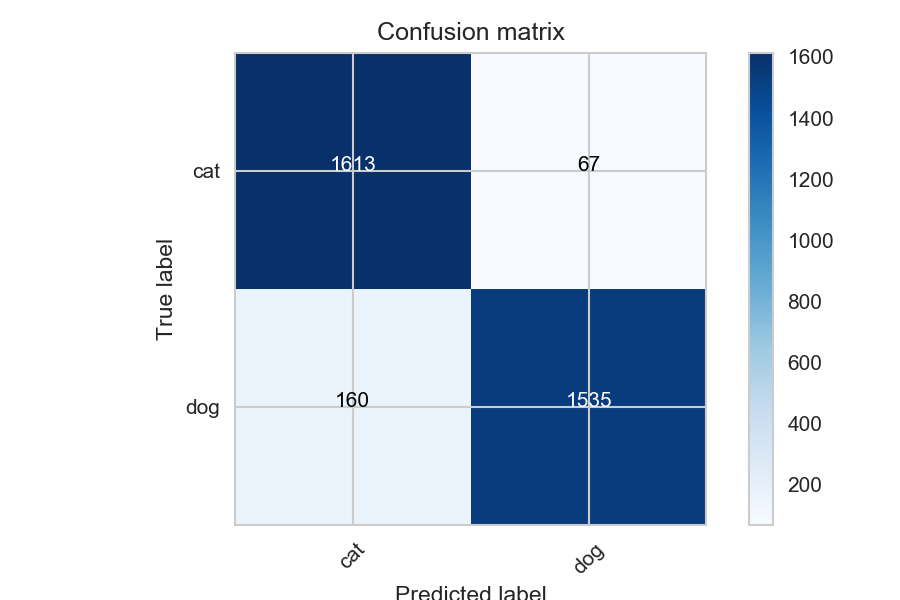

Confusion matrix, without normalization


<IPython.core.display.Javascript object>


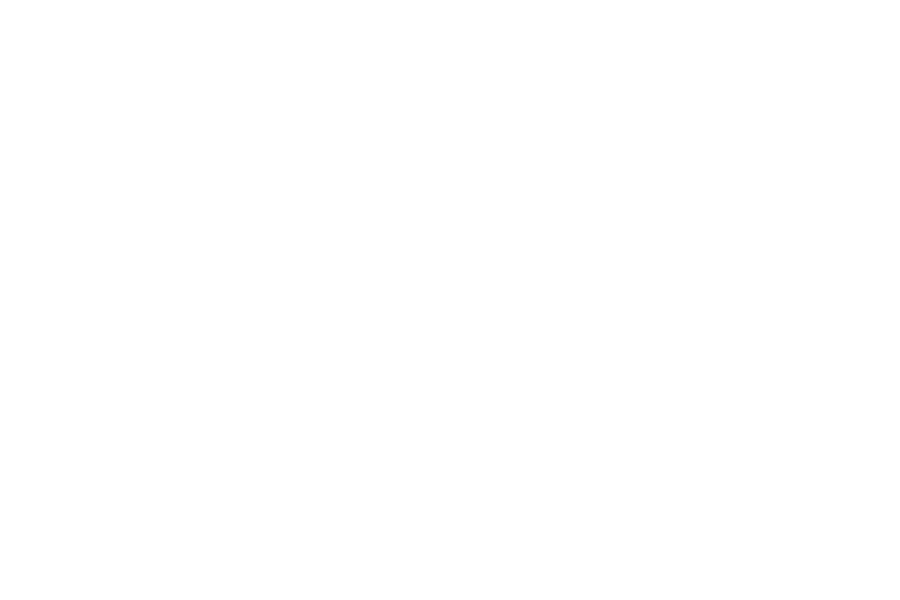

In [16]:
confusion_diagnostic(model)